# 2020-09-22_EcN_Sensors_AllReplicates_v2

### This notebook was duplicated from 2020-09-22_EcN_Sensors_AllReplicates_v2 and then modified for the new way of calculating RNAP flux as of 2021-03-15

Sensor data was a bit funky looking, especially the toxicity data. Played around with inducer stocks and dilution protocols to see what would clean things up. These results are after doing all of that.

Settled on OD normalizing after first outgrowth and using DMSO as inducer solvent for OHC14, Van, and Cuma (250X). aTc didn't show as much weirdness (probably b/c 50% EtOH) so just used 1000X of that and seemed fine.

In [60]:
# Matplotlib interactivity
#matplotlib notebook
import matplotlib
matplotlib.rc('figure', dpi = 160)
matplotlib.rcParams['pdf.fonttype'] = 42 # for making font editable when exported to PDF for Illustrator
matplotlib.rcParams['ps.fonttype'] = 42 # for making font editable when exported to PS for Illustrator

In [61]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import cytoflow as flow
import string
import pandas as pd
import pickle
from scipy.optimize import least_squares
from matplotlib.lines import Line2D
import openpyxl

# Dan's custom scripts that aid in importing from conditions.csv file
sys.path.append('/Users/atriassi/Documents/MIT Dropbox (local)/Voigt Lab/_Data/Flow Cytometry Data/cytoflow_example_fromDan/modules')
import cf_imports
import cf_helpers

In [62]:
# Import reloads for when modules are being changed
import importlib
importlib.reload(cf_imports)
importlib.reload(cf_helpers)

<module 'cf_helpers' from '/Users/atriassi/Documents/MIT Dropbox (local)/Voigt Lab/_Data/Flow Cytometry Data/cytoflow_example_fromDan/modules/cf_helpers.py'>

## Data Import

In [63]:
parent = ['EcN']

In [64]:
strains = ['AJT269','AJT270','AJT273','AJT274','AJT275','AJT276','AJT278','AJT275_dmso','AJT276_dmso','AJT278_dmso']

In [65]:
reps = ['r1','r2','r3']

In [66]:
# autofluorescence values
%store -r AJT206_Sensors_r2_store # mean of 4 technical replicates from 2020-09-18
%store -r AJT206_Sensors_r3_store # mean of 4 technical replicates from 2020-09-21
%store -r AJT206_Sensors_r4_store # mean of 4 technical replicates from 2020-09-22
%store -r AJT206_Sensors_r5_store # mean of 4 technical replicates from 2020-09-23

%store -r AJT206_NOTgates_r1_store # mean of 4 technical replicates from 2020-09-23
%store -r AJT206_NOTgates_r2_store # mean of 4 technical replicates from 2020-09-24
%store -r AJT206_NOTgates_r3_store # mean of 4 technical replicates from 2020-09-25
%store -r AJT206_NOTgates_r4_store # mean of 4 technical replicates from 2020-09-30

# RPU standard values
%store -r AJT280_Sensors_r2_store # mean of 4 technical replicates from 2020-09-18
%store -r AJT280_Sensors_r3_store # mean of 4 technical replicates from 2020-09-21
%store -r AJT280_Sensors_r4_store # mean of 4 technical replicates from 2020-09-22
%store -r AJT280_Sensors_r5_store # mean of 4 technical replicates from 2020-09-23

%store -r AJT280_NOTgates_r1_store # mean of 4 technical replicates from 2020-09-23
%store -r AJT280_NOTgates_r2_store # mean of 4 technical replicates from 2020-09-24
%store -r AJT280_NOTgates_r3_store # mean of 4 technical replicates from 2020-09-25
%store -r AJT280_NOTgates_r4_store # mean of 4 technical replicates from 2020-09-30

no stored variable # mean of 4 technical replicates from 2020-09-18
no stored variable # mean of 4 technical replicates from 2020-09-21
no stored variable # mean of 4 technical replicates from 2020-09-22
no stored variable # mean of 4 technical replicates from 2020-09-23
no stored variable # mean of 4 technical replicates from 2020-09-23
no stored variable # mean of 4 technical replicates from 2020-09-24
no stored variable # mean of 4 technical replicates from 2020-09-25
no stored variable # mean of 4 technical replicates from 2020-09-30
no stored variable # mean of 4 technical replicates from 2020-09-18
no stored variable # mean of 4 technical replicates from 2020-09-21
no stored variable # mean of 4 technical replicates from 2020-09-22
no stored variable # mean of 4 technical replicates from 2020-09-23
no stored variable # mean of 4 technical replicates from 2020-09-23
no stored variable # mean of 4 technical replicates from 2020-09-24
no stored variable # mean of 4 technical replica

In [67]:
# arbitrary units
%store -r AJT269_ODnorm_r1_au_store # from 2020-09-17 Ptac
%store -r AJT270_ODnorm_r1_au_store # from 2020-09-17 Pbad
%store -r AJT273_ODnorm_r1_au_store # from 2020-09-17 Ptet - tox data bad with 250X inducer
%store -r AJT274_ODnorm_r1_au_store # from 2020-09-17 Pttg
%store -r AJT275_ODnorm_r1_au_store # from 2020-09-17 Pcin - tox data bad with 250X inducer
%store -r AJT276_ODnorm_r1_au_store # from 2020-09-17 Pvan - tox data bad with 250X inducer
%store -r AJT278_ODnorm_r1_au_store # from 2020-09-17 Pcym - tox data bad with 250X inducer

%store -r AJT269_ODnorm_r2_au_store # from 2020-09-18 Ptac
%store -r AJT270_ODnorm_r2_au_store # from 2020-09-18 Pbad
%store -r AJT273_ODnorm_r2_au_store # from 2020-09-18 Ptet - tox data better with 1000X inducer
%store -r AJT274_ODnorm_r2_au_store # from 2020-09-18 Pttg
%store -r AJT275_ODnorm_r2_au_store # from 2020-09-18 Pcin - tox data not great with 1000X inducer
%store -r AJT276_ODnorm_r2_au_store # from 2020-09-18 Pvan - tox data not great with 1000X inducer
%store -r AJT278_ODnorm_r2_au_store # from 2020-09-18 Pcym - tox data not great with 1000X inducer

%store -r AJT269_ODnorm_r3_au_store # from 2020-09-21 Ptac
%store -r AJT270_ODnorm_r3_au_store # from 2020-09-21 Pbad
%store -r AJT273_ODnorm_r3_au_store # from 2020-09-21 Ptet
%store -r AJT274_ODnorm_r3_au_store # from 2020-09-21 Pttg
%store -r AJT275_ODnorm_r3_au_store # from 2020-09-21 Pcin - tox data not great with 1000X inducer
%store -r AJT276_ODnorm_r3_au_store # from 2020-09-21 Pvan - tox data not great with 1000X inducer
%store -r AJT278_ODnorm_r3_au_store # from 2020-09-21 Pcym - tox data not great with 1000X inducer

%store -r AJT269_ODnorm_r4_au_store # from 2020-09-22 Ptac
%store -r AJT270_ODnorm_r4_au_store # from 2020-09-22 Pbad
%store -r AJT273_ODnorm_r4_au_store # from 2020-09-22 Ptet
%store -r AJT274_ODnorm_r4_au_store # from 2020-09-22 Pttg
%store -r AJT275_ODnorm_r4_au_store # from 2020-09-22 Pcin
%store -r AJT276_ODnorm_r4_au_store # from 2020-09-22 Pvan
%store -r AJT278_ODnorm_r4_au_store # from 2020-09-22 Pcym

%store -r AJT275_ODnorm_dmso_r1_au_store # from 2020-09-21 Pcin - tox data better with DMSO
%store -r AJT276_ODnorm_dmso_r1_au_store # from 2020-09-21 Pvan - tox data better with DMSO
%store -r AJT278_ODnorm_dmso_r1_au_store # from 2020-09-21 Pcym - tox data better with DMSO

%store -r AJT275_ODnorm_dmso_r2_au_store # from 2020-09-22 Pcin - tox data better with DMSO
%store -r AJT276_ODnorm_dmso_r2_au_store # from 2020-09-22 Pvan - tox data better with DMSO
%store -r AJT278_ODnorm_dmso_r2_au_store # from 2020-09-22 Pcym - tox data better with DMSO

%store -r AJT275_ODnorm_dmso_r3_au_store # from 2020-09-23 Pcin - tox data better with DMSO
%store -r AJT276_ODnorm_dmso_r3_au_store # from 2020-09-23 Pvan - tox data better with DMSO
%store -r AJT278_ODnorm_dmso_r3_au_store # from 2020-09-23 Pcym - tox data better with DMSO

no stored variable # from 2020-09-17 Ptac
no stored variable # from 2020-09-17 Pbad
no stored variable # from 2020-09-17 Ptet - tox data bad with 250X inducer
no stored variable # from 2020-09-17 Pttg
no stored variable # from 2020-09-17 Pcin - tox data bad with 250X inducer
no stored variable # from 2020-09-17 Pvan - tox data bad with 250X inducer
no stored variable # from 2020-09-17 Pcym - tox data bad with 250X inducer
no stored variable # from 2020-09-18 Ptac
no stored variable # from 2020-09-18 Pbad
no stored variable # from 2020-09-18 Ptet - tox data better with 1000X inducer
no stored variable # from 2020-09-18 Pttg
no stored variable # from 2020-09-18 Pcin - tox data not great with 1000X inducer
no stored variable # from 2020-09-18 Pvan - tox data not great with 1000X inducer
no stored variable # from 2020-09-18 Pcym - tox data not great with 1000X inducer
no stored variable # from 2020-09-21 Ptac
no stored variable # from 2020-09-21 Pbad
no stored variable # from 2020-09-21 Pt

In [68]:
data = {'au': 
        {'AJT269': {'r1': AJT269_ODnorm_r2_au_store,
                   'r2': AJT269_ODnorm_r3_au_store,
                   'r3': AJT269_ODnorm_r4_au_store}, 
        'AJT270': {'r1': AJT270_ODnorm_r2_au_store,
                   'r2': AJT270_ODnorm_r3_au_store,
                   'r3': AJT270_ODnorm_r4_au_store},
        'AJT273': {'r1': AJT273_ODnorm_r2_au_store,
                   'r2': AJT273_ODnorm_r3_au_store,
                   'r3': AJT273_ODnorm_r4_au_store},
        'AJT274': {'r1': AJT274_ODnorm_r2_au_store,
                   'r2': AJT274_ODnorm_r3_au_store,
                   'r3': AJT274_ODnorm_r4_au_store},
        'AJT275': {'r1': AJT275_ODnorm_r2_au_store,
                   'r2': AJT275_ODnorm_r3_au_store,
                   'r3': AJT275_ODnorm_r4_au_store},
        'AJT276': {'r1': AJT276_ODnorm_r2_au_store,
                   'r2': AJT276_ODnorm_r3_au_store,
                   'r3': AJT276_ODnorm_r4_au_store},
        'AJT278': {'r1': AJT278_ODnorm_r2_au_store,
                   'r2': AJT278_ODnorm_r3_au_store,
                   'r3': AJT278_ODnorm_r4_au_store},
         'AJT275_dmso': {'r1': AJT275_ODnorm_dmso_r1_au_store,
                   'r2': AJT275_ODnorm_dmso_r2_au_store,
                   'r3': AJT275_ODnorm_dmso_r3_au_store},
         'AJT276_dmso': {'r1': AJT276_ODnorm_dmso_r1_au_store,
                   'r2': AJT276_ODnorm_dmso_r2_au_store,
                   'r3': AJT276_ODnorm_dmso_r3_au_store},
         'AJT278_dmso': {'r1': AJT278_ODnorm_dmso_r1_au_store,
                   'r2': AJT278_ODnorm_dmso_r2_au_store,
                   'r3': AJT278_ODnorm_dmso_r3_au_store}
        }}   #,

#         'RPU': 
#         {'AJT269': {'r1': ,
#                    'r2': ,
#                    'r3': },
#         'AJT270': {'r1': ,
#                    'r2': ,
#                    'r3': },
#         'AJT273': {'r1': ,
#                    'r2': ,
#                    'r3': },
#         'AJT274': {'r1': ,
#                    'r2': ,
#                    'r3': },
#         'AJT275': {'r1': ,
#                    'r2': ,
#                    'r3': },
#         'AJT276': {'r1': ,
#                    'r2': ,
#                    'r3': },
#         'AJT278': {'r1': ,
#                    'r2': ,
#                    'r3': }}}

In [69]:
fluor = ['au'] #,'RPU']
r123 = dict()

means = dict()
stdevs = dict()
for f in fluor:
    means[f] = dict()
    stdevs[f] = dict()
    for s in strains:
        r123[s] = pd.concat([data[f][s]['r1'],data[f][s]['r2'],data[f][s]['r3']], axis=1)
        means[f][s] = r123[s].mean(axis=1)
        stdevs[f][s] = r123[s].std(axis=1)
        
    for s in ['AJT206','AJT280']:
        if s == 'AJT206':
            means[f][s] = np.array([AJT206_Sensors_r2_store, AJT206_Sensors_r3_store, AJT206_Sensors_r4_store, AJT206_Sensors_r5_store,
                                    AJT206_NOTgates_r1_store, AJT206_NOTgates_r2_store, AJT206_NOTgates_r3_store, AJT206_NOTgates_r4_store]).mean()
        elif s == 'AJT280':
            means[f][s] = np.array([AJT280_Sensors_r2_store, AJT280_Sensors_r3_store, AJT280_Sensors_r4_store, AJT280_Sensors_r5_store,
                                    AJT280_NOTgates_r1_store, AJT280_NOTgates_r2_store, AJT280_NOTgates_r3_store, AJT280_NOTgates_r4_store]).mean()
            
#         print(r123)
        
means['au']['AJT275_dmso']

0.000000       33.170001
0.019531       39.990000
0.039062      123.690000
0.078125      553.350006
0.156250     1724.065043
0.312500     3045.750000
1.250000     3698.920085
10.000000    4177.250000
dtype: float64

In [70]:
stdevs['au']['AJT275_dmso']

0.000000       2.684679
0.019531       1.859999
0.039062      47.192342
0.078125     217.168456
0.156250     504.488883
0.312500     184.648897
1.250000     176.832952
10.000000    160.320089
dtype: float64

In [71]:
means['au']['AJT278_dmso']

0.000000       351.539998
1.953125       384.710002
3.906250       424.080007
7.812500       567.300008
15.625000     1215.820028
31.250000     2573.000081
62.500000     3438.210042
500.000000    3729.610026
dtype: float64

In [72]:
r123['AJT275_dmso']

AJT275_dmso  AJT275_dmso  AJT275_dmso
0.000000     36.270000    31.620001    31.620001
0.019531     39.990002    38.130001    41.849998
0.039062     81.840004   174.839996   114.389999
0.078125    337.589996   771.900024   550.559998
0.156250   1156.455017  1894.410034  2121.330078
0.312500   3050.399902  2858.820068  3228.030029
1.250000   3774.870117  3496.800049  3825.090088
10.000000  4301.250000  3996.209961  4234.290039

In [73]:
## subtracting single autofluorescence value and dividing by single RPU value for aribtrary unit data

## took mean of AJT206 technical replicates from same day and then took mean of those means across many days (all sensors and repressor runs)
## did same for AJT280 to get RPU value

A = round(means['au']['AJT206'],0)
R = means['au']['AJT280'] - A

print(A,R)

# Store for using in individual replicate notebooks
AJT206_auto_store = A
AJT280_RPUg_store = R
%store AJT206_auto_store
%store AJT280_RPUg_store


means_RPU = dict()
stdevs_RPU = dict()
r123_RPU = dict()

for s in strains:
    r123_RPU[s] = pd.concat([data['au'][s]['r1'],data['au'][s]['r2'],data['au'][s]['r3']], axis=1, keys = ['r1','r2','r3'])
        
    r123_RPU[s] = r123_RPU[s].subtract(A)
    print(r123_RPU)
    r123_RPU[s] = r123_RPU[s].div(R)
    
    # artificially set a lower bond as the lowest value observed 
    # with Pcin that wasn't negative. Standard deviation will be 0 
    # since all of these points are now identical for each replicate
    # Did this in order to fix curve fitting of the Pcin data
    r123_RPU[s] = r123_RPU[s].clip(lower=0.003163)
    print(r123_RPU)
    means_RPU[s] = r123_RPU[s].mean(axis=1)
    stdevs_RPU[s] = r123_RPU[s].std(axis=1)

33.0 954.3968868255615
Stored 'AJT206_auto_store' (float64)
Stored 'AJT280_RPUg_store' (float64)
{'AJT269':                  r1           r2           r3
0.0       20.939999    23.730000    16.290001
5.0       28.380001    32.099998    23.730000
15.0      76.739998    78.599998    69.300003
25.0     218.100006   219.029999   261.809998
40.0    1322.940063  1362.000000  1545.209961
70.0    2290.140137  2265.030029  2287.350098
200.0   3061.110107  3175.500000  2880.689941
1000.0  3465.659912  3647.010010  3363.360107}
{'AJT269':               r1        r2        r3
0.0     0.021941  0.024864  0.017068
5.0     0.029736  0.033634  0.024864
15.0    0.080407  0.082356  0.072611
25.0    0.228521  0.229496  0.274320
40.0    1.386153  1.427079  1.619043
70.0    2.399568  2.373258  2.396645
200.0   3.207376  3.327232  3.018335
1000.0  3.631257  3.821272  3.524069}
{'AJT269':               r1        r2        r3
0.0     0.021941  0.024864  0.017068
5.0     0.029736  0.033634  0.024864
15.0    0.

{'AJT269':               r1        r2        r3
0.0     0.021941  0.024864  0.017068
5.0     0.029736  0.033634  0.024864
15.0    0.080407  0.082356  0.072611
25.0    0.228521  0.229496  0.274320
40.0    1.386153  1.427079  1.619043
70.0    2.399568  2.373258  2.396645
200.0   3.207376  3.327232  3.018335
1000.0  3.631257  3.821272  3.524069, 'AJT270':                r1        r2        r3
0.00     0.023889  0.028762  0.019017
31.25    0.026813  0.035583  0.024864
125.00   0.041429  0.066765  0.045327
250.00   0.067739  0.114512  0.130103
500.00   0.142771  1.877269  1.506983
1000.00  1.808084  3.008591  2.609072
2000.00  2.814678  3.181067  2.858528
4000.00  2.969614  3.215172  2.917968, 'AJT273':               r1        r2        r3
0.00    0.023889  0.027787  0.019017
0.78    0.023889  0.027787  0.020966
1.56    0.023889  0.029736  0.024864
3.12    0.027787  0.032659  0.024864
6.25    0.058969  0.095998  0.098921
12.50   0.526699  1.213677  1.125978
50.00   5.374525  5.776968  5.539

{'AJT269':               r1        r2        r3
0.0     0.021941  0.024864  0.017068
5.0     0.029736  0.033634  0.024864
15.0    0.080407  0.082356  0.072611
25.0    0.228521  0.229496  0.274320
40.0    1.386153  1.427079  1.619043
70.0    2.399568  2.373258  2.396645
200.0   3.207376  3.327232  3.018335
1000.0  3.631257  3.821272  3.524069, 'AJT270':                r1        r2        r3
0.00     0.023889  0.028762  0.019017
31.25    0.026813  0.035583  0.024864
125.00   0.041429  0.066765  0.045327
250.00   0.067739  0.114512  0.130103
500.00   0.142771  1.877269  1.506983
1000.00  1.808084  3.008591  2.609072
2000.00  2.814678  3.181067  2.858528
4000.00  2.969614  3.215172  2.917968, 'AJT273':               r1        r2        r3
0.00    0.023889  0.027787  0.019017
0.78    0.023889  0.027787  0.020966
1.56    0.023889  0.029736  0.024864
3.12    0.027787  0.032659  0.024864
6.25    0.058969  0.095998  0.098921
12.50   0.526699  1.213677  1.125978
50.00   5.374525  5.776968  5.539

In [74]:
# ## Write dictionary of dataframes to separate sheets of the same Excel workbook

# from openpyxl import load_workbook

# book = load_workbook('/Users/atriassi/Dropbox (Personal)/Education/Grad School/*Papers/Triassi_CellSystems_submission_v1/data/fig2b_data.xlsx')
# writer = pd.ExcelWriter('/Users/atriassi/Dropbox (Personal)/Education/Grad School/*Papers/Triassi_CellSystems_submission_v1/data/fig2b_data.xlsx', engine='openpyxl') 

# for df_name, df in r123_RPU.items():
#     df.to_excel(writer, sheet_name=df_name)

# writer.save()


In [75]:
r123_RPU['AJT275_dmso']

r1        r2        r3
0.000000   0.003426  0.003163  0.003163
0.019531   0.007324  0.005375  0.009273
0.039062   0.051174  0.148617  0.085279
0.078125   0.319144  0.774206  0.542290
0.156250   1.177136  1.950352  2.188115
0.312500   3.161578  2.960844  3.347695
1.250000   3.920665  3.629308  3.973284
10.000000  4.472196  4.152581  4.402037

In [76]:
means_RPU['AJT275_dmso']

0.000000     0.003251
0.019531     0.007324
0.039062     0.095023
0.078125     0.545213
0.156250     1.771868
0.312500     3.156706
1.250000     3.841086
10.000000    4.342271
dtype: float64

In [77]:
# AJT269_means_RPU_store = means_RPU['AJT269']

# %store AJT269_means_RPU_store # to be used in NOT gates document as input RPU values

In [78]:
r123['AJT275_dmso']-A

AJT275_dmso  AJT275_dmso  AJT275_dmso
0.000000      3.270000    -1.379999    -1.379999
0.019531      6.990002     5.130001     8.849998
0.039062     48.840004   141.839996    81.389999
0.078125    304.589996   738.900024   517.559998
0.156250   1123.455017  1861.410034  2088.330078
0.312500   3017.399902  2825.820068  3195.030029
1.250000   3741.870117  3463.800049  3792.090088
10.000000  4268.250000  3963.209961  4201.290039

In [79]:
# RNAPflux = 0.029 # RNAP/s-DNA for MG1655 measured in Bin's paper
# copy_num = 13.2 # copy number of p15a plasmid in Bin's paper in MG1655
# RNAPflux_conv_factor = RNAPflux*copy_num/4970 # 4970 is mean fluorescence (autosubtracted) observed from YFP construct on p15a plasmid in EcN from 2021-01-20-22 (all reps in 2021-01-14_EcN_RelativeExpression_AllReplicates notebook)

# r123_RNAP = dict()
# means_RNAP = dict()
# stdevs_RNAP = dict()

# for s in strains:
#     r123_RNAP[s] = (r123[s] - A)*RNAPflux_conv_factor
#     print(r123_RNAP)
    
#     means_RNAP[s] = r123_RNAP[s].mean(axis=1)
#     stdevs_RNAP[s] = r123_RNAP[s].std(axis=1)

In [80]:
# means_RNAP

In [81]:
# AJT269_means_RNAP_store = means_RNAP['AJT269']
# AJT269_stdevs_RNAP_store = stdevs_RNAP['AJT269']

# %store AJT269_means_RNAP_store # to be used in NOT gates document as input RPU values
# %store AJT269_stdevs_RNAP_store

In [82]:
%store -r inducer_info_8conc_paper # from 2020-09-17 Sensors

no stored variable # from 2020-09-17 Sensors


In [83]:
inducers = ['iptg', 'ara', 'atc','nar','ohc14','van','cuma'] 

inducer_info = inducer_info_8conc_paper 

inducer_info

{'iptg': {'color': '#fbb03b',
  'conc': [0.0, 5.0, 15.0, 25.0, 40.0, 70.0, 200.0, 1000.0],
  'plot_conc': [2.5, 5.0, 15.0, 25.0, 40.0, 70.0, 200.0, 1000.0]},
 'ara': {'color': '#016837',
  'conc': [0.0, 31.25, 125.0, 250.0, 500.0, 1000.0, 2000.0, 4000.0],
  'plot_conc': [15.625, 31.25, 125.0, 250.0, 500.0, 1000.0, 2000.0, 4000.0]},
 'atc': {'color': '#00ffff',
  'conc': [0.0, 0.78, 1.56, 3.12, 6.25, 12.5, 50.0, 400.0],
  'plot_conc': [0.39, 0.78, 1.56, 3.12, 6.25, 12.5, 50.0, 400.0]},
 'nar': {'color': '#0071bb',
  'conc': [0.0, 0.9765625, 3.90625, 15.625, 31.25, 62.5, 250.0, 1000.0],
  'plot_conc': [0.48, 0.9765625, 3.90625, 15.625, 31.25, 62.5, 250.0, 1000.0]},
 'ohc14': {'color': '#00b4ff',
  'conc': [0.0, 0.01953125, 0.0390625, 0.078125, 0.15625, 0.3125, 1.25, 10.0],
  'plot_conc': [0.009,
   0.01953125,
   0.0390625,
   0.078125,
   0.15625,
   0.3125,
   1.25,
   10.0]},
 'van': {'color': '#ff00ff',
  'conc': [0.0, 1.56125, 6.25, 12.5, 25.0, 50.0, 100.0, 200.0],
  'plot_conc': [0

In [84]:
%store -r inducer_info_8conc_paper_withdmso

In [85]:
inducers_withdmso = [ 'ara', 'iptg','atc','cuma_dmso','van_dmso','ohc14_dmso','nar','cuma','van','ohc14'] 

inducer_info_withdmso = inducer_info_8conc_paper_withdmso 

In [86]:
inducer_info_withdmso

{'iptg': {'color': '#fbb03b',
  'conc': [0.0, 5.0, 15.0, 25.0, 40.0, 70.0, 200.0, 1000.0],
  'plot_conc': [2.5, 5.0, 15.0, 25.0, 40.0, 70.0, 200.0, 1000.0],
  'column': 3},
 'ara': {'color': '#016837',
  'conc': [0.0, 31.25, 125.0, 250.0, 500.0, 1000.0, 2000.0, 4000.0],
  'plot_conc': [15.625, 31.25, 125.0, 250.0, 500.0, 1000.0, 2000.0, 4000.0],
  'column': 5},
 'atc': {'color': '#00ffff',
  'conc': [0.0, 0.78, 1.56, 3.12, 6.25, 12.5, 50.0, 400.0],
  'plot_conc': [0.39, 0.78, 1.56, 3.12, 6.25, 12.5, 50.0, 400.0],
  'column': 7},
 'nar': {'color': '#0071bb',
  'conc': [0.0, 0.9765625, 3.90625, 15.625, 31.25, 62.5, 250.0, 1000.0],
  'plot_conc': [0.48, 0.9765625, 3.90625, 15.625, 31.25, 62.5, 250.0, 1000.0],
  'column': 9},
 'ohc14': {'color': '#00b4ff',
  'conc': [0.0, 0.01953125, 0.0390625, 0.078125, 0.15625, 0.3125, 1.25, 10.0],
  'plot_conc': [0.009,
   0.01953125,
   0.0390625,
   0.078125,
   0.15625,
   0.3125,
   1.25,
   10.0],
  'column': 1},
 'van': {'color': '#ff00ff',
  'con

In [87]:
# NEW COLORS
# dictionary with strain information that can be copied from experiment to experiment
strain_info = dict([('AJT206', {'color': 'k', 
                                'promoter': 'none',
                                'inducer': 'none',
                               'parent': 'EcN'}), 
                      ('AJT280',{'color': 'k', 
                                 'promoter': 'RPU',
                                'inducer': 'none',
                               'parent': 'EcN'}),
                      ('AJT269',{'color': '#fbb03b', 
                                 'promoter': '$P_{Tac}$',
                                'inducer': 'iptg',
                               'parent': 'EcN'}),
                      ('AJT270',{'color': '#016837', 
                                 'promoter': '$P_{BAD_{mc1}}$',
                                'inducer': 'ara',
                               'parent': 'EcN'}),
                      ('AJT271',{'color': '#016837', 
                                 'promoter': '$P_{BAD_{mc}}$',
                                'inducer': 'ara',
                               'parent': 'EcN'}),
                      ('AJT272',{'color': '#00ffff', 
                                 'promoter': '$P_{Tet_{D18}}$',
                                'inducer': 'atc',
                               'parent': 'EcN'}),
                      ('AJT273',{'color': '#00ffff', 
                                 'promoter': '$P_{Tet_{Org}}$',
                                'inducer': 'atc',
                               'parent': 'EcN'}),
                      ('AJT274',{'color': '#0071bb', 
                                'promoter': '$P_{Ttg_{v1}}$',
                                 'inducer': 'nar',
                               'parent': 'EcN'}),
                      ('AJT275',{'color': '#A259FF', 
                                'promoter': '$P_{Cin}$',
                                'inducer': 'ohc14',
                               'parent': 'EcN'}),
                      ('AJT276',{'color': '#FFA8D5', 
                                 'promoter': '$P_{Van_{v2}}$',
                                'inducer': 'van',
                               'parent': 'EcN'}),
                      ('AJT277',{'color': '#ff0000', 
                                'promoter': '$P_{CymRC_{v1}}$',
                                'inducer': 'cuma',
                               'parent': 'EcN'}),
                      ('AJT278',{'color': '#ff0000', 
                                 'promoter': '$P_{CymRC_{v2}}$',
                                'inducer': 'cuma',
                               'parent': 'EcN'}),
                      ('AJT279',{'color': '#ff00ff', 
                                 'promoter': '$P_{Van_{v1}}$',
                                'inducer': 'van',
                               'parent': 'EcN'}),
                    
                      ('AJT361',{'color': 'k', 
                                 'promoter': 'none',
                                'inducer': 'none',
                               'parent': 'AJT209'}),
                      ('AJT374',{'color': 'k',
                                'promoter': 'none',
                                'inducer':'none',
                               'parent': 'AJT209'}),
                      ('AJT367',{'color': '#fbb03b', 
                                 'promoter': '$P_{Tac}$',
                                'inducer': 'iptg',
                               'parent': 'AJT209'}),
                      ('AJT368',{'color': '#016837', 
                                 'promoter': '$P_{BAD_{mc1}}$',
                                'inducer': 'ara',
                               'parent': 'AJT209'}),
                      ('AJT369',{'color': '#00ffff', 
                                 'promoter': '$P_{Tet_{Org}}$',
                                'inducer': 'atc',
                               'parent': 'AJT209'}),
                      ('AJT370',{'color': '#0071bb', 
                                'promoter': '$P_{Ttg_{v1}}$',
                                 'inducer': 'nar',
                               'parent': 'AJT209'}),
                      ('AJT371',{'color': '#00b4ff', 
                                'promoter': '$P_{Cin}$',
                                'inducer': 'ohc14',
                               'parent': 'AJT209'}),
                      ('AJT372',{'color': '#ff00ff', 
                                 'promoter': '$P_{Van_{v2}}$',
                                'inducer': 'van',
                               'parent': 'AJT209'}),
                      ('AJT373',{'color': '#ff0000', 
                                 'promoter': '$P_{CymRC_{v2}}$',
                                'inducer': 'cuma',
                               'parent': 'AJT209'}),

                    
                      ('AJT362',{'color': 'k', 
                                 'promoter': 'none',
                                'inducer': 'none',
                               'parent': 'AJT207'}),
                      ('AJT382',{'color': 'k',
                                'promoter': 'none',
                                'inducer':'none',
                               'parent': 'AJT207'}),
                      ('AJT375',{'color': '#fbb03b', 
                                 'promoter': '$P_{Tac}$',
                                'inducer': 'iptg',
                               'parent': 'AJT207'}),
                      ('AJT376',{'color': '#016837', 
                                 'promoter': '$P_{BAD_{mc1}}$',
                                'inducer': 'ara',
                               'parent': 'AJT207'}),
                      ('AJT377',{'color': '#00ffff', 
                                 'promoter': '$P_{Tet_{Org}}$',
                                'inducer': 'atc',
                               'parent': 'AJT207'}),
                      ('AJT378',{'color': '#0071bb', 
                                'promoter': '$P_{Ttg_{v1}}$',
                                 'inducer': 'nar',
                               'parent': 'AJT207'}),
                      ('AJT379',{'color': '#00b4ff', 
                                'promoter': '$P_{Cin}$',
                                'inducer': 'ohc14',
                               'parent': 'AJT207'}),
                      ('AJT380',{'color': '#ff00ff', 
                                 'promoter': '$P_{Van_{v2}}$',
                                'inducer': 'van',
                               'parent': 'AJT207'}),
                      ('AJT381',{'color': '#ff0000', 
                                 'promoter': '$P_{CymRC_{v2}}$',
                                'inducer': 'cuma',
                               'parent': 'AJT207'}),                    
                   ])

In [88]:
# ## OLD COLORS
# # dictionary with strain information that can be copied from experiment to experiment
# strain_info = dict([('AJT206', {'color': 'k', 
#                                 'promoter': 'none',
#                                 'inducer': 'none',
#                                'parent': 'EcN'}), 
#                       ('AJT280',{'color': 'k', 
#                                  'promoter': 'RPU',
#                                 'inducer': 'none',
#                                'parent': 'EcN'}),
#                       ('AJT269',{'color': '#fbb03b', 
#                                  'promoter': '$P_{Tac}$',
#                                 'inducer': 'iptg',
#                                'parent': 'EcN'}),
#                       ('AJT270',{'color': '#016837', 
#                                  'promoter': '$P_{BAD_{mc1}}$',
#                                 'inducer': 'ara',
#                                'parent': 'EcN'}),
#                       ('AJT271',{'color': '#016837', 
#                                  'promoter': '$P_{BAD_{mc}}$',
#                                 'inducer': 'ara',
#                                'parent': 'EcN'}),
#                       ('AJT272',{'color': '#00ffff', 
#                                  'promoter': '$P_{Tet_{D18}}$',
#                                 'inducer': 'atc',
#                                'parent': 'EcN'}),
#                       ('AJT273',{'color': '#00ffff', 
#                                  'promoter': '$P_{Tet_{Org}}$',
#                                 'inducer': 'atc',
#                                'parent': 'EcN'}),
#                       ('AJT274',{'color': '#0071bb', 
#                                 'promoter': '$P_{Ttg_{v1}}$',
#                                  'inducer': 'nar',
#                                'parent': 'EcN'}),
#                       ('AJT275',{'color': '#00b4ff', 
#                                 'promoter': '$P_{Cin}$',
#                                 'inducer': 'ohc14',
#                                'parent': 'EcN'}),
#                       ('AJT276',{'color': '#ff00ff', 
#                                  'promoter': '$P_{Van_{v2}}$',
#                                 'inducer': 'van',
#                                'parent': 'EcN'}),
#                       ('AJT277',{'color': '#ff0000', 
#                                 'promoter': '$P_{CymRC_{v1}}$',
#                                 'inducer': 'cuma',
#                                'parent': 'EcN'}),
#                       ('AJT278',{'color': '#ff0000', 
#                                  'promoter': '$P_{CymRC_{v2}}$',
#                                 'inducer': 'cuma',
#                                'parent': 'EcN'}),
#                       ('AJT279',{'color': '#ff00ff', 
#                                  'promoter': '$P_{Van_{v1}}$',
#                                 'inducer': 'van',
#                                'parent': 'EcN'}),
                    
#                       ('AJT361',{'color': 'k', 
#                                  'promoter': 'none',
#                                 'inducer': 'none',
#                                'parent': 'AJT209'}),
#                       ('AJT374',{'color': 'k',
#                                 'promoter': 'none',
#                                 'inducer':'none',
#                                'parent': 'AJT209'}),
#                       ('AJT367',{'color': '#fbb03b', 
#                                  'promoter': '$P_{Tac}$',
#                                 'inducer': 'iptg',
#                                'parent': 'AJT209'}),
#                       ('AJT368',{'color': '#016837', 
#                                  'promoter': '$P_{BAD_{mc1}}$',
#                                 'inducer': 'ara',
#                                'parent': 'AJT209'}),
#                       ('AJT369',{'color': '#00ffff', 
#                                  'promoter': '$P_{Tet_{Org}}$',
#                                 'inducer': 'atc',
#                                'parent': 'AJT209'}),
#                       ('AJT370',{'color': '#0071bb', 
#                                 'promoter': '$P_{Ttg_{v1}}$',
#                                  'inducer': 'nar',
#                                'parent': 'AJT209'}),
#                       ('AJT371',{'color': '#00b4ff', 
#                                 'promoter': '$P_{Cin}$',
#                                 'inducer': 'ohc14',
#                                'parent': 'AJT209'}),
#                       ('AJT372',{'color': '#ff00ff', 
#                                  'promoter': '$P_{Van_{v2}}$',
#                                 'inducer': 'van',
#                                'parent': 'AJT209'}),
#                       ('AJT373',{'color': '#ff0000', 
#                                  'promoter': '$P_{CymRC_{v2}}$',
#                                 'inducer': 'cuma',
#                                'parent': 'AJT209'}),

                    
#                       ('AJT362',{'color': 'k', 
#                                  'promoter': 'none',
#                                 'inducer': 'none',
#                                'parent': 'AJT207'}),
#                       ('AJT382',{'color': 'k',
#                                 'promoter': 'none',
#                                 'inducer':'none',
#                                'parent': 'AJT207'}),
#                       ('AJT375',{'color': '#fbb03b', 
#                                  'promoter': '$P_{Tac}$',
#                                 'inducer': 'iptg',
#                                'parent': 'AJT207'}),
#                       ('AJT376',{'color': '#016837', 
#                                  'promoter': '$P_{BAD_{mc1}}$',
#                                 'inducer': 'ara',
#                                'parent': 'AJT207'}),
#                       ('AJT377',{'color': '#00ffff', 
#                                  'promoter': '$P_{Tet_{Org}}$',
#                                 'inducer': 'atc',
#                                'parent': 'AJT207'}),
#                       ('AJT378',{'color': '#0071bb', 
#                                 'promoter': '$P_{Ttg_{v1}}$',
#                                  'inducer': 'nar',
#                                'parent': 'AJT207'}),
#                       ('AJT379',{'color': '#00b4ff', 
#                                 'promoter': '$P_{Cin}$',
#                                 'inducer': 'ohc14',
#                                'parent': 'AJT207'}),
#                       ('AJT380',{'color': '#ff00ff', 
#                                  'promoter': '$P_{Van_{v2}}$',
#                                 'inducer': 'van',
#                                'parent': 'AJT207'}),
#                       ('AJT381',{'color': '#ff0000', 
#                                  'promoter': '$P_{CymRC_{v2}}$',
#                                 'inducer': 'cuma',
#                                'parent': 'AJT207'}),                    
#                    ])

In [89]:
## NEW COLORS
# dictionary with strain information that can be copied from experiment to experiment
strain_info_withdmso = dict([('AJT206', {'color': 'k', 
                                'promoter': 'none',
                                'inducer': 'none',
                               'parent': 'EcN'}), 
                      ('AJT280',{'color': 'k', 
                                 'promoter': 'RPU',
                                'inducer': 'none',
                               'parent': 'EcN'}),
                      ('AJT269',{'color': '#fbb03b', 
                                 'promoter': '$P_{Tac}$',
                                'inducer': 'iptg',
                               'parent': 'EcN'}),
                      ('AJT270',{'color': '#016837', 
                                 'promoter': '$P_{BAD_{mc1}}$',
                                'inducer': 'ara',
                               'parent': 'EcN'}),
                      ('AJT273',{'color': '#00ffff', 
                                 'promoter': '$P_{Tet_{Org}}$',
                                'inducer': 'atc',
                               'parent': 'EcN'}),
                      ('AJT274',{'color': '#0071bb', 
                                'promoter': '$P_{Ttg_{v1}}$',
                                 'inducer': 'nar',
                               'parent': 'EcN'}),
                      ('AJT275',{'color': '#A259FF', 
                                'promoter': '$P_{Cin}$',
                                'inducer': 'ohc14',
                               'parent': 'EcN'}),
                      ('AJT276',{'color': '#FFA8D5', 
                                 'promoter': '$P_{Van_{v2}}$',
                                'inducer': 'van',
                               'parent': 'EcN'}),
                      ('AJT278',{'color': '#ff0000', 
                                 'promoter': '$P_{CymRC_{v2}}$',
                                'inducer': 'cuma',
                               'parent': 'EcN'}), 
                      ('AJT275_dmso',{'color': '#A259FF', 
                                'promoter': '$P_{Cin}$',
                                'inducer': 'ohc14_dmso',
                               'parent': 'EcN'}),
                      ('AJT276_dmso',{'color': '#FFA8D5', 
                                 'promoter': '$P_{Van_{v2}}$',
                                'inducer': 'van_dmso',
                               'parent': 'EcN'}),
                      ('AJT278_dmso',{'color': '#ff0000', 
                                 'promoter': '$P_{CymRC_{v2}}$',
                                'inducer': 'cuma_dmso',
                               'parent': 'EcN'})
                   ])

In [90]:
# ## OLD COLORS
# # dictionary with strain information that can be copied from experiment to experiment
# strain_info_withdmso = dict([('AJT206', {'color': 'k', 
#                                 'promoter': 'none',
#                                 'inducer': 'none',
#                                'parent': 'EcN'}), 
#                       ('AJT280',{'color': 'k', 
#                                  'promoter': 'RPU',
#                                 'inducer': 'none',
#                                'parent': 'EcN'}),
#                       ('AJT269',{'color': '#fbb03b', 
#                                  'promoter': '$P_{Tac}$',
#                                 'inducer': 'iptg',
#                                'parent': 'EcN'}),
#                       ('AJT270',{'color': '#016837', 
#                                  'promoter': '$P_{BAD_{mc1}}$',
#                                 'inducer': 'ara',
#                                'parent': 'EcN'}),
#                       ('AJT273',{'color': '#00ffff', 
#                                  'promoter': '$P_{Tet_{Org}}$',
#                                 'inducer': 'atc',
#                                'parent': 'EcN'}),
#                       ('AJT274',{'color': '#0071bb', 
#                                 'promoter': '$P_{Ttg_{v1}}$',
#                                  'inducer': 'nar',
#                                'parent': 'EcN'}),
#                       ('AJT275',{'color': '#00b4ff', 
#                                 'promoter': '$P_{Cin}$',
#                                 'inducer': 'ohc14',
#                                'parent': 'EcN'}),
#                       ('AJT276',{'color': '#ff00ff', 
#                                  'promoter': '$P_{Van_{v2}}$',
#                                 'inducer': 'van',
#                                'parent': 'EcN'}),
#                       ('AJT278',{'color': '#ff0000', 
#                                  'promoter': '$P_{CymRC_{v2}}$',
#                                 'inducer': 'cuma',
#                                'parent': 'EcN'}), 
#                       ('AJT275_dmso',{'color': '#00b4ff', 
#                                 'promoter': '$P_{Cin}$',
#                                 'inducer': 'ohc14_dmso',
#                                'parent': 'EcN'}),
#                       ('AJT276_dmso',{'color': '#ff00ff', 
#                                  'promoter': '$P_{Van_{v2}}$',
#                                 'inducer': 'van_dmso',
#                                'parent': 'EcN'}),
#                       ('AJT278_dmso',{'color': '#ff0000', 
#                                  'promoter': '$P_{CymRC_{v2}}$',
#                                 'inducer': 'cuma_dmso',
#                                'parent': 'EcN'})
#                    ])

In [91]:
# dictionary with strain information that can be copied from experiment to experiment
strain_info_dmso = dict([('AJT275_dmso',{'color': '#A259FF', 
                                'promoter': '$P_{Cin}$',
                                'inducer': 'ohc14_dmso',
                               'parent': 'EcN'}),
                      ('AJT276_dmso',{'color': '#ff00ff', 
                                 'promoter': '$P_{Van_{v2}}$',
                                'inducer': 'van_dmso',
                               'parent': 'EcN'}),
                      ('AJT278_dmso',{'color': '#ff0000', 
                                 'promoter': '$P_{CymRC_{v2}}$',
                                'inducer': 'cuma_dmso',
                               'parent': 'EcN'})])

In [92]:
plot_info = dict()

for r in reps:
    plot_info[r] = dict()
    for i in inducers:
        if r == 'r1':
            plot_info[r][i] = {'marker': 'o',
                               'facecolor': 'white',
                               'edgecolor': 'black',
                               'linecolor': 'black'}
#                                'edgecolor': 'darkgrey',
#                                'linecolor': 'darkgrey'}
        elif r == 'r2':
            plot_info[r][i] =  {'marker': 'o',
                               'facecolor': 'white',
                                'edgecolor': 'darkgrey',
#                                'edgecolor': inducer_info[i]['color'],
                               'linecolor': 'darkgrey'}
            
        elif r == 'r3':
            plot_info[r][i] =  {'marker': 'o',
#                                'facecolor': inducer_info[i]['color'],
                               'facecolor': 'white',
                                'edgecolor': 'lightgrey',
                                'linecolor': 'lightgrey'}
#                                'edgecolor': 'k',
#                                 'linecolor': 'k'}
#                                'linecolor': inducer_info[i]['color']}

In [93]:
plot_info_withdmso = dict()

for r in reps:
    plot_info_withdmso[r] = dict()
    for i in inducers_withdmso:
        if r == 'r1':
            plot_info_withdmso[r][i] = {'marker': 'o',
                               'facecolor': 'white',
                               'edgecolor': 'black',
                               'linecolor': 'black'}
#                                'edgecolor': 'darkgrey',
#                                'linecolor': 'darkgrey'}
        elif r == 'r2':
            plot_info_withdmso[r][i] =  {'marker': 'o',
                               'facecolor': 'white',
                                'edgecolor': 'darkgrey',
#                                'edgecolor': inducer_info[i]['color'],
                               'linecolor': 'darkgrey'}
            
        elif r == 'r3':
            plot_info_withdmso[r][i] =  {'marker': 'o',
#                                'facecolor': inducer_info[i]['color'],
                               'facecolor': 'white',
                                'edgecolor': 'lightgrey',
                                'linecolor': 'lightgrey'}
#                                'edgecolor': 'k',
#                                 'linecolor': 'k'}
#                                'linecolor': inducer_info[i]['color']}

In [94]:
strains_dmso = ['AJT275_dmso','AJT276_dmso','AJT278_dmso']
ind_dmso = ['ohc14_dmso','van_dmso','cuma_dmso']

In [95]:
plot_info_dmso = dict()

for r in reps:
    plot_info_dmso[r] = dict()
    for i in ind_dmso:
        if r == 'r1':
            plot_info_dmso[r][i] = {'marker': 'o',
                               'facecolor': 'white',
                               'edgecolor': 'black',
                               'linecolor': 'black'}
#                                'edgecolor': 'darkgrey',
#                                'linecolor': 'darkgrey'}
        elif r == 'r2':
            plot_info_dmso[r][i] =  {'marker': 'o',
                               'facecolor': 'white',
                                'edgecolor': 'darkgrey',
#                                'edgecolor': inducer_info[i]['color'],
                               'linecolor': 'darkgrey'}
            
        elif r == 'r3':
            plot_info_dmso[r][i] =  {'marker': 'o',
#                                'facecolor': inducer_info[i]['color'],
                               'facecolor': 'white',
                                'edgecolor': 'lightgrey',
                                'linecolor': 'lightgrey'}
#                                'edgecolor': 'k',
#                                 'linecolor': 'k'}
#                                'linecolor': inducer_info[i]['color']}

In [96]:
# plot_info['AJT209']['atc']

In [97]:
# list(filtered[filtered['parent_strain']=='AJT207']['strain_num'].unique())[0]

In [98]:
fig_pos = {'ara': {'fig_row': 0, 'fig_col': 0},
            'iptg': {'fig_row': 0, 'fig_col': 1},
             'atc': {'fig_row': 0, 'fig_col': 2},
           'cuma_dmso': {'fig_row': 0, 'fig_col': 3},
           'van_dmso': {'fig_row': 1, 'fig_col': 0},
           'ohc14_dmso': {'fig_row': 1, 'fig_col': 1},
             'nar': {'fig_row': 1, 'fig_col': 2},
           'cuma': {'fig_row': 2, 'fig_col': 3},
           'van': {'fig_row': 2, 'fig_col': 0},
             'ohc14': {'fig_row': 2, 'fig_col': 1}}

# fig_pos = dict()

# for i in inducers:
#     fig_pos[i] = {'fig_row': inducers.index(i)//2, 'fig_col': inducers.index(i)-(2*(inducers.index(i)//2))}

fig_pos

{'ara': {'fig_row': 0, 'fig_col': 0},
 'iptg': {'fig_row': 0, 'fig_col': 1},
 'atc': {'fig_row': 0, 'fig_col': 2},
 'cuma_dmso': {'fig_row': 0, 'fig_col': 3},
 'van_dmso': {'fig_row': 1, 'fig_col': 0},
 'ohc14_dmso': {'fig_row': 1, 'fig_col': 1},
 'nar': {'fig_row': 1, 'fig_col': 2},
 'cuma': {'fig_row': 2, 'fig_col': 3},
 'van': {'fig_row': 2, 'fig_col': 0},
 'ohc14': {'fig_row': 2, 'fig_col': 1}}

## Plot transfer function

In [99]:
# Jai's fancy script that contains a class that builds transfer functions
## path for it in terminal open -a Sublime\ Text transferfunction.py

%load_ext autoreload
# %autoreload # to make sure that it reloads properly when this is run
# Dan's custom scripts that aid in importing from conditions.csv file
sys.path.append('/Users/atriassi/Dropbox (Personal)')
from transferfunction_beta import *

In [100]:
# plot_info[strain_info['AJT269']['parent']]['iptg']['facecolor']

In [101]:
# legend_names = 

In [102]:
[inducer_info_withdmso['iptg']['plot_conc']]

[[2.5, 5.0, 15.0, 25.0, 40.0, 70.0, 200.0, 1000.0]]

In [103]:
[0.0001]+inducer_info_withdmso['iptg']['plot_conc'][1:]

[0.0001, 5.0, 15.0, 25.0, 40.0, 70.0, 200.0, 1000.0]

## [inducer] x AU

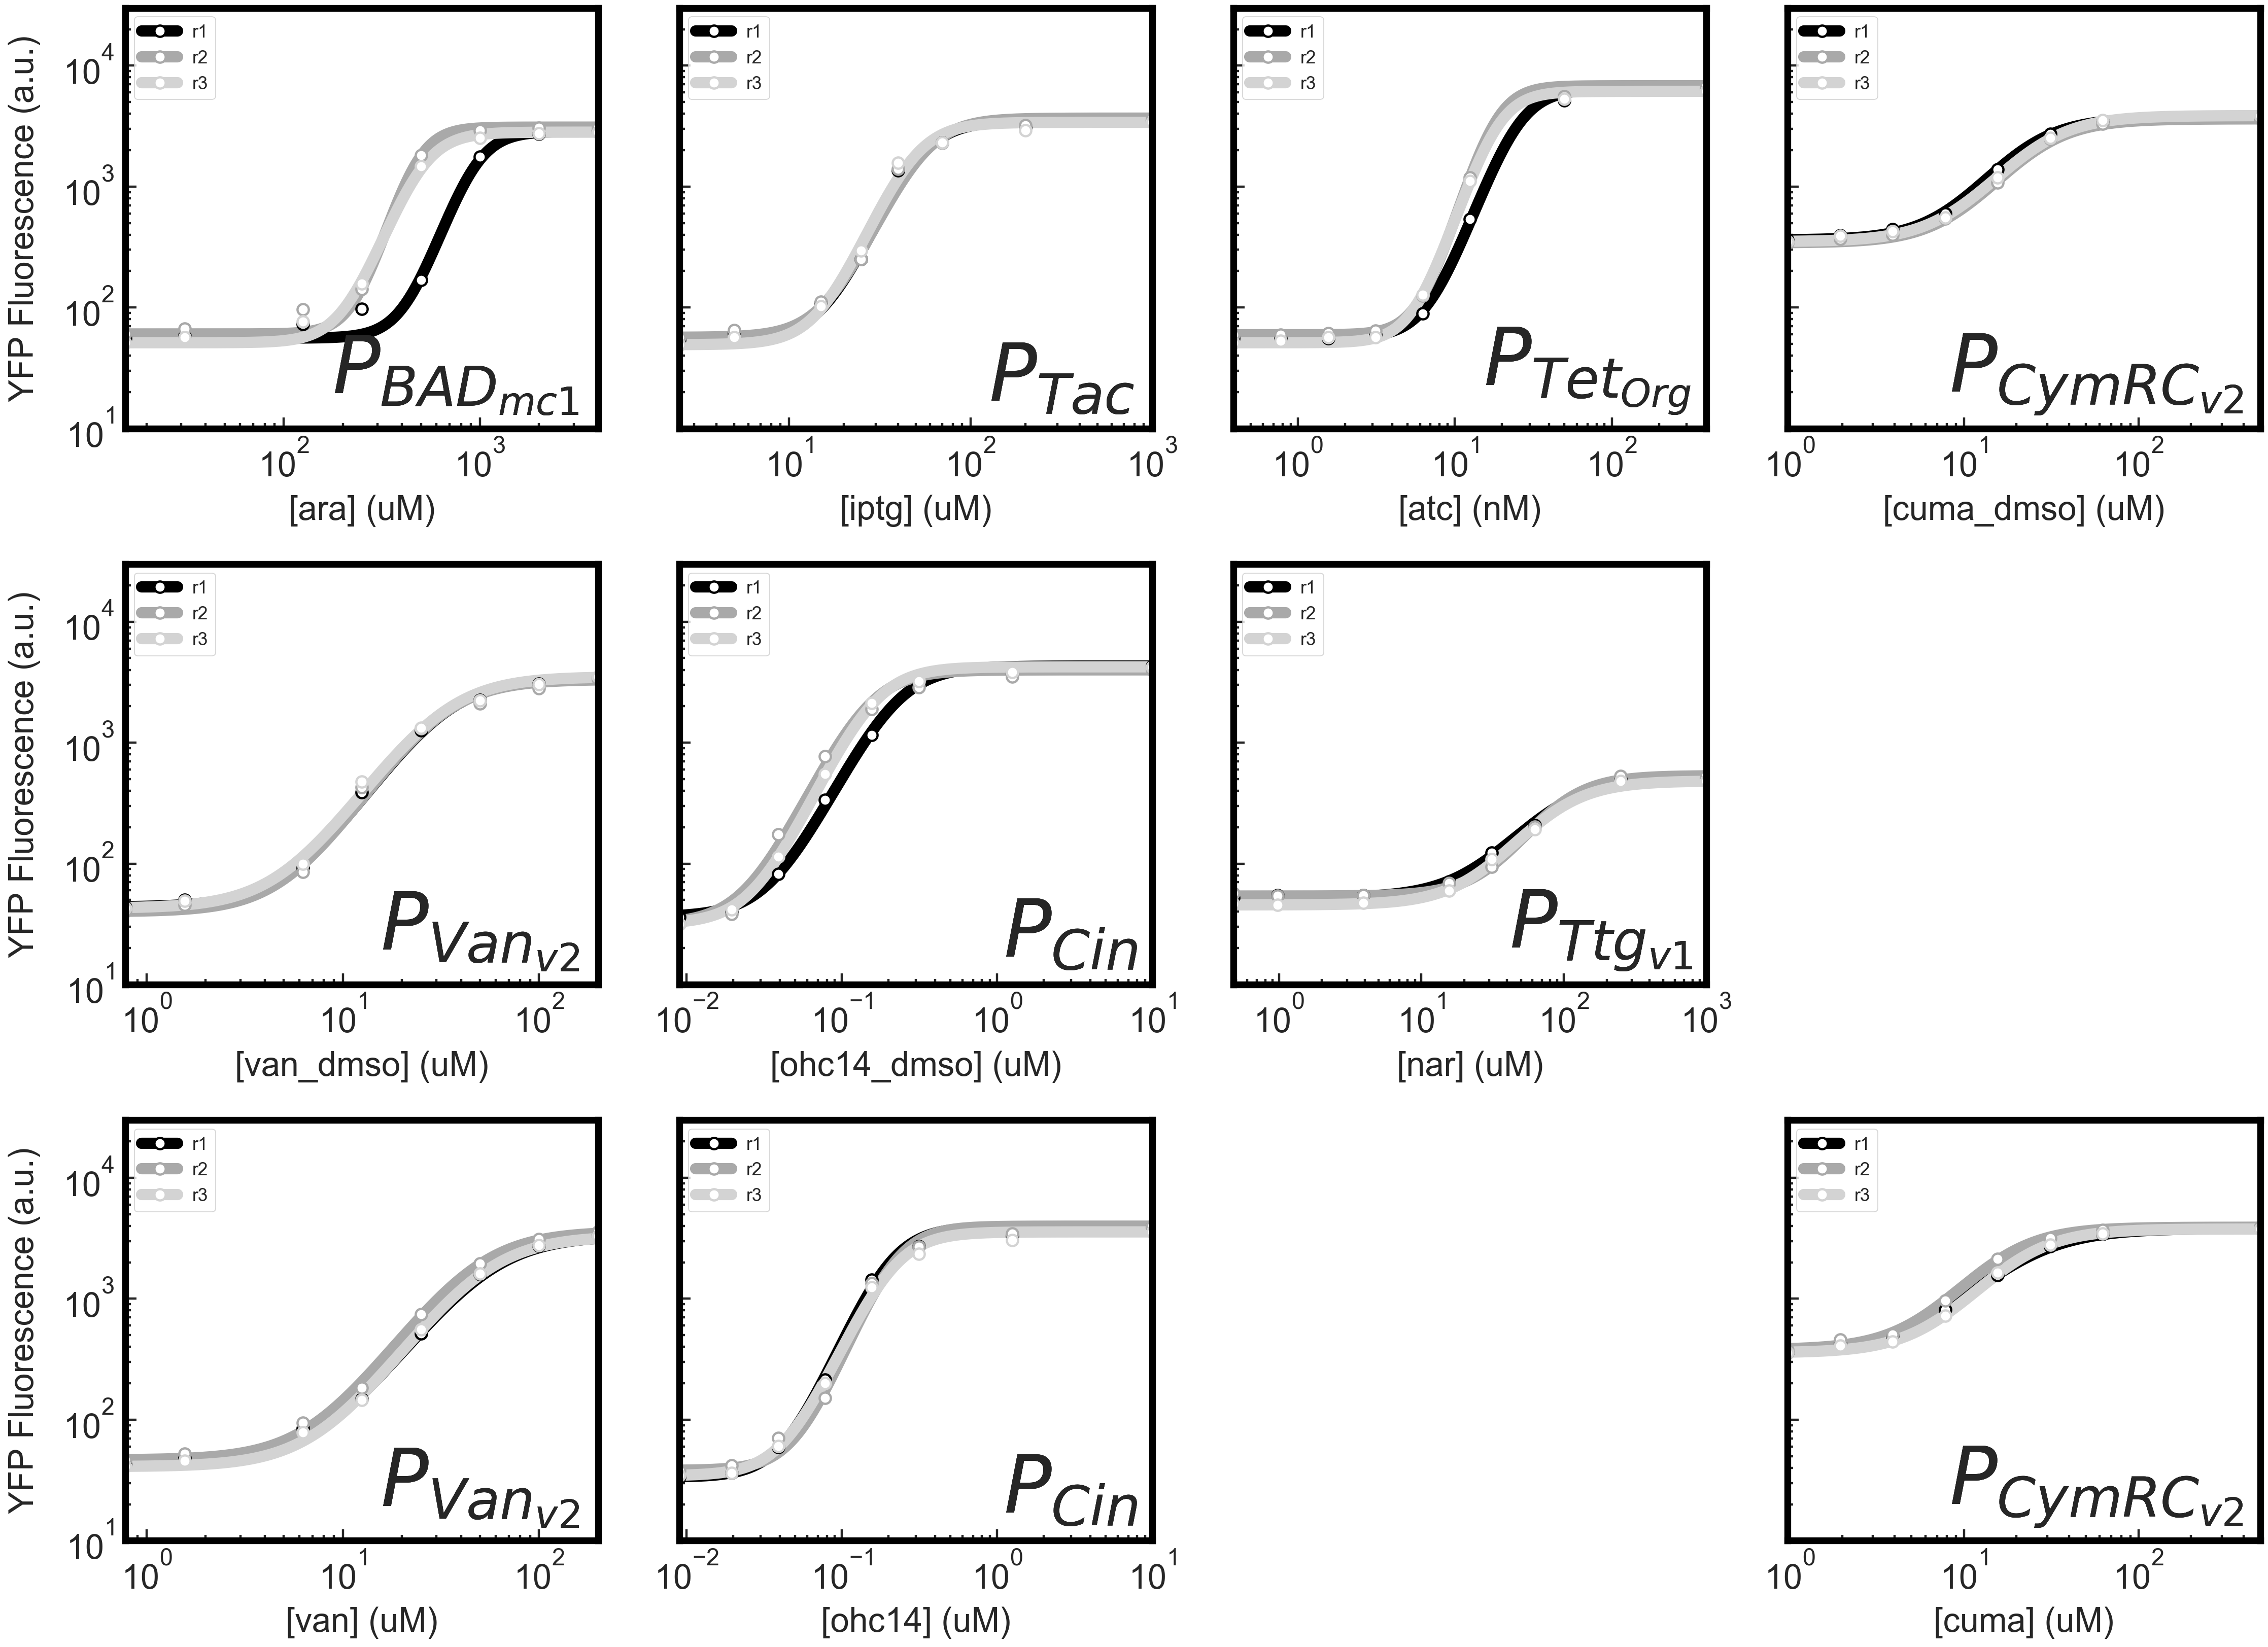

In [104]:
## plot transfer functions of each replicate

rows = 3 
cols = 4

fig_au, ax_au = plt.subplots(rows,cols, figsize=(cols*7.5,rows*7.5), sharey = 'row') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


tfs_au = dict()

for i in inducers_withdmso:
    tfs_au[i] = dict()
    for s in strains:
        tfs_au[i][s] = dict()
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax_au[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(6)
            for r in reps:

                ## transfer functions
                tfs_au[i][s][r] = build_transfer_functions([inducer_info_withdmso[i]['plot_conc']], # x data
                                                    [data['au'][s][r].tolist()], # y data
                                                    ['{} {}'.format(s,r)], # name
                                                           'activator') # kind

                ## scatter
                FP.scatter(tfs_au[i][s][r][0].inputs, tfs_au[i][s][r][0].outputs,
                                                            s = 100, zorder=2,
                                                                         marker = plot_info_withdmso[r][i]['marker'],
                                                                         c = plot_info_withdmso[r][i]['facecolor'],
                                                                         edgecolors = plot_info_withdmso[r][i]['edgecolor'], linewidths = 2)#,
    #                                                                     label = legend_names[strain_info[s]['parent']])

                ## fitting line
                xvals = np.logspace(np.log10(inducer_info_withdmso[i]['plot_conc'][0]),np.log10(inducer_info_withdmso[i]['plot_conc'][-1]), 1000) # x values for creating smooth line

                FP.plot(xvals, tfs_au[i][s][r][0].hill_eqn_act(xvals),
                                                  color = plot_info_withdmso[r][i]['linecolor'],
                                                  zorder = 1, linewidth = 10)#, label = legend_names[strain_info[s]['parent']])

                ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
                FP.plot([],[], marker = plot_info_withdmso[r][i]['marker'],
                                                  mec = plot_info_withdmso[r][i]['edgecolor'],
                                                  mew = 2,
                                                  mfc = plot_info_withdmso[r][i]['facecolor'],
                                                  ms = 10,
                                                  color = plot_info_withdmso[r][i]['linecolor'],
                                                  linewidth = 10, label = r)

                FP.set_yscale('log')
                FP.set_xscale('log')

                if fig_pos[i]['fig_col'] == 0:                
                    FP.set_ylabel('YFP Fluorescence (a.u.)', size = 30, labelpad = 20)

                FP.set_xlabel('[{}] (uM)'.format(i), size = 30, labelpad = 10)  

                if i == 'atc':
                    FP.set_xlabel('[{}] (nM)'.format(i), size = 30, labelpad = 10)

    #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
    #                                                                                size = 24, pad = 10)
                FP.tick_params(labelsize = 30, length = 10, width = 2, direction = 'in', pad = 10)
                FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')
                FP.set_ylim(10, 30000)
                FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])

                FP.yaxis.grid(False)
                FP.xaxis.grid(False)
                FP.legend(markerscale = 1, fontsize = 16, loc = 'upper left')
    #             FP.legend.legendHandles._legmarker.set_markersize(50)

                FP.text(max(tfs_au[i][s][r][0].inputs)/1.25, 12.5, strain_info_withdmso[s]['promoter'], 
                                                                      verticalalignment = 'bottom', horizontalalignment = 'right', 
                                                                      fontsize = 70)


# # gets rid of empty plots
fig_au.delaxes(ax_au[1,3]) # zero indexing
fig_au.delaxes(ax_au[2,2]) # zero indexing


In [105]:
# fig_au.savefig('EcN_Sensors_Inducer_x_AU_EachReplicate.pdf', bbox_inches = "tight", transparent = True)

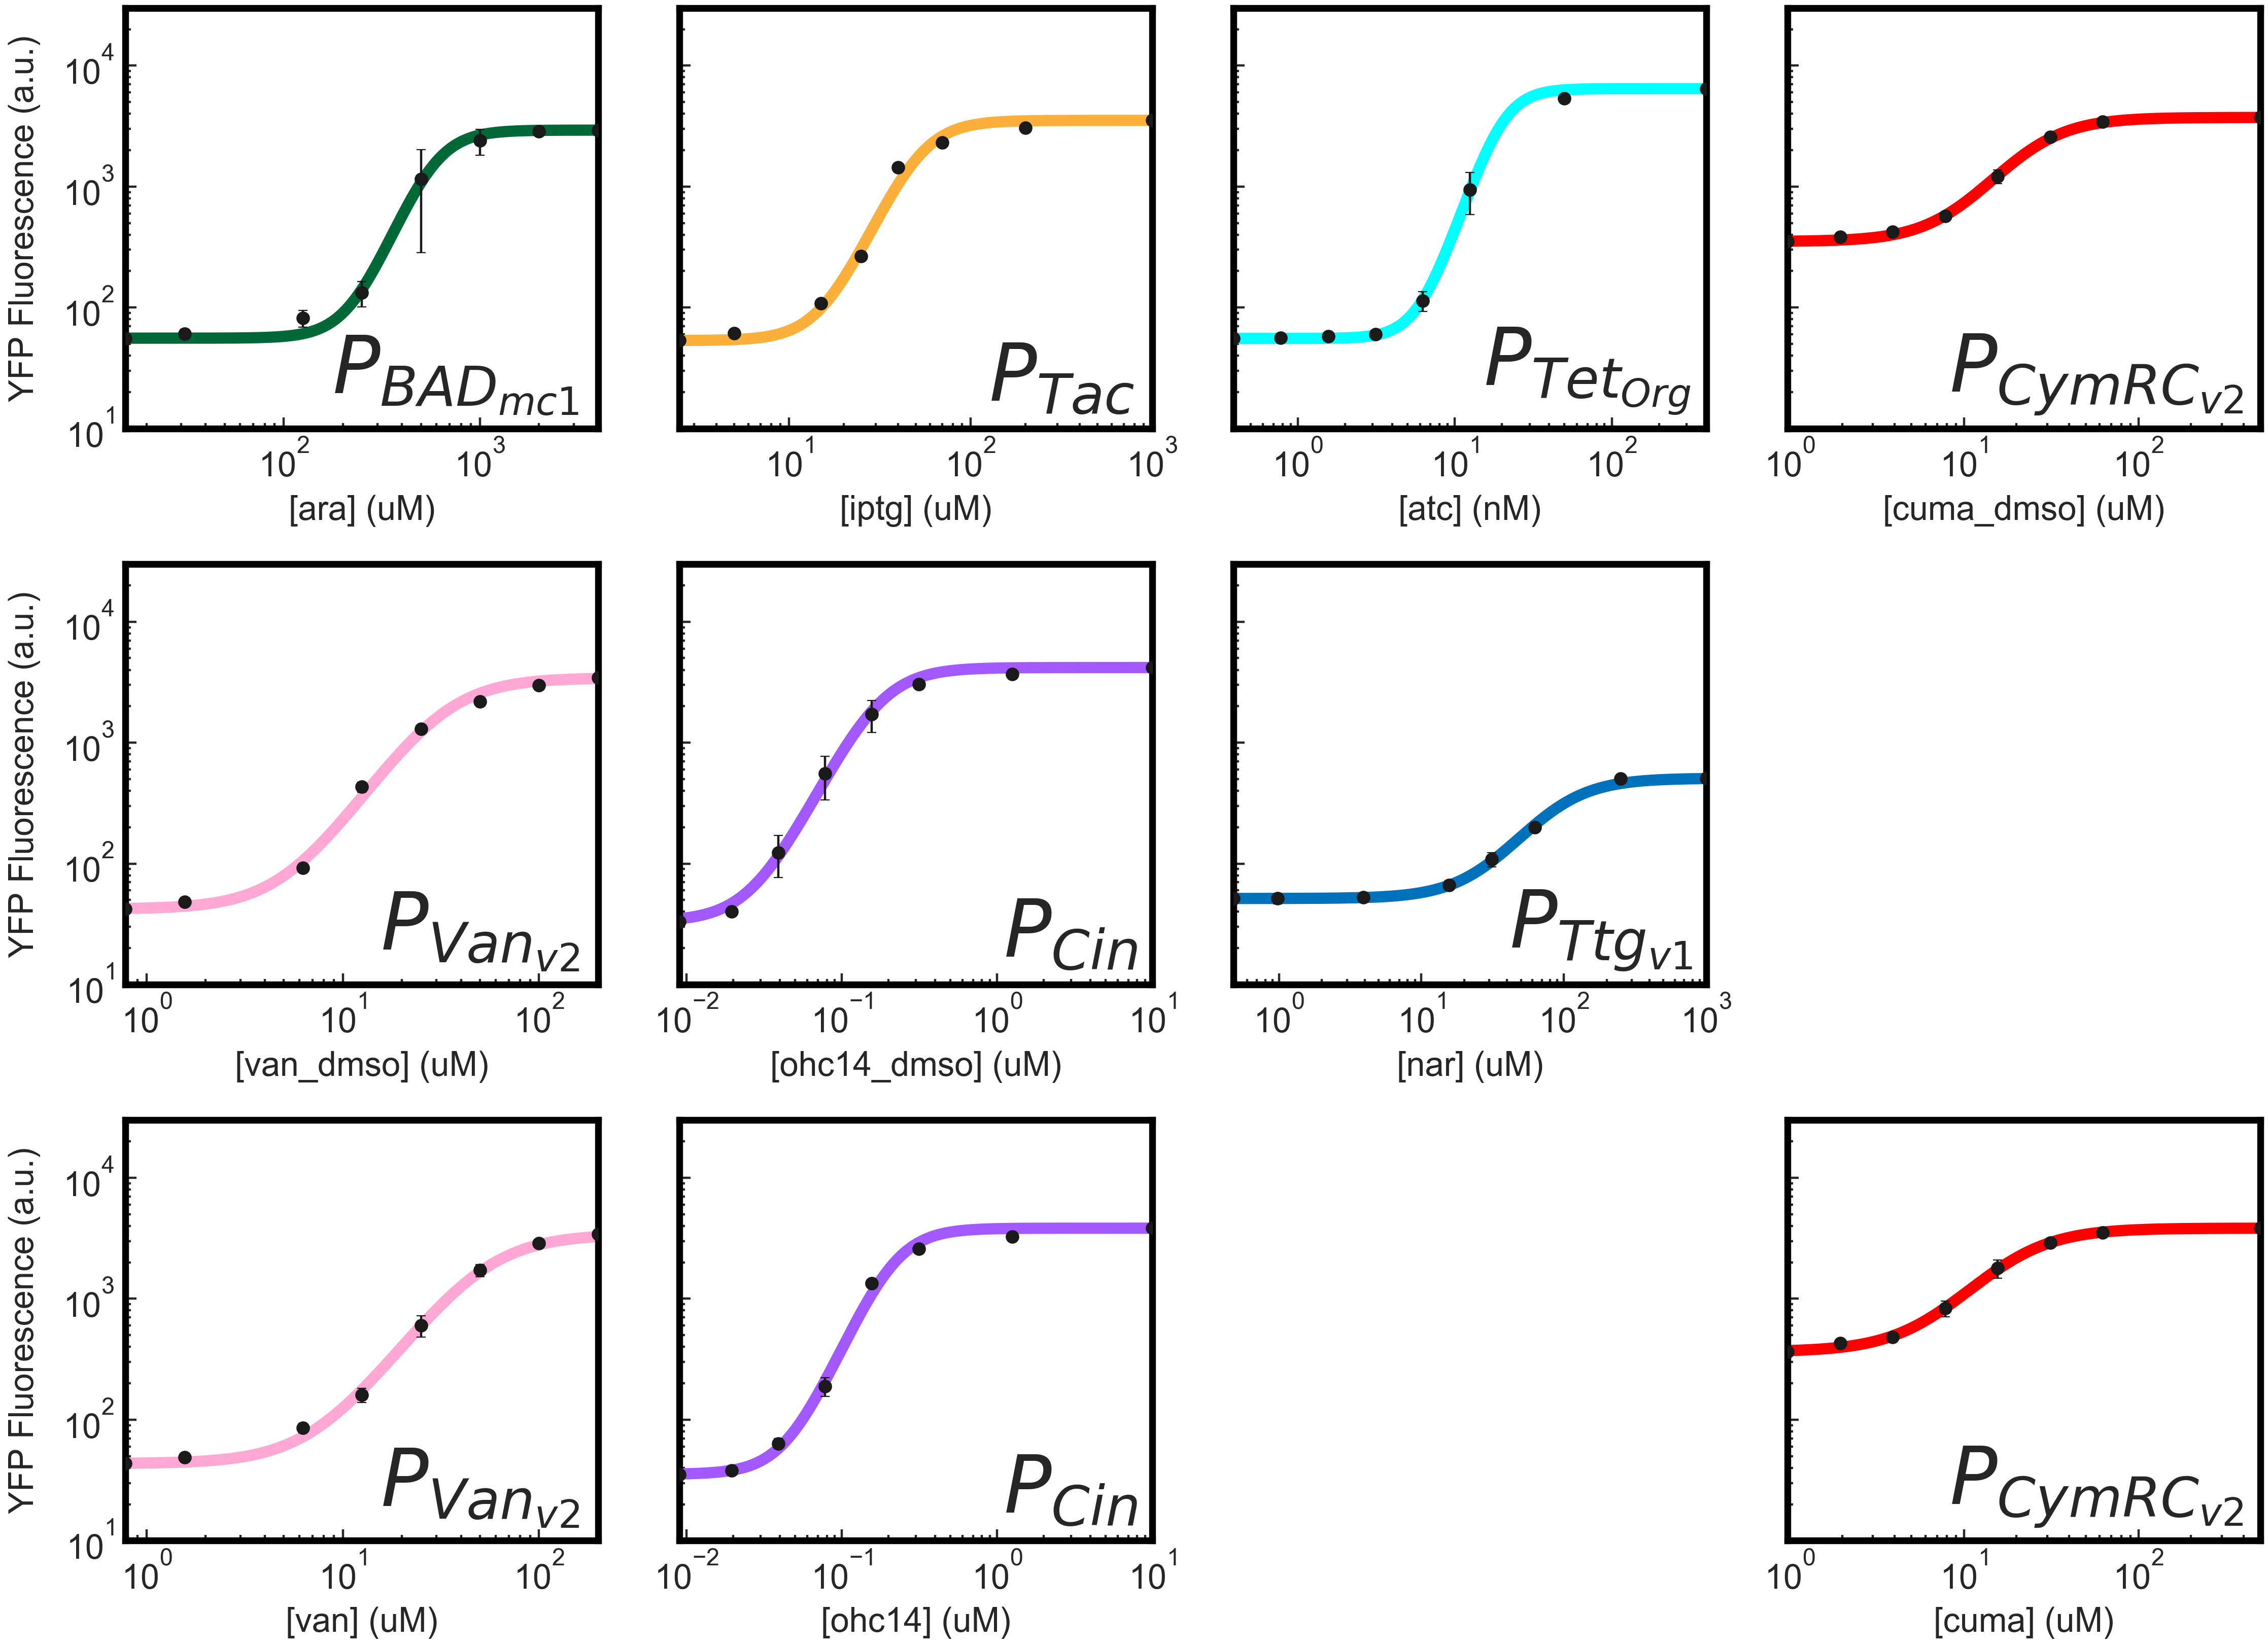

In [106]:
## plot transfer functions with error bars

rows = 3 
cols = 4

fig2_au, ax2_au = plt.subplots(rows,cols, figsize=(cols*7.5,rows*7.5), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


tfs_means_au = dict()

for i in inducers_withdmso:
    tfs_means_au[i] = dict()
    for s in strains:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax2_au[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(6)

            ## transfer functions
            tfs_means_au[i][s] = build_transfer_functions([inducer_info_withdmso[i]['plot_conc']], # x data
                                                [means['au'][s].tolist()], # y data
                                                [s], # name
                                                 'activator') # kind
        
            ## scatter
            FP.scatter(tfs_means_au[i][s][0].inputs, tfs_means_au[i][s][0].outputs,
                                                    s = 100, zorder=3,
                                                     marker = 'o',
                                                     c = 'k',
                                                     edgecolors = 'k', linewidths = 2)#,
            
            
            ## errorbars
            FP.errorbar(tfs_means_au[i][s][0].inputs, tfs_means_au[i][s][0].outputs, yerr = stdevs['au'][s],
                                                        zorder=2, fmt = 'none', # plots just error bars, no marker or line
                                                        c = 'k', elinewidth = 2, capsize = 4)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

            ## fitting line
            xvals = np.logspace(np.log10(inducer_info_withdmso[i]['plot_conc'][0]),np.log10(inducer_info_withdmso[i]['plot_conc'][-1]), 1000) # x values for creating smooth line

            FP.plot(xvals, tfs_means_au[i][s][0].hill_eqn_act(xvals),
                                              color = strain_info_withdmso[s]['color'],
                                              zorder = 1, linewidth = 10)#, label = legend_names[strain_info[s]['parent']])

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

            if fig_pos[i]['fig_col'] == 0:                
                FP.set_ylabel('YFP Fluorescence (a.u.)', size = 30, labelpad = 20)

            FP.set_xlabel('[{}] (uM)'.format(i), size = 30, labelpad = 10)  

            if i == 'atc':
                FP.set_xlabel('[{}] (nM)'.format(i), size = 30, labelpad = 10)

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)
            FP.tick_params(labelsize = 30, length = 10, width = 2, direction = 'in', pad = 10)
            FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')
            FP.set_ylim(10,30000)
            FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])

            FP.yaxis.grid(False)
            FP.xaxis.grid(False)
#             FP.legend(markerscale = 1, fontsize = 16)
#             FP.legend.legendHandles._legmarker.set_markersize(50)

            FP.text(max(tfs_means_au[i][s][0].inputs)/1.25, 12.5, strain_info_withdmso[s]['promoter'], 
                                                                  verticalalignment = 'bottom', horizontalalignment = 'right', 
                                                                  fontsize = 70)


# # gets rid of empty plots
fig2_au.delaxes(ax2_au[1,3]) # zero indexing
fig2_au.delaxes(ax2_au[2,2]) # zero indexing


In [107]:
# fig2_au.savefig('EcN_Sensors_Inducer_x_AU_ErrorBars.pdf', bbox_inches = "tight", transparent = True)

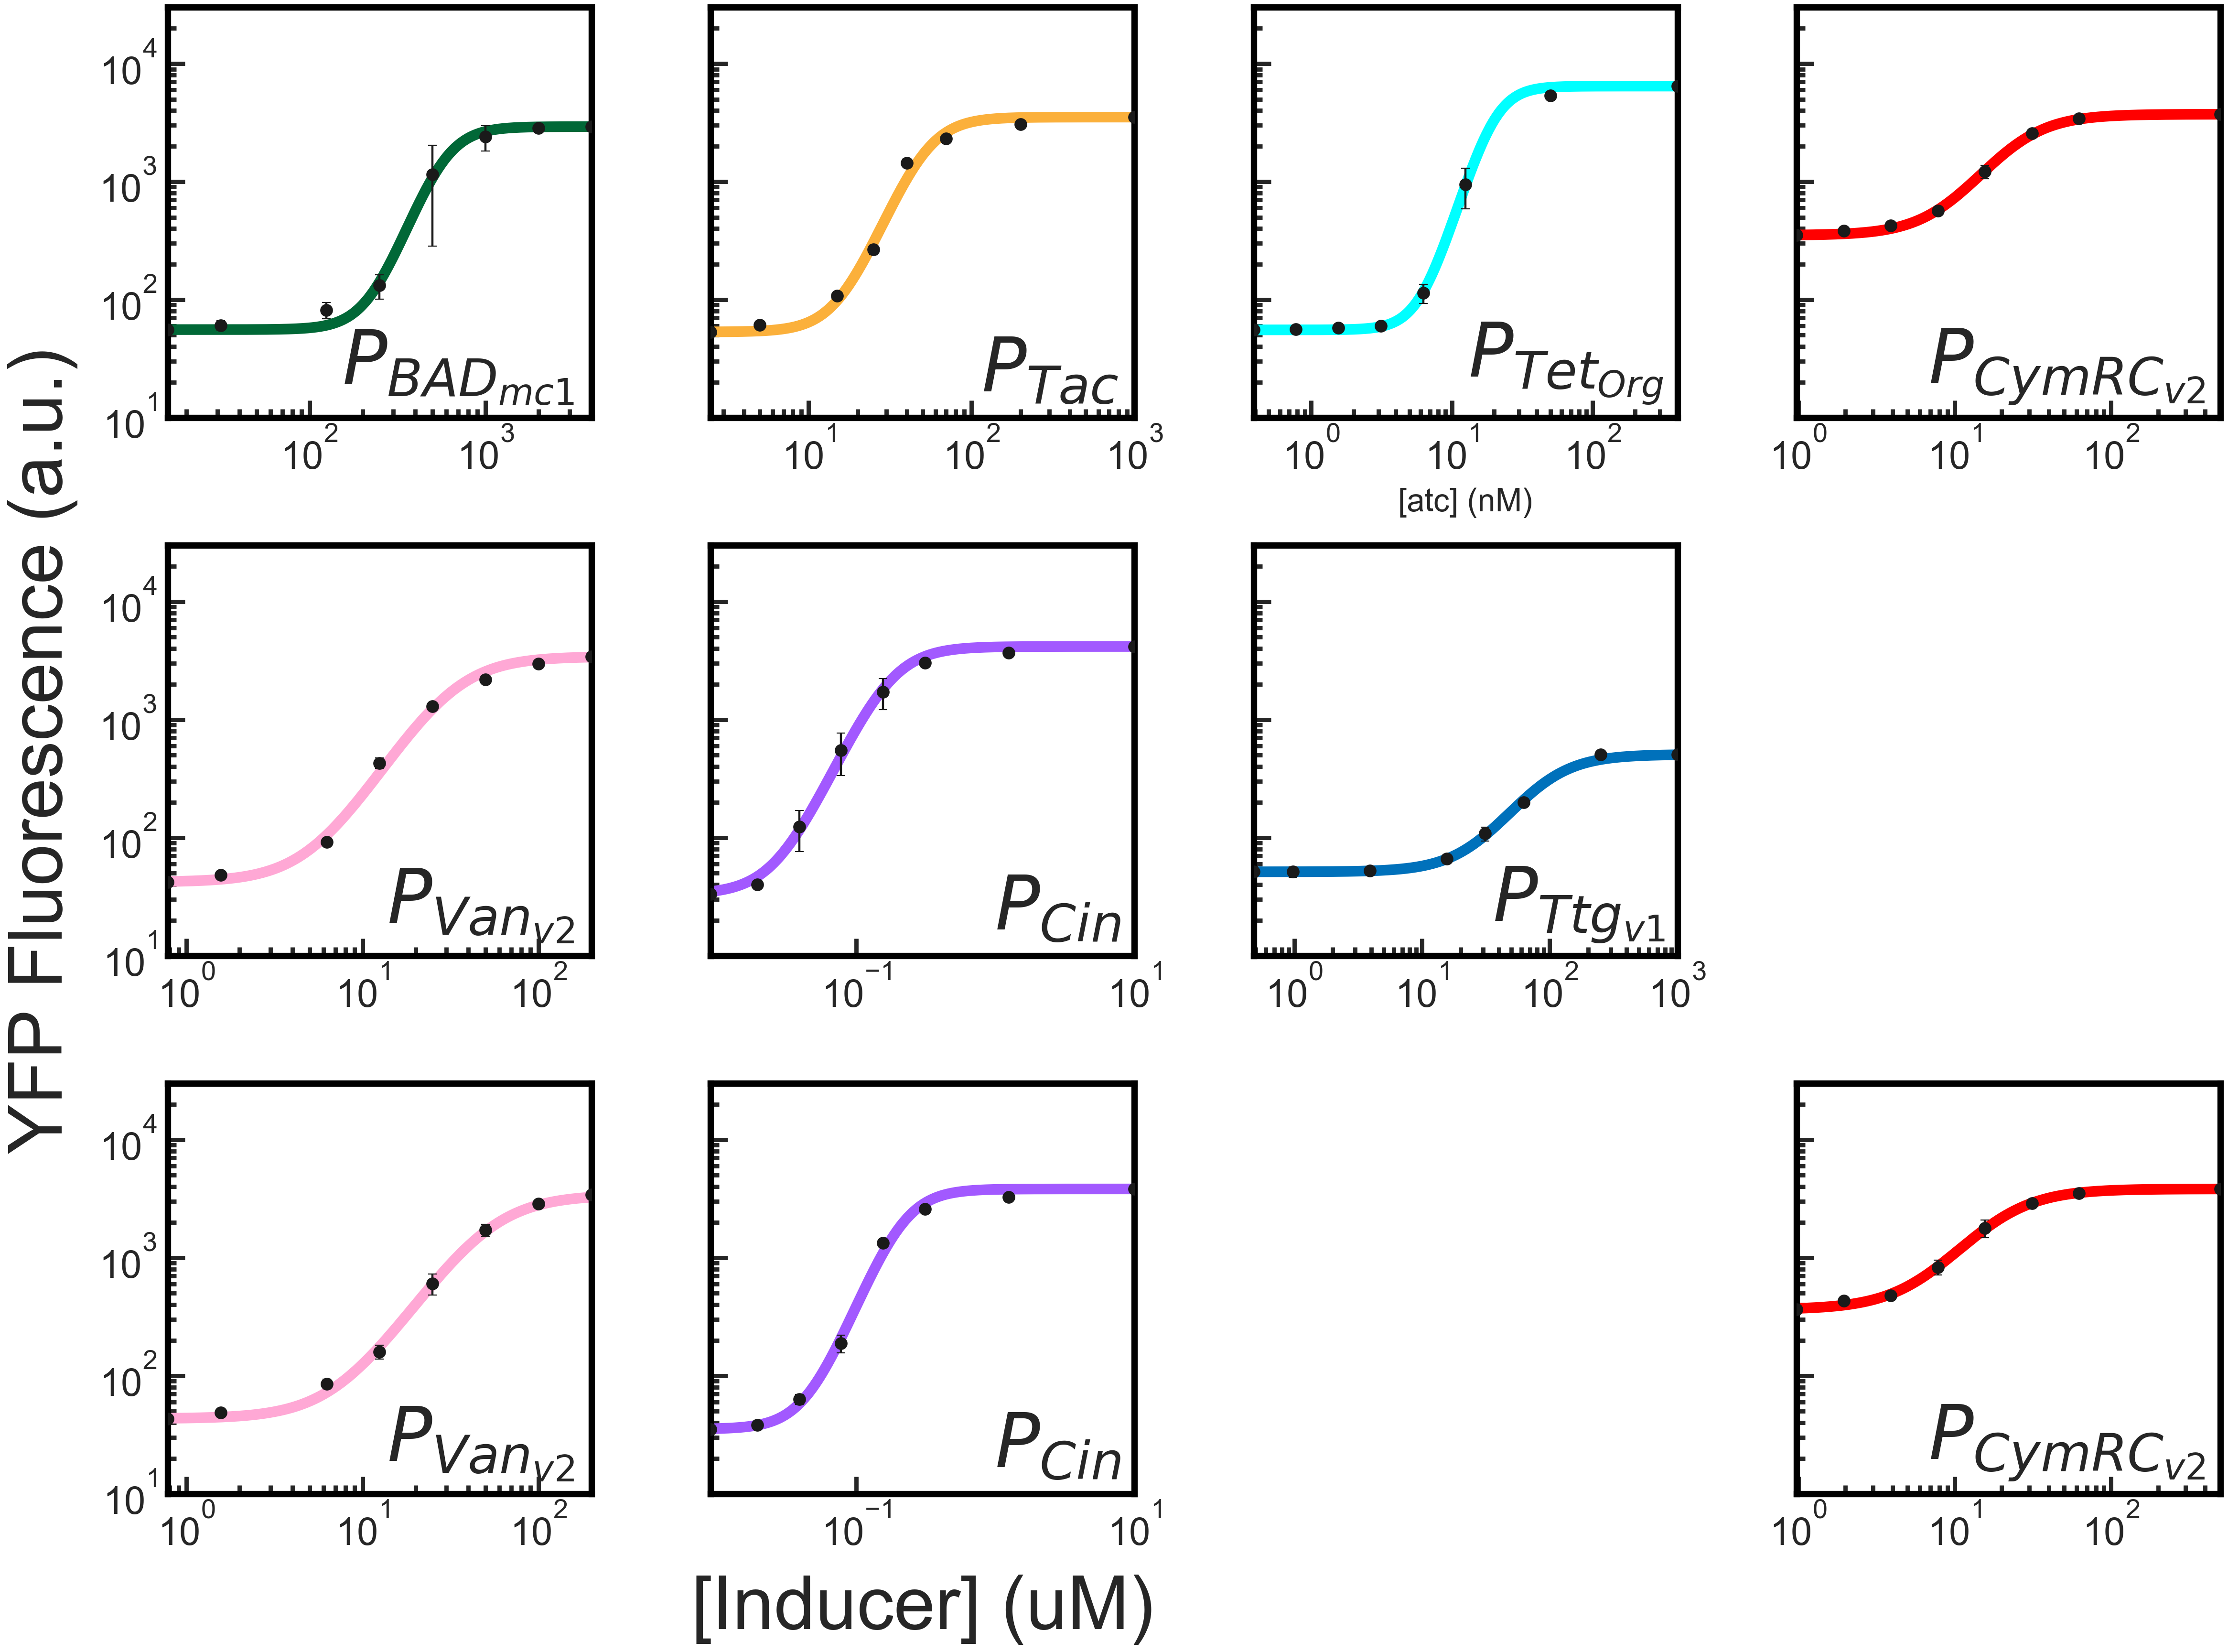

In [108]:
## plot transfer functions with error bars
## for presentations with modifications to spacing and size of labels

rows = 3 
cols = 4

fig2_pres, ax2_pres = plt.subplots(rows,cols, figsize=(cols*7.5,rows*7.5), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 10, h_pad = 10, w_pad = 10) #tidies up spacing between plots


tfs_means_au = dict()

for i in inducers_withdmso:
    tfs_means_au[i] = dict()
    for s in strains:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax2_pres[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(6)

            ## transfer functions
            tfs_means_au[i][s] = build_transfer_functions([inducer_info_withdmso[i]['plot_conc']], # x data
                                                [means['au'][s].tolist()], # y data
                                                [s], # name
                                                'activator') # kind
        
            ## scatter
            FP.scatter(tfs_means_au[i][s][0].inputs, tfs_means_au[i][s][0].outputs,
                                                    s = 100, zorder=3,
                                                     marker = 'o',
                                                     c = 'k',
                                                     edgecolors = 'k', linewidths = 2)#,
            
            
            ## errorbars
            FP.errorbar(tfs_means_au[i][s][0].inputs, tfs_means_au[i][s][0].outputs, yerr = stdevs['au'][s],
                                                        zorder=2, fmt = 'none', # plots just error bars, no marker or line
                                                        c = 'k', elinewidth = 2, capsize = 4)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

            ## fitting line
            xvals = np.logspace(np.log10(inducer_info_withdmso[i]['plot_conc'][0]),np.log10(inducer_info_withdmso[i]['plot_conc'][-1]), 1000) # x values for creating smooth line

            FP.plot(xvals, tfs_means_au[i][s][0].hill_eqn_act(xvals),
                                              color = strain_info_withdmso[s]['color'],
                                              zorder = 1, linewidth = 10)#, label = legend_names[strain_info[s]['parent']])

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

            ax2_pres[1][0].set_ylabel('YFP Fluorescence (a.u.)', size = 70, labelpad = 20)

            ax2_pres[2][1].set_xlabel('[Inducer] (uM)'.format(i), size = 70, labelpad = 20)  

            if i == 'atc':
                FP.set_xlabel('[{}] (nM)'.format(i), size = 30, labelpad = 10)

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)
            FP.tick_params(labelsize = 36, length = 16, width = 4, direction = 'in', pad = 10)
            FP.tick_params(which='minor', length = 8, width = 4, direction = 'in')
            FP.set_ylim(10,30000)
            FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])

            FP.yaxis.grid(False)
            FP.xaxis.grid(False)
#             FP.legend(markerscale = 1, fontsize = 16)
#             FP.legend.legendHandles._legmarker.set_markersize(50)

            FP.text(max(tfs_means_au[i][s][0].inputs)/1.25, 12.5, strain_info_withdmso[s]['promoter'], 
                                                                  verticalalignment = 'bottom', horizontalalignment = 'right', 
                                                                  fontsize = 70)


# # gets rid of empty plots
fig2_pres.delaxes(ax2_pres[1,3]) # zero indexing
fig2_pres.delaxes(ax2_pres[2,2]) # zero indexing


In [109]:
# fig2_pres.savefig('EcN_Sensors_Inducer_x_AU_ErrorBars_lesslabels.pdf', bbox_inches = "tight", transparent = True)


## [inducer] x RPU

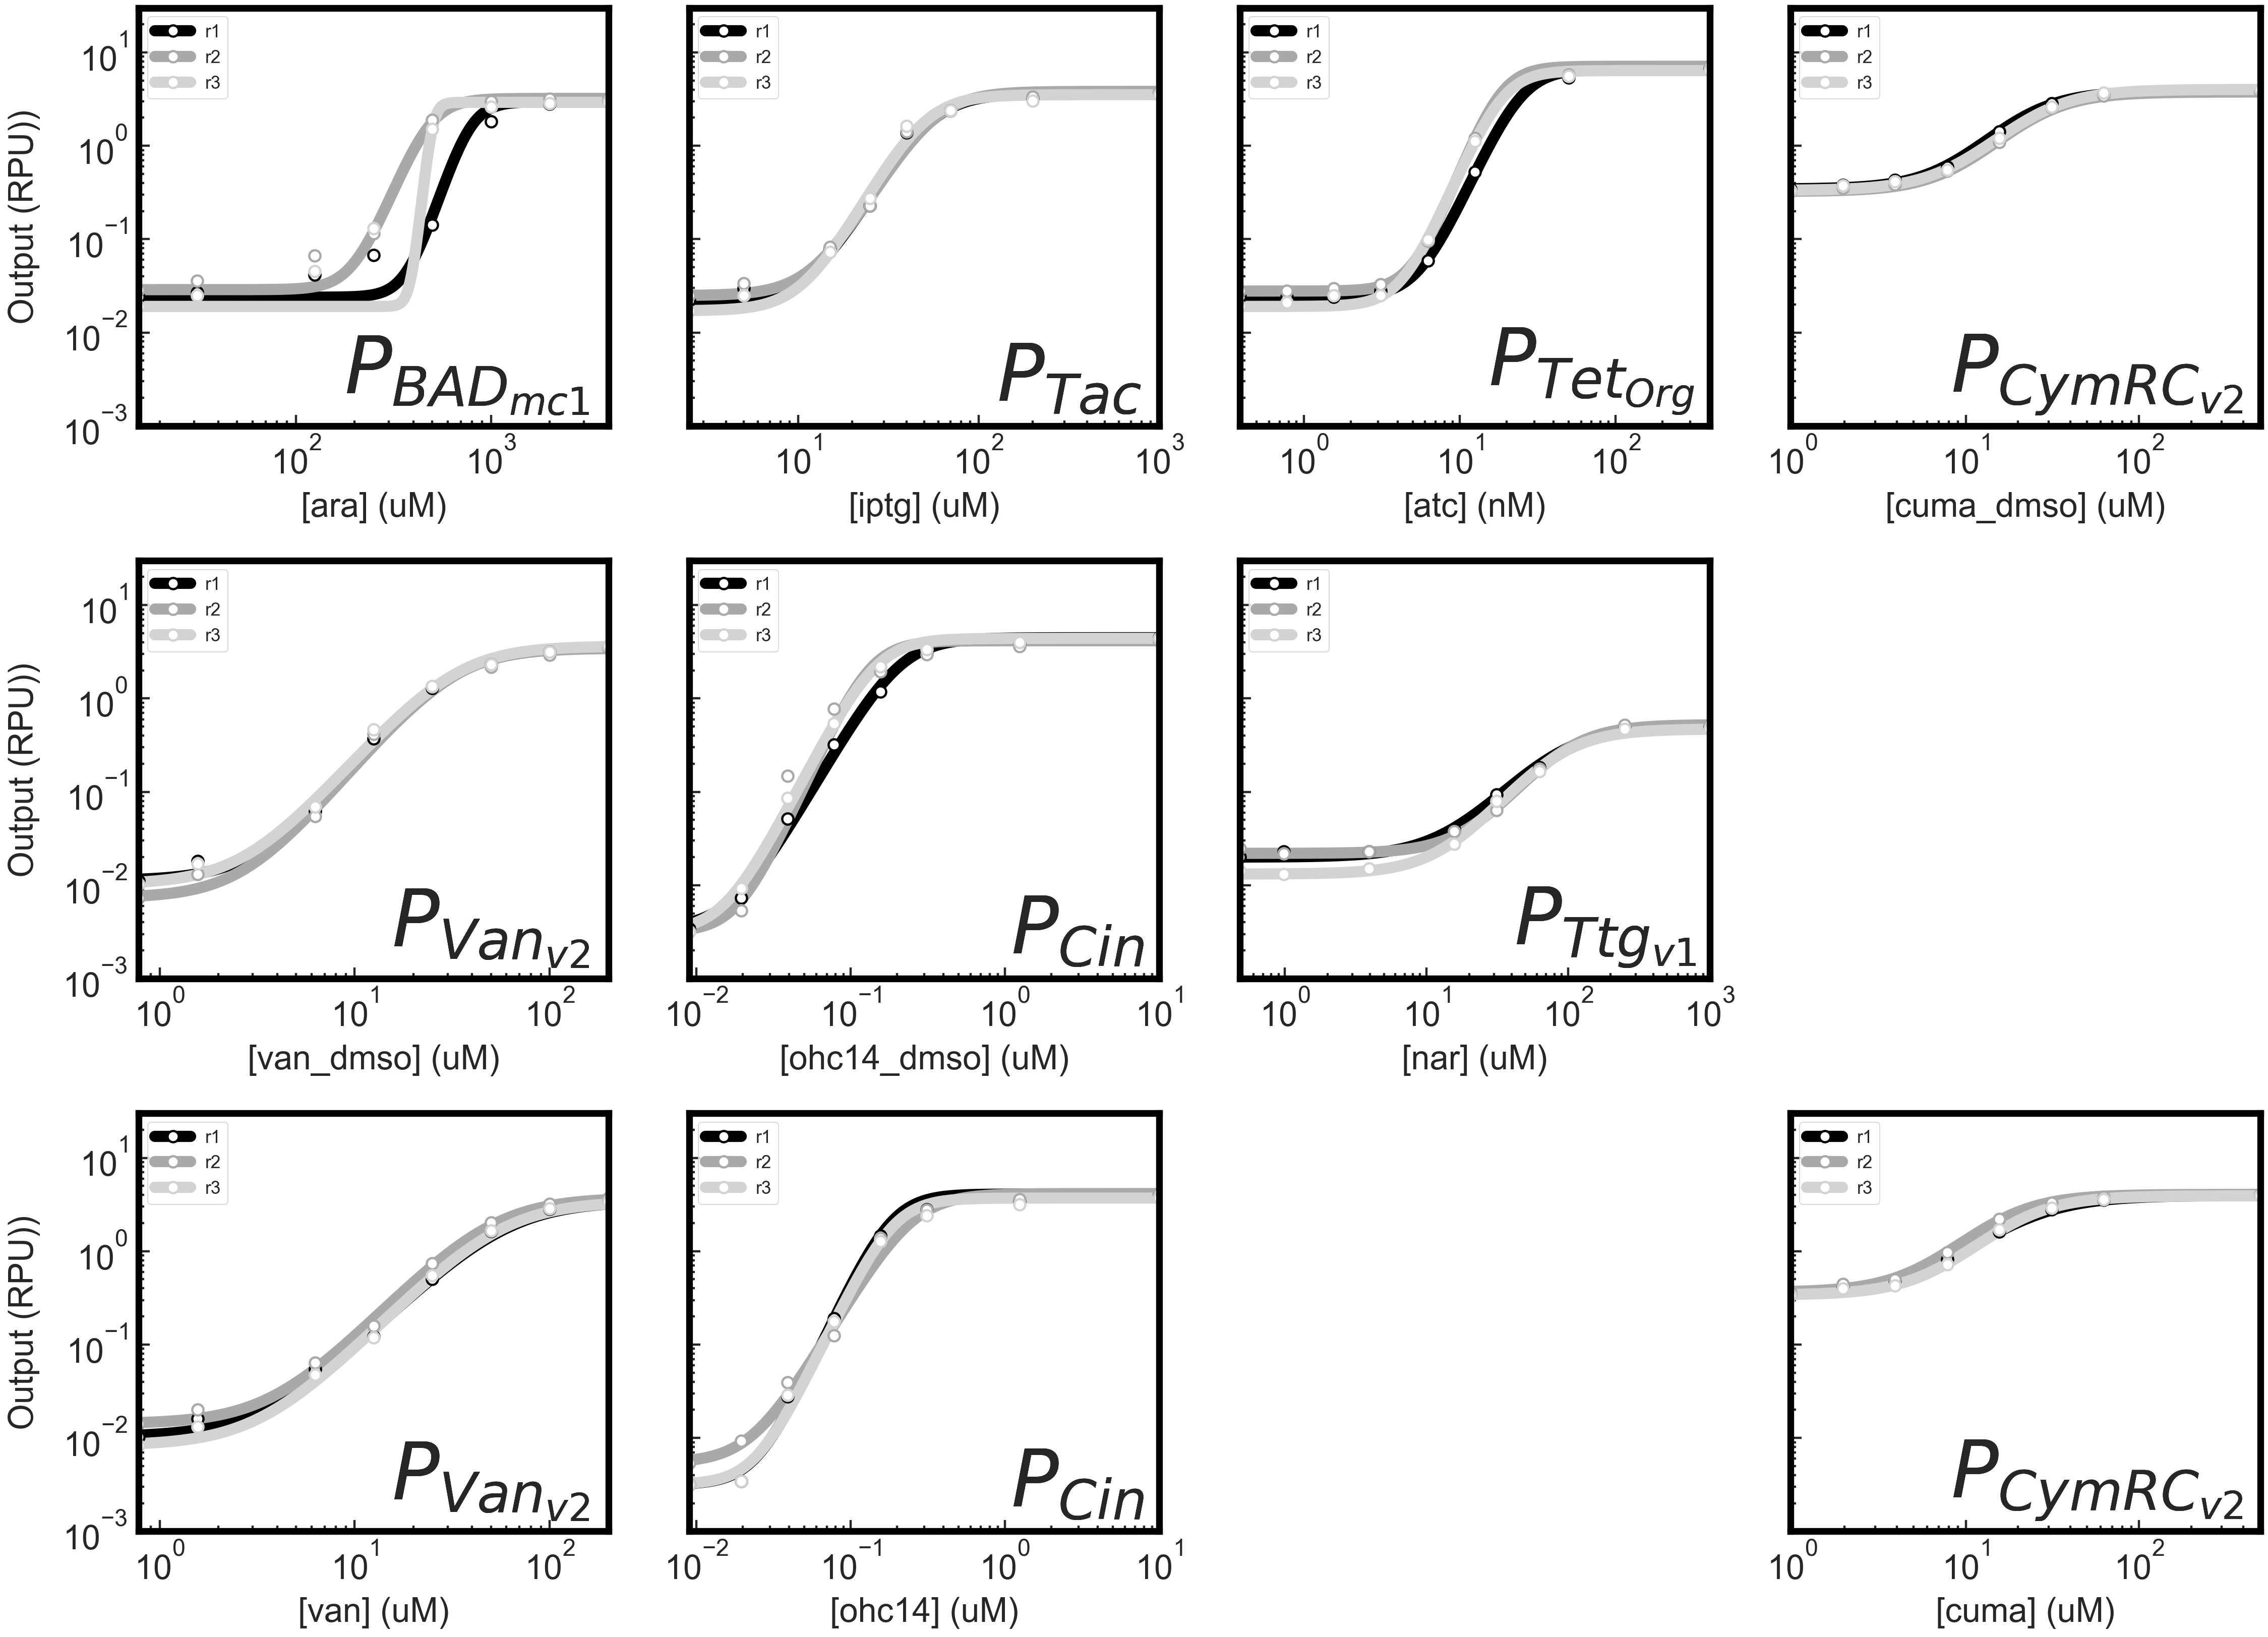

In [110]:
## plot transfer functions of each replicate

rows = 3 
cols = 4

fig_RPU, ax_RPU = plt.subplots(rows,cols, figsize=(cols*7.5,rows*7.5), sharey = 'row') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


tfs_RPU = dict()

for i in inducers_withdmso:
    tfs_RPU[i] = dict()
    for s in strains:
        tfs_RPU[i][s] = dict()
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax_RPU[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(6)
            for r in reps:

                ## transfer functions
                tfs_RPU[i][s][r] = build_transfer_functions([inducer_info_withdmso[i]['plot_conc']], # x data
                                                    [r123_RPU[s][r].tolist()], # y data
                                                    ['{} {}'.format(s,r)], # name
                                                    'activator') # kind

                ## scatter
                FP.scatter(tfs_RPU[i][s][r][0].inputs, tfs_RPU[i][s][r][0].outputs,
                                                            s = 100, zorder=2,
                                                                         marker = plot_info_withdmso[r][i]['marker'],
                                                                         c = plot_info_withdmso[r][i]['facecolor'],
                                                                         edgecolors = plot_info_withdmso[r][i]['edgecolor'], linewidths = 2)#,
    #                                                                     label = legend_names[strain_info[s]['parent']])

                ## fitting line
                xvals = np.logspace(np.log10(inducer_info_withdmso[i]['plot_conc'][0]),np.log10(inducer_info_withdmso[i]['plot_conc'][-1]), 1000) # x values for creating smooth line

                FP.plot(xvals, tfs_RPU[i][s][r][0].hill_eqn_act(xvals),
                                                  color = plot_info_withdmso[r][i]['linecolor'],
                                                  zorder = 1, linewidth = 10)#, label = legend_names[strain_info[s]['parent']])

                ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
                FP.plot([],[], marker = plot_info_withdmso[r][i]['marker'],
                                                  mec = plot_info_withdmso[r][i]['edgecolor'],
                                                  mew = 2,
                                                  mfc = plot_info_withdmso[r][i]['facecolor'],
                                                  ms = 10,
                                                  color = plot_info_withdmso[r][i]['linecolor'],
                                                  linewidth = 10, label = r)

                FP.set_yscale('log')
                FP.set_xscale('log')

                if fig_pos[i]['fig_col'] == 0:                
                    FP.set_ylabel('Output (RPU))', size = 30, labelpad = 20)

                FP.set_xlabel('[{}] (uM)'.format(i), size = 30, labelpad = 10)  

                if i == 'atc':
                    FP.set_xlabel('[{}] (nM)'.format(i), size = 30, labelpad = 10)

    #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
    #                                                                                size = 24, pad = 10)
                FP.tick_params(labelsize = 30, length = 10, width = 2, direction = 'in', pad = 10)
                FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')
                FP.set_ylim(.001, 30)
                FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])

                FP.yaxis.grid(False)
                FP.xaxis.grid(False)
                FP.legend(markerscale = 1, fontsize = 16, loc = 'upper left')
    #             FP.legend.legendHandles._legmarker.set_markersize(50)

                FP.text(max(tfs_RPU[i][s][r][0].inputs)/1.25, .00125, strain_info_withdmso[s]['promoter'], 
                                                                      verticalalignment = 'bottom', horizontalalignment = 'right', 
                                                                      fontsize = 70)


# # gets rid of empty plots
fig_RPU.delaxes(ax_RPU[1,3]) # zero indexing
fig_RPU.delaxes(ax_RPU[2,2]) # zero indexing


In [111]:
# fig_RPU.savefig('EcN_Sensors_EachReplicate_RPU_Pcin_adjusted.pdf', bbox_inches = "tight", transparent = True)


In [112]:
[[0.0001]+(pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist()[1:]]

[[0.0001, 0.00078, 0.00156, 0.00312, 0.00625, 0.0125, 0.05, 0.4]]

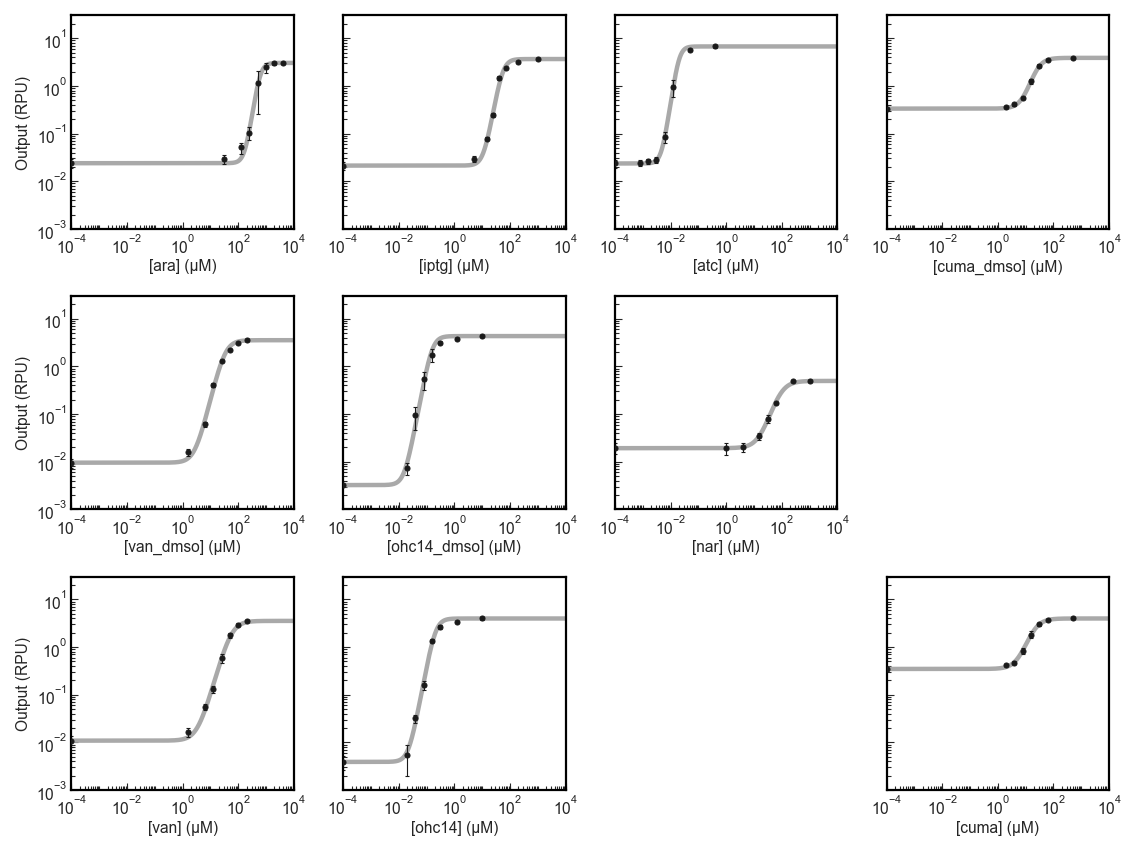

In [113]:
## plot transfer functions with error bars

rows = 3
cols = 4

fig2_RPU, ax2_RPU = plt.subplots(rows,cols, figsize=(7.2,7.2/cols*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 1, h_pad = 1, w_pad = 1) #tidies up spacing between plots


tfs_means_RPU = dict()

for i in inducers_withdmso:
    tfs_means_RPU[i] = dict()
    for s in strains:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax2_RPU[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1)

            ## transfer functions
            ## artificially set low concentration to 0.0001 for figures and ease of showing broken axis
                                                           
            if i == 'atc': # need to adjust atc concentrations to uM instead of nM
                
                tfs_means_RPU[i][s] = build_transfer_functions([[0.0001]+(pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist()[1:]], # x data
                                                    [means_RPU[s].tolist()], # y data
                                                    [s], # name
                                                    'activator') # kind
            else:
                tfs_means_RPU[i][s] = build_transfer_functions([[0.0001]+inducer_info_withdmso[i]['plot_conc'][1:]], # x data
                                                    [means_RPU[s].tolist()], # y data
                                                    [s], # name
                                                    'activator') # kind
        
            ## scatter
            FP.scatter(tfs_means_RPU[i][s][0].inputs, tfs_means_RPU[i][s][0].outputs,
                                                    s = 5, zorder=3,
                                                     marker = 'o',
                                                     c = 'k',
                                                     edgecolors = 'k', linewidths = 0.5)#,
            
            
            ## errorbars
            FP.errorbar(tfs_means_RPU[i][s][0].inputs, tfs_means_RPU[i][s][0].outputs, yerr = stdevs_RPU[s],
                        zorder=2, fmt = 'none', # plots just error bars, no marker or line
                        c = 'k',                                 
                        elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

            ## fitting line
            xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000) # x values for creating smooth line

            FP.plot(xvals, tfs_means_RPU[i][s][0].hill_eqn_act(xvals),
                                              color = 'darkgrey',
                                              zorder = 1, linewidth = 2)#, label = legend_names[strain_info[s]['parent']])

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

            if fig_pos[i]['fig_col'] == 0:                
                FP.set_ylabel('Output (RPU)', size = 7, labelpad = 2)

            FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)

            ## set x ticks
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
            FP.xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            FP.xaxis.set_minor_locator(x_minor)
            FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
            FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
            FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
            FP.set_ylim(.001,30)
            FP.set_xlim(0.0001, 10000)

            FP.yaxis.grid(False)
            FP.xaxis.grid(False)
#             FP.legend(markerscale = 1, fontsize = 16)
#             FP.legend.legendHandles._legmarker.set_markersize(50)

#             FP.text(8000, .00125, strain_info_withdmso[s]['promoter'], 
#                                   va = 'bottom', ha = 'right', 
#                                   fontsize = 14)


# # gets rid of empty plots
fig2_RPU.delaxes(ax2_RPU[1,3]) # zero indexing
fig2_RPU.delaxes(ax2_RPU[2,2]) # zero indexing


In [114]:
# fig2_RPU.savefig('EcN_Sensors_TFs_RPU_ErrorBars_Pcin_adjusted_darkgrey.pdf', bbox_inches = "tight", transparent = True)


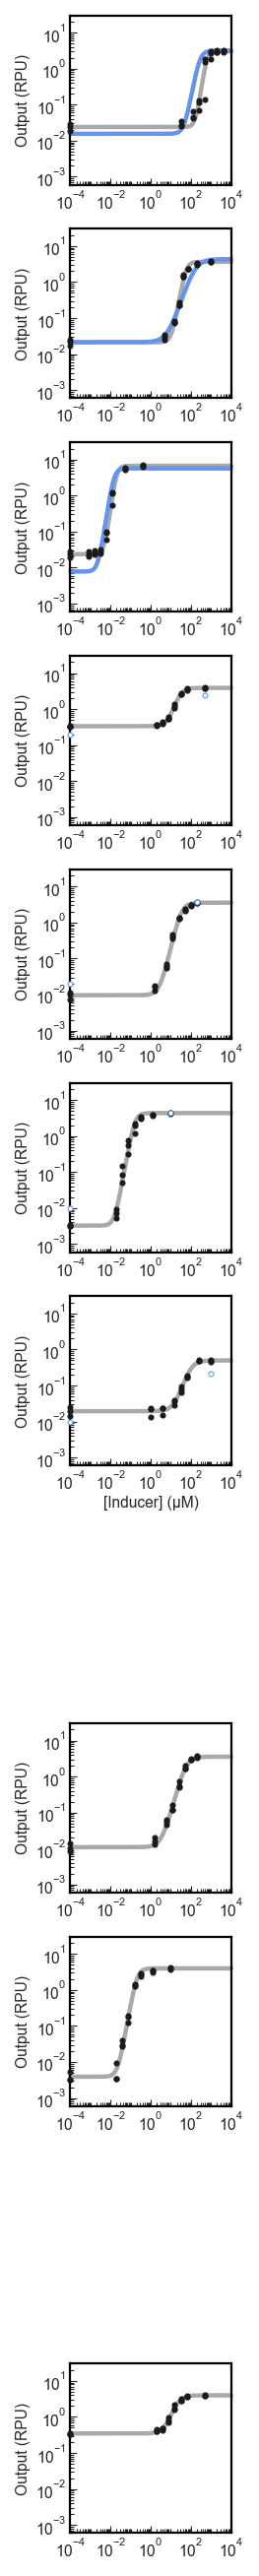

In [115]:
rows = 12
cols = 1
fig2_RPU_1col, ax2_RPU_1col = plt.subplots(rows,cols, figsize=(1.69*cols,1.38*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(h_pad = 0) #tidies up spacing between plots

YJP_sensors = {'iptg':{'data': [0.021431748, 0.022688664, 0.039392193, 0.072640679, 0.136195985, 0.394282562, 0.582313422, 1.068757518, 1.548874634, 3.665975836, 4.046492331, 4.332246466],
                      'conc': [0.1, 1, 5, 10, 20, 40, 60, 80, 100, 200, 400, 500]},
                'atc':{'data': [0.00888889, 0.00888889, 0.00777778, 0.00888889, 0.01333333, 1.387692307, 4.903931627, 5.689401707],
#                       'conc': [0.002160387, 0.021603871, 0.216038714, 1.080193571, 2.160387141, 10.80193571, 21.60387141, 43.20774283]},
                       'conc': [2.16039E-06, 2.16039E-05, 0.000216039, 0.001080194, 0.002160387, 0.010801936, 0.021603871, 0.043207743]},
              'ara':{'data': [0.015470085, 0.018632479, 0.031965812, 0.046153846, 1.506495726, 2.782564103, 3.015042735, 3.142393162],
                    'conc': [0.1, 1, 31.25, 62.5, 250, 1000, 10000, 25000]},
              'cuma_dmso':{'data':[0.19, 2.39],
                     'conc': [0.0001, 500]},
              'van_dmso':{'data':[0.02, 3.79],
                     'conc': [0.0001, 200]},
              'ohc14_dmso':{'data':[0.01, 4.38],
                     'conc': [0.0001, 10]},
              'nar':{'data':[0.01, 0.22],
                     'conc': [0.0001, 1000]}}

tfs_means_RPU = dict()
tfs_YJP = dict()

YJP_sensors_inducers = ['ara','iptg','atc']
YJP_sensors_inducers2 = ['cuma_dmso','van_dmso','ohc14_dmso','nar']

for i in YJP_sensors_inducers:
    tfs_YJP[i] = build_transfer_functions([YJP_sensors[i]['conc']], # x data
                                                    [YJP_sensors[i]['data']], # y data
                                                    [i], # name
                                                    'activator') # kind

for i in inducers_withdmso:
    tfs_means_RPU[i] = dict()
    for s in strains:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax2_RPU_1col[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1)

            ## transfer functions
            ## artificially set low concentration to 0.0001 for figures and ease of showing broken axis
                                                           
            if i == 'atc': # need to adjust atc concentrations to uM instead of nM
                
                tfs_means_RPU[i][s] = build_transfer_functions([[0.0001]+(pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist()[1:]], # x data
                                                    [means_RPU[s].tolist()], # y data
                                                    [s], # name
                                                   'activator') # kind
            else:
                tfs_means_RPU[i][s] = build_transfer_functions([[0.0001]+inducer_info_withdmso[i]['plot_conc'][1:]], # x data
                                                    [means_RPU[s].tolist()], # y data
                                                    [s], # name
                                                    'activator') # kind
        
            for r in reps:
                
                ## scatter
                FP.scatter(tfs_means_RPU[i][s][0].inputs, r123_RPU[s][r],
                                                        s = 5, zorder=3,
                                                         marker = 'o',
                                                         c = 'k',
                                                         edgecolors = 'k', linewidths = 0.5, clip_on=False)#,

#                 FP.scatter(tfs_means_RPU[i][s][0].inputs, tfs_means_RPU[i][s][0].outputs,
#                                                         s = 5, zorder=3,
#                                                          marker = 'o',
#                                                          c = 'k',
#                                                          edgecolors = 'k', linewidths = 0.5, clip_on=False)#,

            
#             ## errorbars
#             FP.errorbar(tfs_means_RPU[i][s][0].inputs, tfs_means_RPU[i][s][0].outputs, yerr = stdevs_RPU[s],
#                         zorder=2, fmt = 'none', # plots just error bars, no marker or line
#                         c = 'k',                                 
#                         elinewidth = 0.5, capsize = 1, capthick = 0.5, clip_on=False)#,
# #                                                                     label = legend_names[strain_info[s]['parent']])

            ## fitting line
            xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000) # x values for creating smooth line

            FP.plot(xvals, tfs_means_RPU[i][s][0].hill_eqn_act(xvals),
                                              color = 'darkgrey',
                                              zorder = 1, linewidth = 2, clip_on=False)#, label = legend_names[strain_info[s]['parent']])

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

#             if fig_pos[i]['fig_col'] == 0:                
            FP.set_ylabel('Output (RPU)', size = 7, labelpad = 2)

            if i == 'nar':
                FP.set_xlabel('[Inducer] (\u03BCM)'.format(i), size = 7, labelpad = 1)

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)

            ## set x ticks
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
            FP.xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            FP.xaxis.set_minor_locator(x_minor)
            FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
            FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
            FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
            FP.set_ylim(0.0006, 30)
            FP.set_xlim(0.0001, 10000)

            FP.yaxis.grid(False)
            FP.xaxis.grid(False)
            
    if i in YJP_sensors_inducers:
        FP = ax2_RPU_1col[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
        
#         FP.scatter(tfs_YJP[i][0].inputs, tfs_YJP[i][0].outputs,
#                                                     s = 5, zorder=3,
#                                                      marker = 'o',
#                                                      c = 'white',
#                                                      edgecolors = 'cornflowerblue', linewidths = 0.5)
        
#         FP.scatter(YJP_sensors[i]['conc'], YJP_sensors[i]['data'], 
#                                              s = 5, zorder=3,marker = 'o', c = 'white',
#                                              edgecolors = 'cornflowerblue', linewidths = 0.5, clip_on=False)
    
        FP.plot(xvals, tfs_YJP[i][0].hill_eqn_act(xvals),
                                          color = 'cornflowerblue',
                                          zorder = 1, linewidth = 2, clip_on=False)
        
    if i in YJP_sensors_inducers2:
        FP = ax2_RPU_1col[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
        
        FP.scatter(YJP_sensors[i]['conc'], YJP_sensors[i]['data'], 
                                             s = 5, zorder=3,marker = 'o', c = 'white',
                                             edgecolors = 'cornflowerblue', linewidths = 0.5, clip_on=False)
        
#             FP.legend(markerscale = 1, fontsize = 16)
#             FP.legend.legendHandles._legmarker.set_markersize(50)

#             FP.text(8000, .00125, strain_info_withdmso[s]['promoter'], 
#                                   va = 'bottom', ha = 'right', 
#                                   fontsize = 14)


# # gets rid of empty plots
fig2_RPU_1col.delaxes(ax2_RPU_1col[7]) # zero indexing
fig2_RPU_1col.delaxes(ax2_RPU_1col[10]) # zero indexing

In [116]:
for i in inducers_withdmso:
    for s in strains:
        if strain_info_withdmso[s]['inducer']==i:
            y = tfs_means_RPU[i][s][0].outputs
            yfit = tfs_means_RPU[i][s][0].hill_eqn_act(tfs_means_RPU[i][s][0].inputs)
            
            r_squared = 1 - (sum((y - (yfit))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
            print(i, round(r_squared, 2))

# tfs_means_RPU[i][s][0].r_squared

ara 0.99
iptg 0.97
atc 0.98
cuma_dmso 1.0
van_dmso 0.99
ohc14_dmso 0.96
nar 0.99
cuma 1.0
van 0.99
ohc14 0.97


In [113]:
# fig2_RPU_1col.savefig('EcN_Sensors_TFs_RPU_ErrorBars_Pcin_adjusted_darkgrey_onecolumn_WithMG1655.pdf', bbox_inches = "tight", transparent = True)
# fig2_RPU_1col.savefig('FigS6_EcN_Sensors_TFs_RPU_AllReps_PointsShown_Pcin_adjusted_darkgrey_onecolumn_WithMG1655.pdf', bbox_inches = "tight", transparent = True)
# fig2_RPU_1col.savefig('FigS5_EcN_Sensors_TFs_RPU_AllReps_PointsShown_Pcin_adjusted_darkgrey_onecolumn.pdf', bbox_inches = "tight", transparent = True)


NameError: name 'means_RNAP' is not defined

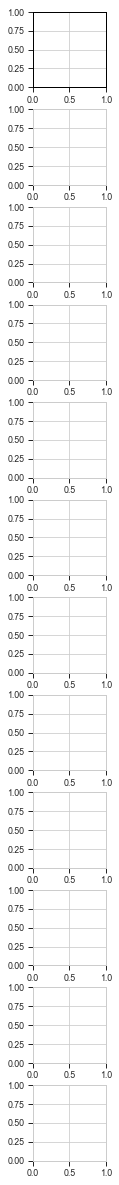

In [56]:
## SECOND AXIS IN RPU

rows = 12
cols = 1
fig2_RNAP_1col, ax2_RNAP_1col = plt.subplots(rows,cols, figsize=(1.69*cols,1.38*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(h_pad = 0) #tidies up spacing between plots

tfs_means_RNAP = dict()

YJP_sensors = {'iptg':{'data': [0.021431748, 0.022688664, 0.039392193, 0.072640679, 0.136195985, 0.394282562, 0.582313422, 1.068757518, 1.548874634, 3.665975836, 4.046492331, 4.332246466],
                      'conc': [0.1, 1, 5, 10, 20, 40, 60, 80, 100, 200, 400, 500]},
                'atc':{'data': [0.00888889, 0.00888889, 0.00777778, 0.00888889, 0.01333333, 1.387692307, 4.903931627, 5.689401707],
#                       'conc': [0.002160387, 0.021603871, 0.216038714, 1.080193571, 2.160387141, 10.80193571, 21.60387141, 43.20774283]},
                       'conc': [2.16039E-06, 2.16039E-05, 0.000216039, 0.001080194, 0.002160387, 0.010801936, 0.021603871, 0.043207743]},
              'ara':{'data': [0.015470085, 0.018632479, 0.031965812, 0.046153846, 1.506495726, 2.782564103, 3.015042735, 3.142393162],
                    'conc': [0.1, 1, 31.25, 62.5, 250, 1000, 10000, 25000]},
              'cuma_dmso':{'data':[0.19, 2.39],
                     'conc': [0.0001, 500]},
              'van_dmso':{'data':[0.02, 3.79],
                     'conc': [0.0001, 200]},
              'ohc14_dmso':{'data':[0.01, 4.38],
                     'conc': [0.0001, 10]},
              'nar':{'data':[0.01, 0.22],
                     'conc': [0.0001, 1000]}}

tfs_means_RPU = dict()
tfs_YJP = dict()

YJP_sensors_inducers = ['ara','iptg','atc']
YJP_sensors_inducers2 = ['cuma_dmso','van_dmso','ohc14_dmso','nar']

for i in YJP_sensors_inducers:
    tfs_YJP[i] = build_transfer_functions([YJP_sensors[i]['conc']], # x data
                                                    [YJP_sensors[i]['data']], # y data
                                                    [i], # name
                                                    'activator') # kind

right_color = 'dodgerblue'

for i in inducers_withdmso:
    tfs_means_RNAP[i] = dict()
    for s in strains:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax2_RNAP_1col[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1)

            ## transfer functions
            ## artificially set low concentration to 0.0001 for figures and ease of showing broken axis
                                                           
            if i == 'atc': # need to adjust atc concentrations to uM instead of nM
                
                tfs_means_RNAP[i][s] = build_transfer_functions([[0.0001]+(pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist()[1:]], # x data
                                                    [means_RNAP[s].tolist()], # y data
                                                    [s], # name
                                                    'activator') # kind
            else:
                tfs_means_RNAP[i][s] = build_transfer_functions([[0.0001]+inducer_info_withdmso[i]['plot_conc'][1:]], # x data
                                                    [means_RNAP[s].tolist()], # y data
                                                    [s], # name
                                                    'activator') # kind
        
            ## scatter
            FP.scatter(tfs_means_RNAP[i][s][0].inputs, tfs_means_RNAP[i][s][0].outputs,
                                                    s = 5, zorder=3,
                                                     marker = 'o',
                                                     c = 'k',
                                                     edgecolors = 'k', linewidths = 0.5)#,
            
            
            ## errorbars
            FP.errorbar(tfs_means_RNAP[i][s][0].inputs, tfs_means_RNAP[i][s][0].outputs, yerr = stdevs_RNAP[s],
                        zorder=2, fmt = 'none', # plots just error bars, no marker or line
                        c = 'k',                                 
                        elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

            ## fitting line
            xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000) # x values for creating smooth line

            FP.plot(xvals, tfs_means_RNAP[i][s][0].hill_eqn_act(xvals),
                                              color = 'darkgrey',
                                              zorder = 1, linewidth = 2)#, label = legend_names[strain_info[s]['parent']])

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

#             if fig_pos[i]['fig_col'] == 0:                
            FP.set_ylabel('Output (RNAP/s)', size = 8, labelpad = 2)

            if i == 'nar':
                FP.set_xlabel('[Inducer] (\u03BCM)'.format(i), size = 8, labelpad = 1)

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)

            ## set x ticks
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
            FP.xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            FP.xaxis.set_minor_locator(x_minor)
            FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
            ## set y ticks
            y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 6)
            FP.yaxis.set_major_locator(y_major)
            y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            FP.yaxis.set_minor_locator(y_minor)
            FP.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
            FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2)
            FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
            FP.set_ylim(.00001,3)
            FP.set_xlim(0.0001, 10000)

            FP.yaxis.grid(False)
            FP.xaxis.grid(False)
#             FP.legend(markerscale = 1, fontsize = 16)
#             FP.legend.legendHandles._legmarker.set_markersize(50)

#             FP.text(8000, .00125, strain_info_withdmso[s]['promoter'], 
#                                   va = 'bottom', ha = 'right', 
#                                   fontsize = 14)


    if i in YJP_sensors_inducers:
        FP = ax2_RNAP_1col[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
        
#         FP.scatter(tfs_YJP[i][0].inputs, tfs_YJP[i][0].outputs,
#                                                     s = 5, zorder=3,
#                                                      marker = 'o',
#                                                      c = 'white',
#                                                      edgecolors = 'cornflowerblue', linewidths = 0.5)
        
        FP.plot(xvals, tfs_YJP[i][0].hill_eqn_act(xvals)*0.073,
                                          color = right_color,
                                          zorder = 1, linewidth = 2)
        
    if i in YJP_sensors_inducers2:
        FP = ax2_RNAP_1col[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
        
        FP.scatter(YJP_sensors[i]['conc'], np.array(YJP_sensors[i]['data'])*0.073, 
                                             s = 5, zorder=3,marker = 'o', c = right_color,
                                             edgecolors = right_color, linewidths = 0.5)
        

# # gets rid of empty plots
fig2_RNAP_1col.delaxes(ax2_RNAP_1col[7]) # zero indexing
fig2_RNAP_1col.delaxes(ax2_RNAP_1col[10]) # zero indexing

/usr/local/lib/python3.6/site-packages/transferfunction.py:69: RuntimeWarning: invalid value encountered in double_scalars


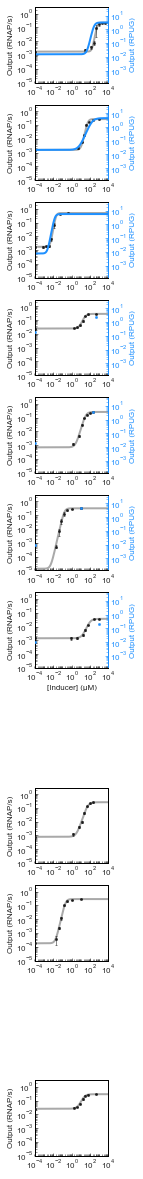

In [137]:
# ## SECOND AXIS IN RPU

# rows = 12
# cols = 1
# fig2_RNAP_1col, ax2_RNAP_1col = plt.subplots(rows,cols, figsize=(1.69*cols,1.38*rows), sharey = 'row') # row, column format
# # fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
# plt.tight_layout(h_pad = 0) #tidies up spacing between plots

# tfs_means_RNAP = dict()

# YJP_sensors = {'iptg':{'data': [0.021431748, 0.022688664, 0.039392193, 0.072640679, 0.136195985, 0.394282562, 0.582313422, 1.068757518, 1.548874634, 3.665975836, 4.046492331, 4.332246466],
#                       'conc': [0.1, 1, 5, 10, 20, 40, 60, 80, 100, 200, 400, 500]},
#                 'atc':{'data': [0.00888889, 0.00888889, 0.00777778, 0.00888889, 0.01333333, 1.387692307, 4.903931627, 5.689401707],
# #                       'conc': [0.002160387, 0.021603871, 0.216038714, 1.080193571, 2.160387141, 10.80193571, 21.60387141, 43.20774283]},
#                        'conc': [2.16039E-06, 2.16039E-05, 0.000216039, 0.001080194, 0.002160387, 0.010801936, 0.021603871, 0.043207743]},
#               'ara':{'data': [0.015470085, 0.018632479, 0.031965812, 0.046153846, 1.506495726, 2.782564103, 3.015042735, 3.142393162],
#                     'conc': [0.1, 1, 31.25, 62.5, 250, 1000, 10000, 25000]},
#               'cuma_dmso':{'data':[0.19, 2.39],
#                      'conc': [0.0001, 500]},
#               'van_dmso':{'data':[0.02, 3.79],
#                      'conc': [0.0001, 200]},
#               'ohc14_dmso':{'data':[0.01, 4.38],
#                      'conc': [0.0001, 10]},
#               'nar':{'data':[0.01, 0.22],
#                      'conc': [0.0001, 1000]}}

# tfs_means_RPU = dict()
# tfs_YJP = dict()

# YJP_sensors_inducers = ['ara','iptg','atc']
# YJP_sensors_inducers2 = ['cuma_dmso','van_dmso','ohc14_dmso','nar']

# for i in YJP_sensors_inducers:
#     tfs_YJP[i] = build_transfer_functions([YJP_sensors[i]['conc']], # x data
#                                                     [YJP_sensors[i]['data']], # y data
#                                                     [i]) # name

# right_color = 'dodgerblue'

# for i in inducers_withdmso:
#     tfs_means_RNAP[i] = dict()
#     for s in strains:
#         if strain_info_withdmso[s]['inducer']==i:
            
#             FP = ax2_RNAP_1col[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
            
#             for spine in FP.spines.values():
#                         spine.set_edgecolor('black')
#                         spine.set_linewidth(1)

#             ## transfer functions
#             ## artificially set low concentration to 0.0001 for figures and ease of showing broken axis
                                                           
#             if i == 'atc': # need to adjust atc concentrations to uM instead of nM
                
#                 tfs_means_RNAP[i][s] = build_transfer_functions([[0.0001]+(pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist()[1:]], # x data
#                                                     [means_RNAP[s].tolist()], # y data
#                                                     [s]) # name
#             else:
#                 tfs_means_RNAP[i][s] = build_transfer_functions([[0.0001]+inducer_info_withdmso[i]['plot_conc'][1:]], # x data
#                                                     [means_RNAP[s].tolist()], # y data
#                                                     [s]) # name
        
#             ## scatter
#             FP.scatter(tfs_means_RNAP[i][s][0].inputs, tfs_means_RNAP[i][s][0].outputs,
#                                                     s = 5, zorder=3,
#                                                      marker = 'o',
#                                                      c = 'k',
#                                                      edgecolors = 'k', linewidths = 0.5)#,
            
            
#             ## errorbars
#             FP.errorbar(tfs_means_RNAP[i][s][0].inputs, tfs_means_RNAP[i][s][0].outputs, yerr = stdevs_RNAP[s],
#                         zorder=2, fmt = 'none', # plots just error bars, no marker or line
#                         c = 'k',                                 
#                         elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
# #                                                                     label = legend_names[strain_info[s]['parent']])

#             ## fitting line
#             xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000) # x values for creating smooth line

#             FP.plot(xvals, tfs_means_RNAP[i][s][0].hill_eqn(xvals),
#                                               color = 'darkgrey',
#                                               zorder = 1, linewidth = 2)#, label = legend_names[strain_info[s]['parent']])

# #             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
# #             FP.plot([],[], marker = plot_info[r][i]['marker'],
# #                                                                   mec = plot_info[r][i]['edgecolor'],
# #                                                                   mew = 2,
# #                                                                   mfc = plot_info[r][i]['facecolor'],
# #                                                                   ms = 10,
# #                                                                   color = plot_info[r][i]['linecolor'],
# #                                                                   linewidth = 10, label = s)

#             FP.set_yscale('log')
#             FP.set_xscale('log')

# #             if fig_pos[i]['fig_col'] == 0:                
#             FP.set_ylabel('Output (RNAP/s)', size = 8, labelpad = 2)

#             if i == 'nar':
#                 FP.set_xlabel('[Inducer] (\u03BCM)'.format(i), size = 8, labelpad = 1)

# #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
# #                                                        size = 24, pad = 10)

#             ## set x ticks
#             x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
#             FP.xaxis.set_major_locator(x_major)
#             x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
#             FP.xaxis.set_minor_locator(x_minor)
#             FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
#             ## set y ticks
#             y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 6)
#             FP.yaxis.set_major_locator(y_major)
#             y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
#             FP.yaxis.set_minor_locator(y_minor)
#             FP.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
#             FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2)
#             FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
#             FP.set_ylim(.00001,3)
#             FP.set_xlim(0.0001, 10000)

#             FP.yaxis.grid(False)
#             FP.xaxis.grid(False)
# #             FP.legend(markerscale = 1, fontsize = 16)
# #             FP.legend.legendHandles._legmarker.set_markersize(50)

# #             FP.text(8000, .00125, strain_info_withdmso[s]['promoter'], 
# #                                   va = 'bottom', ha = 'right', 
# #                                   fontsize = 14)


#     if i in YJP_sensors_inducers:
#         FP = ax2_RNAP_1col[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
#         ax2_RNAP_1col_right = FP.twinx()
#         FP_right = ax2_RNAP_1col_right
        
#         for spine in FP_right.spines.values():
#                         spine.set_edgecolor('black')
#                         FP_right.spines['right'].set_edgecolor(right_color)
#                         spine.set_linewidth(1)
                        
        
# #         FP.scatter(tfs_YJP[i][0].inputs, tfs_YJP[i][0].outputs,
# #                                                     s = 5, zorder=3,
# #                                                      marker = 'o',
# #                                                      c = 'white',
# #                                                      edgecolors = 'cornflowerblue', linewidths = 0.5)
        
#         FP_right.plot(xvals, tfs_YJP[i][0].hill_eqn(xvals),
#                                           color = right_color,
#                                           zorder = 1, linewidth = 2)
        
#         FP_right.set_yscale('log')
#         FP_right.set_ylabel('Output (RPUG)', size = 8, labelpad = 2, color = right_color)
        
#         ## set y ticks
#         y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 6)
#         FP_right.yaxis.set_major_locator(y_major)
#         y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
#         FP_right.yaxis.set_minor_locator(y_minor)
#         FP_right.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#         FP_right.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2, colors = right_color)
#         FP_right.tick_params(which='minor', length = 2, width = 0.5, direction = 'in', colors = right_color)
        
#         FP_right.set_ylim(.00001/0.073,3/0.073)
#         FP_right.yaxis.grid(False)
        
#     if i in YJP_sensors_inducers2:
#         FP = ax2_RNAP_1col[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
#         ax2_RNAP_1col_right = FP.twinx()
#         FP_right = ax2_RNAP_1col_right
        
#         for spine in FP_right.spines.values():
#                         spine.set_edgecolor('black')
#                         FP_right.spines['right'].set_edgecolor(right_color)
#                         spine.set_linewidth(1)
        
#         FP_right.scatter(YJP_sensors[i]['conc'], YJP_sensors[i]['data'], 
#                                              s = 5, zorder=3,marker = 'o', c = right_color,
#                                              edgecolors = right_color, linewidths = 0.5)
        
#         FP_right.set_yscale('log')
#         FP_right.set_ylabel('Output (RPUG)', size = 8, labelpad = 2, color = right_color)
        
#         ## set y ticks
#         y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 6)
#         FP_right.yaxis.set_major_locator(y_major)
#         y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
#         FP_right.yaxis.set_minor_locator(y_minor)
#         FP_right.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#         FP_right.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2, colors = right_color)
#         FP_right.tick_params(which='minor', length = 2, width = 0.5, direction = 'in', colors = right_color)
        
#         FP_right.set_ylim(.00001/0.073,3/0.073)
#         FP_right.yaxis.grid(False)

# # # gets rid of empty plots
# fig2_RNAP_1col.delaxes(ax2_RNAP_1col[7]) # zero indexing
# fig2_RNAP_1col.delaxes(ax2_RNAP_1col[10]) # zero indexing

In [143]:
# fig2_RNAP_1col.savefig('EcN_Sensors_TFs_RNAP_ErrorBars_Pcin_adjusted_darkgrey_onecolumn.pdf', bbox_inches = "tight", transparent = True)

# fig2_RNAP_1col.savefig('EcN_Sensors_TFs_RNAP_ErrorBars_Pcin_adjusted_darkgrey_onecolumn_MG1655rnap.pdf', bbox_inches = "tight", transparent = True)

# fig2_RNAP_1col.savefig('EcN_Sensors_TFs_RNAP_ErrorBars_Pcin_adjusted_darkgrey_onecolumn_TwoAxes_RPU_MG1655.pdf', bbox_inches = "tight", transparent = True)



In [165]:
stdevs_RNAP[s]

0.0       0.000400
5.0       0.000446
15.0      0.000523
25.0      0.002656
40.0      0.012624
70.0      0.001464
200.0     0.015811
1000.0    0.015281
dtype: float64

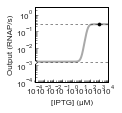

In [57]:
rows = 1
cols = 1
fig2_RNAP_iptg, ax2_RNAP_iptg = plt.subplots(rows,cols, figsize=(1.69*cols,1.65*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(h_pad = 0) #tidies up spacing between plots

tfs_means_RNAP = dict()

for i in ['iptg']:
    tfs_means_RNAP[i] = dict()
    for s in ['AJT269']:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax2_RNAP_iptg
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1)

            ## transfer functions
            ## artificially set low concentration to 0.0001 for figures and ease of showing broken axis                                                       
            else:
                tfs_means_RNAP[i][s] = build_transfer_functions([[0.0001]+inducer_info_withdmso[i]['plot_conc'][1:]], # x data
                                                    [means_RNAP[s].tolist()], # y data
                                                    [s]) # name
        
            ## scatter
            FP.scatter(tfs_means_RNAP[i][s][0].inputs[0], tfs_means_RNAP[i][s][0].outputs[0],
                                                    s = 10, zorder=3,
                                                     marker = 'o',
                                                     c = 'white',
                                                     edgecolors = 'black', linewidths = 0.5)#,
            
            FP.scatter(tfs_means_RNAP[i][s][0].inputs[-1], tfs_means_RNAP[i][s][0].outputs[-1],
                                        s = 10, zorder=3,
                                         marker = 'o',
                                         c = 'black',
                                         edgecolors = 'black', linewidths = 0.5)#,
            
            ## errorbars
            FP.errorbar([tfs_means_RNAP[i][s][0].inputs[0]] + [tfs_means_RNAP[i][s][0].inputs[-1]], 
                        [tfs_means_RNAP[i][s][0].outputs[0]] + [tfs_means_RNAP[i][s][0].outputs[-1]], yerr = [stdevs_RNAP[s][0]] + [stdevs_RNAP[s][1000]],
                        zorder=2, fmt = 'none', # plots just error bars, no marker or line
                        c = 'black',                                 
                        elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

            ## fitting line
            xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000) # x values for creating smooth line

            FP.plot(xvals, tfs_means_RNAP[i][s][0].hill_eqn(xvals),
                                              color = 'darkgrey',
                                              zorder = 1, linewidth = 2)#, label = legend_names[strain_info[s]['parent']])

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

#             if fig_pos[i]['fig_col'] == 0:                
            FP.set_ylabel('Output (RNAP/s)', size = 8, labelpad = 2)

#             if i == 'nar':
            FP.set_xlabel('[IPTG] (\u03BCM)', size = 8, labelpad = 2)

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)

            ## set x ticks
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 9)
            FP.xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            FP.xaxis.set_minor_locator(x_minor)
            FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
            FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2)
            FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
            
            xmin = 0.0001
            xmax = 10000
            FP.set_ylim(.0001,3)
            FP.set_xlim(xmin, xmax)

            FP.yaxis.grid(False)
            FP.xaxis.grid(False)
            
            FP.hlines(tfs_means_RNAP[i][s][0].outputs[0], xmin, xmax, linestyle = (0, (5, 5)), linewidth = 0.5)
            FP.hlines(tfs_means_RNAP[i][s][0].outputs[-1], xmin, xmax, linestyle = (0, (5, 5)), linewidth = 0.5)
            
#             FP.legend(markerscale = 1, fontsize = 16)
#             FP.legend.legendHandles._legmarker.set_markersize(50)

#             FP.text(8000, .00125, strain_info_withdmso[s]['promoter'], 
#                                   va = 'bottom', ha = 'right', 
#                                   fontsize = 14)


In [58]:
# fig2_RNAP_iptg.savefig('EcN_Sensors_TFs_RNAP_ErrorBars_IPTGonly.pdf', bbox_inches = "tight", transparent = True)


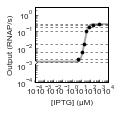

In [70]:
rows = 1
cols = 1
fig2_RNAP_iptg_conv, ax2_RNAP_iptg_conv = plt.subplots(rows,cols, figsize=(1.69*cols,1.65*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(h_pad = 0) #tidies up spacing between plots

tfs_means_RNAP = dict()

for i in ['iptg']:
    tfs_means_RNAP[i] = dict()
    for s in ['AJT269']:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax2_RNAP_iptg_conv
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1)

            ## transfer functions
            ## artificially set low concentration to 0.0001 for figures and ease of showing broken axis                                                       
            tfs_means_RNAP[i][s] = build_transfer_functions([[0.0001]+inducer_info_withdmso[i]['plot_conc'][1:]], # x data
                                                    [means_RNAP[s].tolist()], # y data
                                                    [s]) # name
        
            ## scatter
            FP.scatter(tfs_means_RNAP[i][s][0].inputs[0], tfs_means_RNAP[i][s][0].outputs[0],
                                                    s = 10, zorder=3,
                                                     marker = 'o',
                                                     c = 'white',
                                                     edgecolors = 'black', linewidths = 0.5)#,
            
            FP.scatter(tfs_means_RNAP[i][s][0].inputs[1:], tfs_means_RNAP[i][s][0].outputs[1:],
                                        s = 10, zorder=3,
                                         marker = 'o',
                                         c = 'black',
                                         edgecolors = 'black', linewidths = 0.5)#,
            
            ## errorbars
            FP.errorbar(tfs_means_RNAP[i][s][0].inputs, tfs_means_RNAP[i][s][0].outputs, 
                        yerr = stdevs_RNAP[s],
                        zorder=2, fmt = 'none', # plots just error bars, no marker or line
                        c = 'black',                                 
                        elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

            ## fitting line
            xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000) # x values for creating smooth line

            FP.plot(xvals, tfs_means_RNAP[i][s][0].hill_eqn(xvals),
                                              color = 'darkgrey',
                                              zorder = 1, linewidth = 2)#, label = legend_names[strain_info[s]['parent']])

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

#             if fig_pos[i]['fig_col'] == 0:                
            FP.set_ylabel('Output (RNAP/s)', size = 8, labelpad = 2)

#             if i == 'nar':
            FP.set_xlabel('[IPTG] (\u03BCM)', size = 8, labelpad = 2)

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)

            ## set x ticks
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 9)
            FP.xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            FP.xaxis.set_minor_locator(x_minor)
            FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
            FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2)
            FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
            
            xmin = 0.0001
            xmax = 10000
            FP.set_ylim(.0001,3)
            FP.set_xlim(xmin, xmax)

            FP.yaxis.grid(False)
            FP.xaxis.grid(False)
            
#             FP.hlines(tfs_means_RNAP[i][s][0].outputs[0], xmin, xmax, linestyle = (0, (5, 5)), linewidth = 0.5)
#             FP.hlines(tfs_means_RNAP[i][s][0].outputs[-1], xmin, xmax, linestyle = (0, (5, 5)), linewidth = 0.5)
            FP.hlines(tfs_means_RNAP[i][s][0].outputs, xmin, xmax, linestyle = (0, (5, 5)), linewidth = 0.5)
            
#             FP.legend(markerscale = 1, fontsize = 16)
#             FP.legend.legendHandles._legmarker.set_markersize(50)

#             FP.text(8000, .00125, strain_info_withdmso[s]['promoter'], 
#                                   va = 'bottom', ha = 'right', 
#                                   fontsize = 14)


In [71]:
# fig2_RNAP_iptg_conv.savefig('EcN_Sensors_TFs_RNAP_ErrorBars_IPTGonly_Conv.pdf', bbox_inches = "tight", transparent = True)


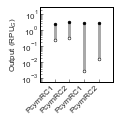

In [106]:
## SECOND AXIS IN RPU
rows = 1
cols = 1
fig_prom1v2, ax_prom1v2 = plt.subplots(rows,cols, figsize=(1.69*cols,1.65*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(h_pad = 0) #tidies up spacing between plots


FP = ax_prom1v2

for spine in FP.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1)
            

# YJ's Pcym-GV_v1, Pcym-GV_v2, Pvan_v1, Pvan_v2 data
## Data is from single replicate, uses different sensor array than EcN, and was measured on MacsQuant
# OFF state
YJP_rpu_off = [0.003046923, 0.016678652, 0.001461604, 0.057978172]
YJP_rpu_on = [2.745533905, 2.732521896, 2.572905132,2.770481055]
YJP_rpu_x = [2, 2.5, 4.5, 5]

# Van data is from 2019-12-19 notebook, Cuma data is from 2020-08-11 notebook
AJT_rpu_off = [0.256214, 0.338910, 0.020202,  0.015152]
AJT_rpu_on = [2.399909, 3.573248, 3.787062, 3.320755]
AJT_rnap_off = [r*0.073 for r in AJT_rpu_off]
AJT_rnap_on = [r*0.073 for r in AJT_rpu_on]
AJT_rpu_x = [1, 1.5, 3.5,  4]

# OFF state
# FP.scatter(YJP_rpu_x, np.array(YJP_rpu_off)*0.073,
FP.scatter(YJP_rpu_x, np.array(YJP_rpu_off),
               color = 'white', edgecolor = 'black', linewidths = 0.5, marker = 'o', s = 8, zorder = 1)
    
# FP.scatter(AJT_rpu_x, AJT_rnap_off,
FP.scatter(AJT_rpu_x, AJT_rpu_off,
               color = 'white', edgecolor = 'black', linewidths = 0.5, marker = 'o', s = 8, zorder = 1)
    
# ON state
# FP.scatter(YJP_rpu_x, np.array(YJP_rpu_on)*0.073,
FP.scatter(YJP_rpu_x, np.array(YJP_rpu_on),
           color = 'black', edgecolor = 'black', linewidths = 0.5, marker = 'o', s = 8, zorder = 1)

# FP.scatter(AJT_rpu_x, AJT_rnap_on,
FP.scatter(AJT_rpu_x, AJT_rpu_on,
           color = 'black', edgecolor = 'black', linewidths = 0.5, marker = 'o', s = 8, zorder = 1)


for x in YJP_rpu_x:
#     FP.plot([x,x], [np.array(YJP_rpu_off[YJP_rpu_x.index(x)])*0.073, np.array(YJP_rpu_on[YJP_rpu_x.index(x)])*0.073],
    FP.plot([x,x], [np.array(YJP_rpu_off[YJP_rpu_x.index(x)]), np.array(YJP_rpu_on[YJP_rpu_x.index(x)])],
                          color = 'darkgrey' ,
                          zorder = 0, linewidth = 3)
    
for x in AJT_rpu_x:
#     FP.plot([x,x], [AJT_rnap_off[AJT_rpu_x.index(x)], AJT_rnap_on[AJT_rpu_x.index(x)]],
    FP.plot([x,x], [AJT_rpu_off[AJT_rpu_x.index(x)], AJT_rpu_on[AJT_rpu_x.index(x)]],
                          color = 'darkgrey',
                          zorder = 0, linewidth = 3)
            
FP.set_yscale('log')
FP.set_xscale('linear')

#             if fig_pos[i]['fig_col'] == 0:                
# FP.set_ylabel('Output (RNAP/s)', size = 8, labelpad = 2)
FP.set_ylabel('Output (RPU$_G$)', size = 8, labelpad = 2)

FP.yaxis.grid(False)
FP.xaxis.grid(False)

FP.set_xticks(np.append(YJP_rpu_x, AJT_rpu_x))
xticklabels = ['PcymRC1','PcymRC2','PVanCC1','PVanCC2']*2
FP.set_xticklabels(xticklabels, size = 8, rotation = 45, ha='right')

# FP.set_ylim(0.001*0.073, 10*0.073)
FP.set_ylim(0.0006, 30)
FP.set_xlim(0.5,3)

# set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
FP.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
FP.yaxis.set_minor_locator(y_minor)
FP.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2)
FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')


In [107]:
# fig_prom1v2.savefig('FigS3_Pcym_v1_v2_EcN_MG1655_RPU.pdf', bbox_inches = "tight", transparent = True)


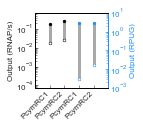

In [124]:
# ## SECOND AXIS IN RPU
# rows = 1
# cols = 1
# fig_prom1v2, ax_prom1v2 = plt.subplots(rows,cols, figsize=(1.69*cols,1.65*rows), sharey = 'row') # row, column format
# # fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
# plt.tight_layout(h_pad = 0) #tidies up spacing between plots


# FP = ax_prom1v2
# ax_prom1v2_right = FP.twinx()
# FP_right = ax_prom1v2_right

# for spine in FP.spines.values():
#             spine.set_edgecolor('black')
#             spine.set_linewidth(1)
            
# for spine in FP_right.spines.values():
#             spine.set_edgecolor('black')
#             spine.set_linewidth(1)

# # YJ's Pcym-GV_v1, Pcym-GV_v2, Pvan_v1, Pvan_v2 data
# ## Data is from single replicate, uses different sensor array than EcN, and was measured on MacsQuant
# # OFF state
# YJP_rpu_off = [0.003046923, 0.016678652, 0.001461604, 0.057978172]
# YJP_rpu_on = [2.745533905, 2.732521896, 2.572905132,2.770481055]
# YJP_rpu_x = [2, 2.5, 4.5, 5]

# # Van data is from 2019-12-19 notebook, Cuma data is from 2020-08-11 notebook
# AJT_rpu_off = [0.256214, 0.338910, 0.020202,  0.015152]
# AJT_rpu_on = [2.399909, 3.573248, 3.787062, 3.320755]
# AJT_rnap_off = [r*0.073 for r in AJT_rpu_off]
# AJT_rnap_on = [r*0.073 for r in AJT_rpu_on]
# AJT_rpu_x = [1, 1.5, 3.5,  4]

# right_color = 'dodgerblue'

# # OFF state
# FP_right.scatter(YJP_rpu_x, YJP_rpu_off,
#                color = 'white', edgecolor = right_color, linewidths = 0.5, marker = 'o', s = 8, zorder = 1)
    
# FP.scatter(AJT_rpu_x, AJT_rnap_off,
#                color = 'white', edgecolor = 'black', linewidths = 0.5, marker = 'o', s = 8, zorder = 1)
    
# # ON state
# FP_right.scatter(YJP_rpu_x, YJP_rpu_on,
#            color = right_color, edgecolor = right_color, linewidths = 0.5, marker = 'o', s = 8, zorder = 1)

# FP.scatter(AJT_rpu_x, AJT_rnap_on,
#            color = 'black', edgecolor = 'black', linewidths = 0.5, marker = 'o', s = 8, zorder = 1)


# for x in YJP_rpu_x:
#     FP_right.plot([x,x], [YJP_rpu_off[YJP_rpu_x.index(x)], YJP_rpu_on[YJP_rpu_x.index(x)]],
#                           color = 'darkgrey' ,
#                           zorder = 0, linewidth = 3)
    
# for x in AJT_rpu_x:
#     FP.plot([x,x], [AJT_rnap_off[AJT_rpu_x.index(x)], AJT_rnap_on[AJT_rpu_x.index(x)]],
#                           color = 'darkgrey',
#                           zorder = 0, linewidth = 3)
            
# FP.set_yscale('log')
# FP_right.set_yscale('log')
# FP.set_xscale('linear')

# #             if fig_pos[i]['fig_col'] == 0:                
# FP.set_ylabel('Output (RNAP/s)', size = 8, labelpad = 2)
# FP_right.set_ylabel('Output (RPUG)', size = 8, labelpad = 2, color=right_color)

# FP.yaxis.grid(False)
# FP_right.yaxis.grid(False)
# FP.xaxis.grid(False)

# FP.set_xticks(np.append(YJP_rpu_x, AJT_rpu_x))
# xticklabels = ['PcymRC1','PcymRC2','PVanCC1','PVanCC2']*2
# FP.set_xticklabels(xticklabels, size = 8, rotation = 45, ha='right')

# FP.set_ylim(0.001*0.073, 10*0.073)
# FP_right.set_ylim(0.001, 10)
# FP.set_xlim(0.5,3)

# # set y ticks
# y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
# FP.yaxis.set_major_locator(y_major)
# FP_right.yaxis.set_major_locator(y_major)
# y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
# FP.yaxis.set_minor_locator(y_minor)
# FP_right.yaxis.set_minor_locator(y_minor)
# FP.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# FP_right.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2)
# FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')

# FP_right.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2, colors=right_color)
# FP_right.tick_params(which='minor', length = 2, width = 0.5, direction = 'in', colors=right_color)

# FP_right.spines['right'].set_color(right_color)
# FP_right.spines['right'].set_linewidth(1)



In [147]:
# fig_prom1v2.savefig('Pcym_v1_v2_EcN_MG1655_RNAPonly.pdf', bbox_inches = "tight", transparent = True)


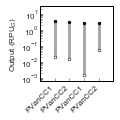

In [108]:
ax_prom1v2.set_xlim(3,5.5)
fig_prom1v2

In [109]:
# fig_prom1v2.savefig('FigS3_Pvan_v1_v2_EcN_MG1655_RPU.pdf', bbox_inches = "tight", transparent = True)


In [32]:
strain_info_withdmso

NameError: name 'strain_info_withdmso' is not defined

In [46]:
YJP_sensors = {'iptg':{'data': [0.021431748, 0.022688664, 0.039392193, 0.072640679, 0.136195985, 0.394282562, 0.582313422, 1.068757518, 1.548874634, 3.665975836, 4.046492331, 4.332246466],
                      'conc': [0.1, 1, 5, 10, 20, 40, 60, 80, 100, 200, 400, 500]},
                'atc':{'data': [0.00888889, 0.00888889, 0.00777778, 0.00888889, 0.01333333, 1.387692307, 4.903931627, 5.689401707],
                      'conc': [0.002160387, 0.021603871, 0.216038714, 1.080193571, 2.160387141, 10.80193571, 21.60387141, 43.20774283]},
              'ara':{'data': [0.015470085, 0.018632479, 0.031965812, 0.046153846, 1.506495726, 2.782564103, 3.015042735, 3.142393162],
                    'conc': [0.0001, 0.001, 0.03125, 0.0625, 0.25, 1, 10, 25]}}

tfs_YJP = dict()

for i in ['ara','iptg','atc']:
    tfs_YJP[i] = build_transfer_functions([YJP_sensors[i]['conc']], # x data
                                                    [YJP_sensors[i]['data']], # y data
                                                    [i]) # name
    
    
           
        
        
        
        
        
        
        
        
        ## fitting line
            xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000) # x values for creating smooth line

            FP.plot(xvals, tfs_means_RPU[i][s][0].hill_eqn(xvals),
                                              color = 'darkgrey',
                                              zorder = 1, linewidth = 2)#, label = legend_names[strain_info[s]['parent']])

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

#             if fig_pos[i]['fig_col'] == 0:                
            FP.set_ylabel('Output (RPU)', size = 7, labelpad = 2)

            if i == 'nar':
                FP.set_xlabel('[Inducer] (\u03BCM)'.format(i), size = 7, labelpad = 1)

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)

            ## set x ticks
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
            FP.xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            FP.xaxis.set_minor_locator(x_minor)
            FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
            FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
            FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
            FP.set_ylim(.001,30)
            FP.set_xlim(0.0001, 10000)

            FP.yaxis.grid(False)
            FP.xaxis.grid(False)


/usr/local/lib/python3.6/site-packages/transferfunction.py:69: RuntimeWarning: invalid value encountered in double_scalars


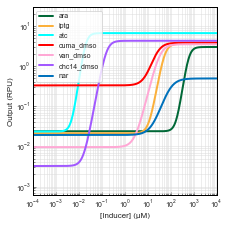

In [104]:
## plot transfer functions all in one plot

rows = 1 
cols = 1

fig3_RPU, ax3_RPU = plt.subplots(rows,cols, figsize=(cols*3.2,rows*3.2), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 1, h_pad = 1, w_pad = 1) #tidies up spacing between plots


tfs_means_RPU = dict()
strains_subset = ['AJT270','AJT269','AJT273','AJT278_dmso','AJT276_dmso','AJT275_dmso','AJT274']
for i in inducers_withdmso:
    tfs_means_RPU[i] = dict()
    for s in strains_subset:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax3_RPU
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1)

            ## transfer functions
            if i == 'atc': # need to adjust atc concentrations to uM instead of nM

                tfs_means_RPU[i][s] = build_transfer_functions([[0.0001]+(pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist()[1:]], # x data
                                                    [means_RPU[s].tolist()], # y data
                                                    [s], # name
                                                    'activator') # kind
            else:
                tfs_means_RPU[i][s] = build_transfer_functions([[0.0001]+inducer_info_withdmso[i]['plot_conc'][1:]], # x data
                                                    [means_RPU[s].tolist()], # y data
                                                    [s], # name
                                                    'activator') # kind
        
#             ## scatter
#             FP.scatter(tfs_means_RPU[i][s][0].inputs, tfs_means_RPU[i][s][0].outputs,
#                                                     s = 20, zorder=3,
#                                                      marker = 'o',
#                                                      c = 'white',
#                                                      edgecolors = 'black', linewidths = 1)#,
            
            
#             ## errorbars
#             FP.errorbar(tfs_means_RPU[i][s][0].inputs, tfs_means_RPU[i][s][0].outputs, yerr = stdevs_RPU[s],
#                                                         zorder=2, fmt = 'none', # plots just error bars, no marker or line
#                                                         c = 'black', elinewidth = 1, capsize = 2)#,
# #                                                                     label = legend_names[strain_info[s]['parent']])

            ## fitting line
            xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000)
                
            FP.plot(xvals, tfs_means_RPU[i][s][0].hill_eqn_act(xvals),
                                              color = strain_info_withdmso[s]['color'],
                                              zorder = 1, linewidth = 2, label = i)

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

            if fig_pos[i]['fig_col'] == 0:                
                FP.set_ylabel('Output (RPU)', size = 8, labelpad = 2)

            FP.set_xlabel('[Inducer] (\u03BCM)', size = 8, labelpad = 2)  

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)
            FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
            FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
            FP.set_ylim(0.0006, 30)
            FP.set_xlim(.0001, 10000)

#             FP.yaxis.grid(True)
#             FP.xaxis.grid(True)
            
            FP.yaxis.grid(True, which='both', linewidth = 0.5, color = 'gainsboro')
            FP.xaxis.grid(True, which='both', linewidth = 0.5, color = 'gainsboro')
            FP.legend(markerscale = 1, fontsize = 7)
#             FP.legend.legendHandles._legmarker.set_markersize(50)

#             FP.text(max(tfs_means_RPU[i][s][0].inputs)/1.25, .00125, strain_info_withdmso[s]['promoter'], 
#                                                                   verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                   fontsize = 70)




In [105]:
# fig3_RPU.savefig('Fig2_EcN_Sensors_TFs_RPU_AllInOne_Pcin_adjusted.pdf', bbox_inches = "tight", transparent = True)


In [64]:
means_RNAP['AJT275_dmso']

0.000000     0.000013
0.019531     0.000538
0.039062     0.006985
0.078125     0.040078
0.156250     0.130249
0.312500     0.232048
1.250000     0.282357
10.000000    0.319199
dtype: float64

/usr/local/lib/python3.6/site-packages/transferfunction.py:69: RuntimeWarning: invalid value encountered in double_scalars


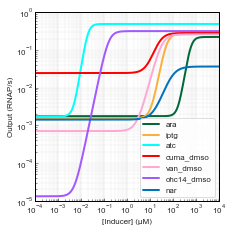

In [80]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
## plot transfer functions all in one plot

rows = 1 
cols = 1

fig3_RNAP, ax3_RNAP = plt.subplots(rows,cols, figsize=(cols*3.2,rows*3.2), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 1, h_pad = 1, w_pad = 1) #tidies up spacing between plots


tfs_means_RNAP = dict()
strains_subset = ['AJT270','AJT269','AJT273','AJT278_dmso','AJT276_dmso','AJT275_dmso','AJT274']
for i in inducers_withdmso:
    tfs_means_RNAP[i] = dict()
    for s in strains_subset:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = ax3_RNAP
            
            for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1)

            ## transfer functions
            if i == 'atc': # need to adjust atc concentrations to uM instead of nM

                tfs_means_RNAP[i][s] = build_transfer_functions([[0.0001]+(pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist()[1:]], # x data
                                                    [means_RNAP[s].tolist()], # y data
                                                    [s]) # name
            else:
                tfs_means_RNAP[i][s] = build_transfer_functions([[0.0001]+inducer_info_withdmso[i]['plot_conc'][1:]], # x data
                                                    [means_RNAP[s].tolist()], # y data
                                                    [s]) # name
        
#             ## scatter
#             FP.scatter(tfs_means_RPU[i][s][0].inputs, tfs_means_RPU[i][s][0].outputs,
#                                                     s = 20, zorder=3,
#                                                      marker = 'o',
#                                                      c = 'white',
#                                                      edgecolors = 'black', linewidths = 1)#,
            
            
#             ## errorbars
#             FP.errorbar(tfs_means_RPU[i][s][0].inputs, tfs_means_RPU[i][s][0].outputs, yerr = stdevs_RPU[s],
#                                                         zorder=2, fmt = 'none', # plots just error bars, no marker or line
#                                                         c = 'black', elinewidth = 1, capsize = 2)#,
# #                                                                     label = legend_names[strain_info[s]['parent']])

            ## fitting line
            xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000)
                
            FP.plot(xvals, tfs_means_RNAP[i][s][0].hill_eqn(xvals),
                                              color = strain_info_withdmso[s]['color'],
                                              zorder = 1, linewidth = 2, label = i)

#             ## plotting empty data as legend entry creation so that I can do marker and line despite them being different data that is plotted
#             FP.plot([],[], marker = plot_info[r][i]['marker'],
#                                                                   mec = plot_info[r][i]['edgecolor'],
#                                                                   mew = 2,
#                                                                   mfc = plot_info[r][i]['facecolor'],
#                                                                   ms = 10,
#                                                                   color = plot_info[r][i]['linecolor'],
#                                                                   linewidth = 10, label = s)

            FP.set_yscale('log')
            FP.set_xscale('log')

            if fig_pos[i]['fig_col'] == 0:                
                FP.set_ylabel('Output (RNAP/s)', size = 8, labelpad = 2)

            FP.set_xlabel('[Inducer] (\u03BCM)', size = 8, labelpad = 2)  

#                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
#                                                        size = 24, pad = 10)

           

            FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2)
            FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
            FP.set_ylim(.00001,1)
            FP.set_xlim(.0001, 10000)

#             FP.yaxis.grid(True)
#             FP.xaxis.grid(True)
            
            FP.yaxis.grid(True, which='both', linewidth = 0.25, color = 'gainsboro')
            FP.xaxis.grid(True, which='both', linewidth = 0.25, color = 'gainsboro')
            
            ## set x ticks
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 9)
            FP.xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            FP.xaxis.set_minor_locator(x_minor)
            FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
            FP.legend(markerscale = 1, fontsize = 8, facecolor ='white')
#             FP.legend.legendHandles._legmarker.set_markersize(50)

#             FP.text(max(tfs_means_RPU[i][s][0].inputs)/1.25, .00125, strain_info_withdmso[s]['promoter'], 
#                                                                   verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                   fontsize = 70)




In [81]:
# fig3_RNAP.savefig('EcN_Sensors_TFs_RNAP_AllInOne_Pcin_adjusted.pdf', bbox_inches = "tight", transparent = True)


In [35]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm # for making colorbar scale logarithmic
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [258]:
means_RPU['AJT269'][0]

0.02103289300520145

NameError: name 'tox_rel_means' is not defined

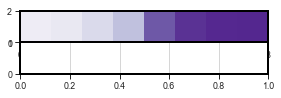

In [36]:
fig3_heat = plt.figure(figsize = (10,8))
main_grid = gridspec.GridSpec(4,2, hspace=1, wspace=0.25)

# remove height space between plots so that they can touch each other
grid1 = main_grid[0].subgridspec(2,1, hspace=0)
grid2 = main_grid[1].subgridspec(2,1, hspace=0)
grid3 = main_grid[2].subgridspec(2,1, hspace=0)
grid4 = main_grid[3].subgridspec(2,1, hspace=0)
grid5 = main_grid[4].subgridspec(2,1, hspace=0)
grid6 = main_grid[5].subgridspec(2,1, hspace=0)
grid7 = main_grid[6].subgridspec(2,1, hspace=0)
grid8 = main_grid[7].subgridspec(2,1, hspace=0)

# so that grids can be iterated through
grids = [grid1,grid3,grid4,grid5,grid6,grid7,grid8]

axes = [[[] for i in range(2)] for j in range(len(grids))]

strains_subset = ['AJT269','AJT270','AJT273','AJT274','AJT275_dmso','AJT276_dmso','AJT278_dmso']

for i in inducers_withdmso:
    tfs_means_RPU[i] = dict()
    for s in strains_subset:
        if strain_info_withdmso[s]['inducer']==i:
            
            for a in range(2):
                # add subplot to figure and assign to axes list of lists
                axes[strains_subset.index(s)][a] = fig3_heat.add_subplot(grids[strains_subset.index(s)][a])
            
            FP = axes[strains_subset.index(s)]
            for a in range(2):
                for spine in FP[a].spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(2)

            ## heatmap of fluorescence data
            hot_data = pd.DataFrame.transpose(pd.concat((pd.Series(means_RPU[s],name=s), means_RPU[s]), axis = 1))
            heatmap_fluor = FP[0].pcolor(hot_data, cmap="Purples",norm=LogNorm(vmin=.01, vmax=7))
            
            # toxicity data is separate for dmso inducers so need to do in two sets
            if s in ['AJT269','AJT270','AJT273','AJT274']:
                ## heatmap of toxicity data
                hot_data_tox = pd.DataFrame.transpose(pd.concat((pd.Series(tox_rel_means['M9'][i]['EcN'][s],name=s), tox_rel_means['M9'][i]['EcN'][s]), axis = 1))
            
            else:
                ## heatmap of toxicity data
                hot_data_tox = pd.DataFrame.transpose(pd.concat((pd.Series(tox2_rel_means['M9'][i]['EcN'][s],name=s), tox2_rel_means['M9'][i]['EcN'][s]), axis = 1))
            
            # diverging heatmap so it's clear when growth was impacted from normal
            heatmap_tox = FP[1].pcolor(hot_data_tox, cmap="bwr_r",vmin=.5, vmax=1.5)
            
            FP[0].set_ylabel(strain_info_withdmso[s]['promoter'], size = 12, 
                             rotation=0, position =(0,-0.3), labelpad = 20)
            
            #remove xticks of top plot
            FP[0].set_xticks([])
            # remove yticks
            FP[0].set_yticks([])
#             FP[0].set_yticklabels(strain_info_withdmso[s]['promoter'], pad = 10)
            FP[1].set_yticks([])
            
            # change xticks so I can label in middle of each position
            FP[1].set_xticks(np.arange(0.5,8.5,1))
            FP[1].set_xticklabels([round(e,2) for e in inducer_info_withdmso[i]['conc']], rotation=30)
            FP[1].set_xlabel('[{}]'.format(i), size = 12)
            
            FP[0].text(0.5,1,round(means_RPU[s][0],2), fontsize = 12, ha='center', va='center')
            FP[0].text(7.5,1,round(means_RPU[s][inducer_info_withdmso[i]['conc'][-1]],2), 
                       fontsize = 12, ha='center', va='center', color = 'white')
            
axins = inset_axes(axes[0][0],
                   width="100%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='upper left',
                   bbox_to_anchor=(1.25, 0., 1, 1),
                   bbox_transform=axes[0][0].transAxes,
                   borderpad=0,
                   )
            
cbar = fig3_heat.colorbar(heatmap_fluor,cax=axins, orientation='horizontal') # adds colorbar to this figure
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('Output (RPU)', rotation=0,fontsize = 12)
cbar.ax.tick_params(labelsize = 12, length = 6, width = 2) # change colorbar labelsize and ticks
cbar.ax.tick_params(which='minor',length = 4, width = 2) # change colorbar labelsize and ticks
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)

axins = inset_axes(axes[0][1],
                   width="100%",  # width = 12% of parent_bbox width
                   height="100%",  # height : 600%
                   loc='upper left',
                   bbox_to_anchor=(1.25, 0., 1, 1),
                   bbox_transform=axes[0][1].transAxes,
                   borderpad=0,
                   )

cbar = fig3_heat.colorbar(heatmap_tox,cax=axins, orientation='horizontal') # adds colorbar to this figure
cbar.set_label('Normalized growth\n(compared to no inducer)', rotation=0,fontsize = 12)
cbar.ax.tick_params(labelsize = 12, length = 6, width = 2) # change colorbar labelsize and ticks
cbar.ax.tick_params(which='minor',length = 4, width = 2) # change colorbar labelsize and ticks
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)


In [371]:
# fig3_heat.savefig('EcN_Sensors_RPU+Tox_HeatMaps_Pcin_adjusted.pdf', bbox_inches = "tight", transparent = True)


In [ ]:
for 

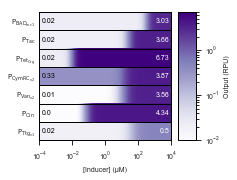

In [39]:
rows = 1
cols = 1

fig3_heat_v2, ax3_heat_v2 = plt.subplots(1,1, figsize=(cols*2.36,rows*2.36))

FP = ax3_heat_v2

# color borders of plot
for spine in FP.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# logarithmically distributed x values for calculating y-values
# doing this so that heatmap gradient can become smooth
xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000)

# calculate y-values based on fitted parameters at range of x-values aboves
tfs_means_RPU_dict = dict()

strains_subset = ['AJT270','AJT269','AJT273','AJT278_dmso','AJT276_dmso','AJT275_dmso','AJT274']
for i in inducers_withdmso:
    for s in strains_subset:
        if strain_info_withdmso[s]['inducer']==i:
            tfs_means_RPU_dict[s] = pd.Series(tfs_means_RPU[i][s][0].hill_eqn(xvals), 
                                          name = s, index = xvals) # code fails at this point so need to re-run the segment that generates all the separate transfer functions before running this
    
tfs_means_RPU_df = pd.DataFrame.transpose(pd.DataFrame.from_dict(tfs_means_RPU_dict))


#======== heatmap =========#
y = np.arange(len(tfs_means_RPU_df)+1) # not sure why/if it needs to be + 1

# first two args change coordinates that heatmap bins are placed at
# then plot data at those points
heatmap_fluor_v2 = ax3_heat_v2.pcolor(xvals,y,tfs_means_RPU_df,
                                      cmap="Purples",
                                      norm=LogNorm(vmin=.01, vmax=7))
ax3_heat_v2.set_xlim(0.0001, 10000)
ax3_heat_v2.set_xscale('log')
ax3_heat_v2.invert_yaxis() # so that they data are in same order as previously

ylabels = ['$\mathrm{P_{BAD_{mc1}}}$','$\mathrm{P_{Tac}}$','$\mathrm{P_{Tet_{Org}}}$',
           '$\mathrm{P_{CymRC_{v2}}}$','$\mathrm{P_{Van_{v2}}}$','$\mathrm{P_{Cin}}$','$\mathrm{P_{Ttg_{v1}}}$']

FP.set_yticks(np.arange(0.5,7.5,1))
FP.set_yticklabels(ylabels, size = 7)

FP.set_xlabel('[Inducer] (\u03BCM)', size = 7, labelpad = 4)

FP.tick_params(labelsize = 7, length = 5, width = 1, direction = 'out', pad = 4)
FP.tick_params(which='minor', length = 3, width = 1, direction = 'out')
FP.tick_params(axis = 'y', which='both', length=0, width=0)

# draw lines between linear heatmaps
for p in np.arange(1,len(y)):
    FP.axhline(p, ls = '-', lw = 1, c = 'black')

# write output RPU values on plot
for s in strains_subset:
    # uninduced
    FP.text(0.00015,strains_subset.index(s)+0.5,
            round(means_RPU[s][0],2), fontsize = 7, 
            ha='left', va='center', color = 'black')
    # induced
#     print(s,strain_info_withdmso[s]['inducer'], 
#          inducer_info_withdmso[strain_info_withdmso[s]['inducer']]['conc'])
    FP.text(8000,strains_subset.index(s)+0.5,
            round(means_RPU[s][inducer_info_withdmso[strain_info_withdmso[s]['inducer']]['conc'][-1]],2), fontsize = 7, 
            ha='right', va='center', color = 'white')
            
# make an inset axis for plotting the legend on
axins_v2 = inset_axes(FP,
                   width="14%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='upper left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=FP.transAxes,
                   borderpad=0,
                   )

# mess with colorbar labeling for heatmap_fluor
cbar = fig3_heat_v2.colorbar(heatmap_fluor_v2,cax=axins_v2, orientation='vertical') # adds colorbar to this figure
# cbar.ax.xaxis.set_ticks_position('top')
# cbar.ax.xaxis.set_label_position('top')
cbar.set_label('Output (RPU)',fontsize = 7)
cbar.ax.tick_params(labelsize = 7, length = 5, width = 1) # change colorbar labelsize and ticks
cbar.ax.tick_params(which='minor',length = 3, width = 1) # change colorbar labelsize and ticks
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)

In [379]:
# fig3_heat_v2.savefig('EcN_Sensors_RPUonly_HeatMaps_NoOD_Pcin_adjusted.pdf', bbox_inches = "tight", transparent = True)


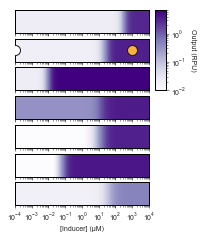

In [40]:
fig3_heat_v3 = plt.figure(figsize = (2.4,3.6))
main_grid = gridspec.GridSpec(7,1, hspace=0.25)

# remove height space between plots so that they can touch each other
grid1 = fig3_heat_v3.add_subplot(main_grid[0])
grid2 = fig3_heat_v3.add_subplot(main_grid[1])
grid3 = fig3_heat_v3.add_subplot(main_grid[2])
grid4 = fig3_heat_v3.add_subplot(main_grid[3])
grid5 = fig3_heat_v3.add_subplot(main_grid[4])
grid6 = fig3_heat_v3.add_subplot(main_grid[5])
grid7 = fig3_heat_v3.add_subplot(main_grid[6])


# so that grids can be iterated through
grids = [grid1,grid2,grid3,grid4,grid5,grid6,grid7]

axes_v3 = [[] for j in range(len(grids))]

strains_subset = ['AJT270','AJT269','AJT273','AJT278_dmso','AJT276_dmso','AJT275_dmso','AJT274']

# logarithmically distributed x values for calculating y-values
# doing this so that heatmap gradient can become smooth
xvals = np.logspace(np.log10(0.0001),np.log10(10000), 1000)

# calculate y-values based on fitted parameters at range of x-values aboves
tfs_means_RPU_dict = dict()


for i in inducers_withdmso:
    tfs_means_RPU_dict[s] = dict()
    for s in strains_subset:
        if strain_info_withdmso[s]['inducer']==i:
            
            FP = grids[strains_subset.index(s)]
        
            for spine in FP.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1)

            ## heatmap of fluorescence data
            tfs_means_RPU_dict[s] = pd.Series(tfs_means_RPU[i][s][0].hill_eqn(xvals), 
                                          name = s, index = xvals)
#             hot_data = pd.DataFrame.transpose(pd.concat((pd.Series(means_RPU[s],name=s), means_RPU[s]), axis = 1))

            hot_data = pd.DataFrame.transpose(pd.concat((pd.Series(tfs_means_RPU_dict[s],name=s), tfs_means_RPU_dict[s]), axis = 1))
    
            heatmap_fluor_v3 = FP.pcolor(xvals, [0,1], 
                                         hot_data, 
                                         cmap="Purples",
                                         norm=LogNorm(vmin=.01, vmax=7))
            
            FP.set_xlim(0.0001, 10000)
            FP.set_xscale('log')
            
#             FP.set_ylabel(strain_info_withdmso[s]['promoter'], size = 7, 
#                              rotation=0, position =(0,-0.3), labelpad = 2)
            
            FP.set_yticks([])
#             FP.set_yticklabels(strain_info_withdmso[s]['promoter'], size = 7)
            
            ## set x ticks
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 9)
            FP.xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            FP.xaxis.set_minor_locator(x_minor)
            FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
            FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'out', pad = 2)
            FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'out')
            
            if strains_subset.index(s) == 6:
                FP.set_xlabel('[Inducer] (\u03BCM)', size = 7, labelpad = 2)
                FP.tick_params(labelsize=7)
             
            if strains_subset.index(s) !=6:
                FP.set_xticklabels([])
                
            if strains_subset.index(s) == 1:
                FP.scatter(0.0001,0.5, # x, y
                           s = 100, zorder=3, marker = 'o',
                           c = 'white', edgecolors = 'k', linewidth = 1)
                FP.scatter(inducer_info_withdmso[i]['conc'][-1], 0.5, #x,y
                           s = 100, zorder=3, marker = 'o',
                           c = strain_info_withdmso[s]['color'], edgecolors = 'k', linewidth = 1)
                
            
            

            
#             FP.text(0.5,1,round(means_RPU[s][0],2), fontsize = 12, ha='center', va='center')
#             FP.text(7.5,1,round(means_RPU[s][inducer_info_withdmso[i]['conc'][-1]],2), 
#                        fontsize = 12, ha='center', va='center', color = 'white')
    

# make an inset axis for plotting the legend on
axins_v3 = inset_axes(grids[0],
                   width="8%",  # width = 5% of parent_bbox width
                   height="350%",  # height : 50%
                   loc='upper left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=grids[0].transAxes,
                   borderpad=0,
                   )
            
cbar = fig3_heat_v3.colorbar(heatmap_fluor_v3,cax=axins_v3, orientation='vertical') # adds colorbar to this figure
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('Output (RPU)', rotation=270, fontsize = 7, labelpad = 10)
cbar.ax.tick_params(labelsize = 7, length = 3, width = 0.5, pad = 2) # change colorbar labelsize and ticks
cbar.ax.tick_params(which='minor',length = 2, width = 0.5, pad = 2) # change colorbar labelsize and ticks
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)


In [142]:
# fig3_heat_v3.savefig('EcN_Sensors_RPUonly_HeatMaps_NoOD_Pcin_adjusted_SpacingAdded_withPoints.pdf', bbox_inches = "tight", transparent = True)


In [376]:
tfs_means_RPU['ara']

{}

In [48]:
media = ['M9']

In [65]:
hill_params = dict()
hill_params_df = dict()

for i in inducers_withdmso:
    hill_params[i] = dict()
    hill_params_df[i] = dict()
    for s in strains:
        # RPU
        if i == strain_info_withdmso[s]['inducer']: # to account for if there is more than one inducer
            hill_params[i][s] = ({'Promoter': strain_info_withdmso[s]['promoter'],
                             'Max inducer (uM)': round(max(tfs_means_RPU[i][s][0].inputs), 2),
                             'ymax (RPUG)' : round(max(tfs_means_RPU[i][s][0].outputs),2),
#                                      'ymin (RPU * 10^-3)' : round(min(tfs_means_RPU[i][s][0].outputs)/(1*10**-3),2),
                             'ymin (RPUG)' : round(min(tfs_means_RPU[i][s][0].outputs),6),
                             'K (uM)': round(tfs_means_RPU[i][s][0].kd, 2), 
                             'n': round(tfs_means_RPU[i][s][0].n, 2),
                             'fold-change': round((max(tfs_means_RPU[i][s][0].outputs))/(min(tfs_means_RPU[i][s][0].outputs)),2)})

        
        ## RNAP/s
#         if i == strain_info_withdmso[s]['inducer']: # to account for if there is more than one inducer
#                     hill_params[i][s] = ({'Promoter': strain_info_withdmso[s]['promoter'],
#                                      'Max inducer (uM)': round(max(tfs_means_RNAP[i][s][0].inputs), 2),
#                                      'ymax (RNAP/s)' : round(max(tfs_means_RNAP[i][s][0].outputs),2),
# #                                      'ymin (RPU * 10^-3)' : round(min(tfs_means_RPU[i][s][0].outputs)/(1*10**-3),2),
#                                      'ymin (RNAP/s)' : round(min(tfs_means_RNAP[i][s][0].outputs),6),
#                                      'K (uM)': round(tfs_means_RNAP[i][s][0].kd, 2), 
#                                      'n': round(tfs_means_RNAP[i][s][0].n, 2),
#                                      'fold-change': round((max(tfs_means_RNAP[i][s][0].outputs))/(min(tfs_means_RNAP[i][s][0].outputs)),2)})
    hill_params_df[i] = pd.DataFrame.from_dict(hill_params[i], orient = 'index')

hill_params_df_all = pd.concat([hill_params_df['iptg'], hill_params_df['ara'], hill_params_df['atc'], 
                                hill_params_df['nar'], hill_params_df['ohc14'], hill_params_df['van'],
                               hill_params_df['cuma'],hill_params_df['ohc14_dmso'], hill_params_df['van_dmso'],
                               hill_params_df['cuma_dmso'] ])
         

In [66]:
hill_params_df_all

Promoter  Max inducer (uM)  ymax (RPUG)  ymin (RPUG)  \
AJT269              $P_{Tac}$            1000.0         3.66     0.021291   
AJT270        $P_{BAD_{mc1}}$            4000.0         3.03     0.023889   
AJT273        $P_{Tet_{Org}}$               0.4         6.73     0.023565   
AJT274         $P_{Ttg_{v1}}$            1000.0         0.50     0.019342   
AJT275              $P_{Cin}$              10.0         3.98     0.003900   
AJT276         $P_{Van_{v2}}$             200.0         3.54     0.010897   
AJT278       $P_{CymRC_{v2}}$             500.0         3.98     0.347727   
AJT275_dmso         $P_{Cin}$              10.0         4.34     0.003251   
AJT276_dmso    $P_{Van_{v2}}$             200.0         3.56     0.009598   
AJT278_dmso  $P_{CymRC_{v2}}$             500.0         3.87     0.333761   

             K (uM)     n  fold-change  
AJT269        53.66  3.32       171.85  
AJT270       596.10  3.96       127.01  
AJT273         0.02  4.03       285.42  
AJT274        86.52  1.97        25.74  
AJT275         0.21  3.15      1019.94  
AJT276        54.83  2.11       324.98  
AJT278        19.09  2.05        11.45  
AJT275_dmso    0.16  3.16      1335.78  
AJT276_dmso   32.66  2.42       371.10  
AJT278_dmso   24.48  2.30        11.60

In [32]:
# Renaming the file as "file"
file = '/Users/atriassi/Documents/MIT Dropbox (local)/Voigt Lab/_Data/Plate Reader Data/2020-09-17_PostCytometryToxicity_EcN_Sensors_ALL/2020-09-17_PostCytometryToxicity_EcN_Sensors_ALL_v2.xlsx'
sheets = ['r1_tidy','r2_tidy','r3_tidy','r4_tidy','r5_tidy']

# file2 = '/Users/atriassi/Dropbox (MIT)/Voigt Platereader/AJT/2020-08-25_PostCytometryToxicity_Pcin_Pvan_Pcym_AJT275_AJT276_AJT278.xlsx'

# Another way to get data as dataframe
tox = pd.read_excel(file, sheet_name = sheets, header = 0, fill_value = 0)
# tox2 = pd.read_excel(file2, sheet_name = sheets, header = 0, fill_value = 0)


In [33]:
tox

OrderedDict([('r1_tidy',
                  plate_num well_id parent_strain strain_num media  iptg      ara    atc  \
              0           1      A1           EcN     AJT206    M9     0     0.00   0.00   
              1           1      B1           EcN     AJT206    M9     0     0.00   0.00   
              2           1      C1           EcN     AJT206    M9     0     0.00   0.00   
              3           1      D1           EcN     AJT206    M9     0     0.00   0.00   
              4           1      E1           EcN     AJT280    M9     0     0.00   0.00   
              5           1      F1           EcN     AJT280    M9     0     0.00   0.00   
              6           1      G1           EcN     AJT280    M9     0     0.00   0.00   
              7           1      H1           EcN     AJT280    M9     0     0.00   0.00   
              8           1      A2           EcN     AJT269    M9     0     0.00   0.00   
              9           1      B2           EcN     A

In [34]:
media = sorted(tox['r1_tidy']['media'].unique())
media

['M9']

In [35]:
tox_dict = dict() # initiate dictionary

# make giant nested dictionary with medians in it for each condition (media, inducer, concentration, strain)
for m in media:
    tox_dict[m] = dict()
    for i in ['iptg','ara','atc','nar','ohc14','van','cuma']:
        tox_dict[m][i] = dict()
        for p in parent:
            tox_dict[m][i][p] = dict()
        
            # since not all strains were induced with all inducers (e.g. Pvan was never induced with iptg), 
            # making separate strain lists for each inducer; otherwise, there will be an error that the strain 
            # with inducer condition !=0 doesn't exist (that's my guess anyways)

            # chose >1 since if never saw other inducer, there should only be 0 as the inducer concentration from conditions file            
            strains_subset = [s for s in strains if (len(tox['r1_tidy'][tox['r1_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r1_tidy'][tox['r1_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later
            
            for s in strains_subset:
                tox_dict[m][i][p][s] = dict()

                for c in inducer_info[i]['conc']:
                    tox_dict[m][i][p][s][c] = dict()
                    for r in reps:
                        if r == 'r1':
                            sheet = 'r2_tidy'
                        elif r == 'r2':
                            sheet = 'r3_tidy'
                        elif r == 'r3':
                            sheet = 'r4_tidy'
                        
                        q = tox[sheet].query('media == "{}"'.format(m) 
                                           + ' and ' + '{} == {}'.format(i, c)
    #                                        + ' and ' + 'parent_strain == "{}"'.format(p)
                                           + ' and ' +  'strain_num == "{}"'.format(s))
                        print(q)
                        
                        tox_dict[m][i][p][s][c][r] = q['od600'].values[0] # need to return a value instead of a series of 1, so selected first value

# make dictionary of dataframes beacuse dataframes look nicer
tox_data = dict()

for m in media:
    tox_data[m] = dict()
    for i in ['iptg','ara','atc','nar','ohc14','van','cuma']:
        tox_data[m][i] = dict()
        for p in parent:
            tox_data[m][i][p] = dict()
            
            strains_subset = [s for s in strains if (len(tox['r1_tidy'][tox['r1_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r1_tidy'][tox['r1_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later
            for s in strains_subset:
                tox_data[m][i][p][s] = pd.DataFrame.from_dict(tox_dict[m][i][p][s])
        
# data['M9']['ohc14']

   plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
8          1      A2           EcN     AJT269    M9     0  0.0  0.0  0.0   

   ohc14  van  cuma  replicate  od600  
8    0.0  0.0   0.0          2  0.183  
   plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
8          1      A2           EcN     AJT269    M9     0  0.0  0.0  0.0   

   ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
8    0.0  0.0   0.0         0.0       0.0        0.0          3  0.115  
   plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
8          1      A2           EcN     AJT269    M9     0  0.0  0.0  0.0   

   ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
8    0.0  0.0   0.0         0.0       0.0        0.0          4  0.139  
   plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
9          1      B2           EcN     AJT269    M9     5  0.0  0.0  0.0   

   ohc14  van  c

    plate_num well_id parent_strain strain_num media  iptg    ara  atc  nar  \
19          1      D3           EcN     AJT270    M9     0  250.0  0.0  0.0   

    ohc14  van  cuma  replicate  od600  
19    0.0  0.0   0.0          2  0.166  
    plate_num well_id parent_strain strain_num media  iptg    ara  atc  nar  \
19          1      D3           EcN     AJT270    M9     0  250.0  0.0  0.0   

    ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
19    0.0  0.0   0.0         0.0       0.0        0.0          3   0.13  
    plate_num well_id parent_strain strain_num media  iptg    ara  atc  nar  \
19          1      D3           EcN     AJT270    M9     0  250.0  0.0  0.0   

    ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
19    0.0  0.0   0.0         0.0       0.0        0.0          4  0.135  
    plate_num well_id parent_strain strain_num media  iptg    ara  atc  nar  \
20          1      E3           EcN     AJT270    M9     0  500.0 

    plate_num well_id parent_strain strain_num media  iptg  ara   atc  nar  \
30          1      G4           EcN     AJT273    M9     0  0.0  50.0  0.0   

    ohc14  van  cuma  replicate  od600  
30    0.0  0.0   0.0          2  0.143  
    plate_num well_id parent_strain strain_num media  iptg  ara   atc  nar  \
30          1      G4           EcN     AJT273    M9     0  0.0  50.0  0.0   

    ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
30    0.0  0.0   0.0         0.0       0.0        0.0          3  0.114  
    plate_num well_id parent_strain strain_num media  iptg  ara   atc  nar  \
30          1      G4           EcN     AJT273    M9     0  0.0  50.0  0.0   

    ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
30    0.0  0.0   0.0         0.0       0.0        0.0          4  0.118  
    plate_num well_id parent_strain strain_num media  iptg  ara    atc  nar  \
31          1      H4           EcN     AJT273    M9     0  0.0  400.0  

    plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
41          1      B6           EcN     AJT275    M9     0  0.0  0.0  0.0   

       ohc14  van  cuma  replicate  od600  
41  0.019531  0.0   0.0          2  0.186  
    plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
41          1      B6           EcN     AJT275    M9     0  0.0  0.0  0.0   

       ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
41  0.019531  0.0   0.0         0.0       0.0        0.0          3   0.13  
    plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
41          1      B6           EcN     AJT275    M9     0  0.0  0.0  0.0   

       ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
41  0.019531  0.0   0.0         0.0       0.0        0.0          4  0.169  
    plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
42          1      C6           EcN     AJT275    M9     0  0.

    plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
54          1      G7           EcN     AJT276    M9     0  0.0  0.0  0.0   

    ohc14    van  cuma  replicate  od600  
54    0.0  100.0   0.0          2    0.1  
    plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
54          1      G7           EcN     AJT276    M9     0  0.0  0.0  0.0   

    ohc14    van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
54    0.0  100.0   0.0         0.0       0.0        0.0          3  0.061  
    plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
54          1      G7           EcN     AJT276    M9     0  0.0  0.0  0.0   

    ohc14    van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
54    0.0  100.0   0.0         0.0       0.0        0.0          4  0.087  
    plate_num well_id parent_strain strain_num media  iptg  ara  atc  nar  \
55          1      H7           EcN     AJT276    M9     0  0.0  0.0

In [36]:
tox_data['M9']['atc']['EcN']['AJT273']

0.00    0.78    1.56    3.12    6.25    12.50   50.00   400.00
r1   0.215   0.153   0.146   0.141   0.137   0.134   0.143   0.147
r2   0.153   0.150   0.140   0.122   0.116   0.114   0.114   0.123
r3   0.119   0.109   0.118   0.106   0.117   0.116   0.118   0.121

In [37]:
tox2_dict = dict() # initiate dictionary

strains_dmso = ['AJT275_dmso','AJT276_dmso','AJT278_dmso']
ind_dmso = ['ohc14_dmso','van_dmso','cuma_dmso']

# make giant nested dictionary with medians in it for each condition (media, inducer, concentration, strain)
for m in media:
    tox2_dict[m] = dict()
    for i in ind_dmso:
        tox2_dict[m][i] = dict()
        for p in parent:
            tox2_dict[m][i][p] = dict()
        
            # since not all strains were induced with all inducers (e.g. Pvan was never induced with iptg), 
            # making separate strain lists for each inducer; otherwise, there will be an error that the strain 
            # with inducer condition !=0 doesn't exist (that's my guess anyways)

            # chose >1 since if never saw other inducer, there should only be 0 as the inducer concentration from conditions file            
            strains_subset = [s for s in strains_dmso if (len(tox['r3_tidy'][tox['r3_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r3_tidy'][tox['r3_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later
            
            for s in strains_subset:
                tox2_dict[m][i][p][s] = dict()

                for c in inducer_info_withdmso[i]['conc']:
                    tox2_dict[m][i][p][s][c] = dict()
                    for r in reps:
                        if r == 'r1':
                            sheet = 'r3_tidy'
                        elif r == 'r2':
                            sheet = 'r4_tidy'
                        elif r == 'r3':
                            sheet = 'r5_tidy'
                        
                        q = tox[sheet].query('media == "{}"'.format(m) 
                                           + ' and ' + '{} == {}'.format(i, c)
    #                                        + ' and ' + 'parent_strain == "{}"'.format(p)
                                           + ' and ' +  'strain_num == "{}"'.format(s))
                        print(q)
                        
                        tox2_dict[m][i][p][s][c][r] = q['od600'].values[0] # need to return a value instead of a series of 1, so selected first value

# make dictionary of dataframes beacuse dataframes look nicer
tox2_data = dict()

for m in media:
    tox2_data[m] = dict()
    for i in ind_dmso:
        tox2_data[m][i] = dict()
        for p in parent:
            tox2_data[m][i][p] = dict()
            
            strains_subset = [s for s in strains_dmso if (len(tox['r3_tidy'][tox['r3_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r3_tidy'][tox['r3_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later
            for s in strains_subset:
                tox2_data[m][i][p][s] = pd.DataFrame.from_dict(tox2_dict[m][i][p][s])
        
# data['M9']['ohc14']

    plate_num well_id parent_strain   strain_num media  iptg  ara  atc  nar  \
64          1      A9           EcN  AJT275_dmso    M9     0  0.0  0.0  0.0   

    ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
64    0.0  0.0   0.0         0.0       0.0        0.0          3  0.133  
    plate_num well_id parent_strain   strain_num media  iptg  ara  atc  nar  \
64          1      A9           EcN  AJT275_dmso    M9     0  0.0  0.0  0.0   

    ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
64    0.0  0.0   0.0         0.0       0.0        0.0          4  0.133  
   plate_num well_id parent_strain   strain_num media  ohc14_dmso  van_dmso  \
8          1      A2           EcN  AJT275_dmso    M9         0.0       0.0   

   cuma_dmso  replicate  od600  
8        0.0          5   0.13  
    plate_num well_id parent_strain   strain_num media  iptg  ara  atc  nar  \
65          1      B9           EcN  AJT275_dmso    M9     0  0.0  0.0  0.0   

  

    plate_num well_id parent_strain   strain_num media  iptg  ara  atc  nar  \
75          1     D10           EcN  AJT276_dmso    M9     0  0.0  0.0  0.0   

    ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
75    0.0  0.0   0.0         0.0      12.5        0.0          4  0.119  
    plate_num well_id parent_strain   strain_num media  ohc14_dmso  van_dmso  \
19          1      D3           EcN  AJT276_dmso    M9         0.0      12.5   

    cuma_dmso  replicate  od600  
19        0.0          5  0.131  
    plate_num well_id parent_strain   strain_num media  iptg  ara  atc  nar  \
76          1     E10           EcN  AJT276_dmso    M9     0  0.0  0.0  0.0   

    ohc14  van  cuma  ohc14_dmso  van_dmso  cuma_dmso  replicate  od600  
76    0.0  0.0   0.0         0.0      25.0        0.0          3  0.083  
    plate_num well_id parent_strain   strain_num media  iptg  ara  atc  nar  \
76          1     E10           EcN  AJT276_dmso    M9     0  0.0  0.0  0.0   

In [38]:
tox2_data['M9']['van_dmso']['EcN']['AJT276_dmso']

0.00000    1.56125    6.25000    12.50000   25.00000   50.00000   \
r1      0.097      0.105      0.113      0.102      0.083      0.070   
r2      0.134      0.126      0.135      0.119      0.101      0.087   
r3      0.142      0.145      0.144      0.131      0.108      0.088   

    100.00000  200.00000  
r1      0.058      0.046  
r2      0.064      0.051  
r3      0.076      0.057

In [39]:
# divide each strain/replicate by no inducer control to get idea of relative growth
tox_relative = dict()
for m in media:
    tox_relative[m] = dict()
    for i in inducers:
        tox_relative[m][i] = dict()
        for p in parent:
            tox_relative[m][i][p] = dict()
            strains_subset = [s for s in strains if (len(tox['r1_tidy'][tox['r1_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r1_tidy'][tox['r1_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later
            for s in strains_subset:
#                 print(tox2[m][i][p][s].loc[:,tox2[m][i][p][s].columns[0]])
                tox_relative[m][i][p][s] = tox_data[m][i][p][s].div(tox_data[m][i][p][s].loc[:,tox_data[m][i][p][s].columns[0]], axis = 0)
                    
# tox_relative['M9']['nar']['EcN']['AJT274']

In [40]:
tox_relative['M9']['atc']['EcN']['AJT273']

0.00      0.78      1.56      3.12      6.25      12.50     50.00   \
r1     1.0  0.711628  0.679070  0.655814  0.637209  0.623256  0.665116   
r2     1.0  0.980392  0.915033  0.797386  0.758170  0.745098  0.745098   
r3     1.0  0.915966  0.991597  0.890756  0.983193  0.974790  0.991597   

      400.00  
r1  0.683721  
r2  0.803922  
r3  1.016807

In [41]:
# divide each strain/replicate by no inducer control to get idea of relative growth
tox2_relative = dict()
for m in media:
    tox2_relative[m] = dict()
    for i in ind_dmso:
        tox2_relative[m][i] = dict()
        for p in parent:
            tox2_relative[m][i][p] = dict()
            strains_subset = [s for s in strains_dmso if (len(tox['r3_tidy'][tox['r3_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r3_tidy'][tox['r3_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later
            for s in strains_subset:
#                 print(tox2[m][i][p][s].loc[:,tox2[m][i][p][s].columns[0]])
                tox2_relative[m][i][p][s] = tox2_data[m][i][p][s].div(tox2_data[m][i][p][s].loc[:,tox2_data[m][i][p][s].columns[0]], axis = 0)
                    
# tox2_relative['M9']['nar']['EcN']['AJT274']

In [42]:
tox2_relative['M9']['ohc14_dmso']['EcN']['AJT275_dmso']

0.000000   0.019531   0.039062   0.078125   0.156250   0.312500   \
r1        1.0   0.977444   0.962406   0.954887   0.924812   0.977444   
r2        1.0   0.984962   1.052632   0.932331   1.030075   1.052632   
r3        1.0   0.946154   0.992308   0.961538   0.984615   1.007692   

    1.250000   10.000000  
r1   0.969925   0.932331  
r2   0.954887   1.015038  
r3   1.069231   1.000000

In [43]:
tox_relative

{'M9': {'iptg': {'EcN': {'AJT269':     0.0       5.0       15.0      25.0      40.0      70.0      200.0   \
    r1     1.0  0.972678  0.983607  0.967213  0.928962  0.994536  0.961749   
    r2     1.0  1.252174  1.130435  1.078261  1.043478  1.156522  1.339130   
    r3     1.0  0.928058  0.863309  0.949640  0.820144  0.949640  0.928058   
    
          1000.0  
    r1  0.994536  
    r2  1.113043  
    r3  0.949640  }},
  'ara': {'EcN': {'AJT270':     0.00      31.25     125.00    250.00    500.00    1000.00   2000.00  \
    r1      1.0  0.956938  0.765550  0.794258  0.813397  0.803828  0.822967   
    r2      1.0  1.019868  0.801325  0.860927  0.867550  0.827815  0.794702   
    r3      1.0  1.108696  0.949275  0.978261  0.876812  0.963768  0.949275   
    
         4000.00  
    r1  0.827751  
    r2  0.814570  
    r3  1.007246  }},
  'atc': {'EcN': {'AJT273':     0.00      0.78      1.56      3.12      6.25      12.50     50.00   \
    r1     1.0  0.711628  0.679070  0.655814  0

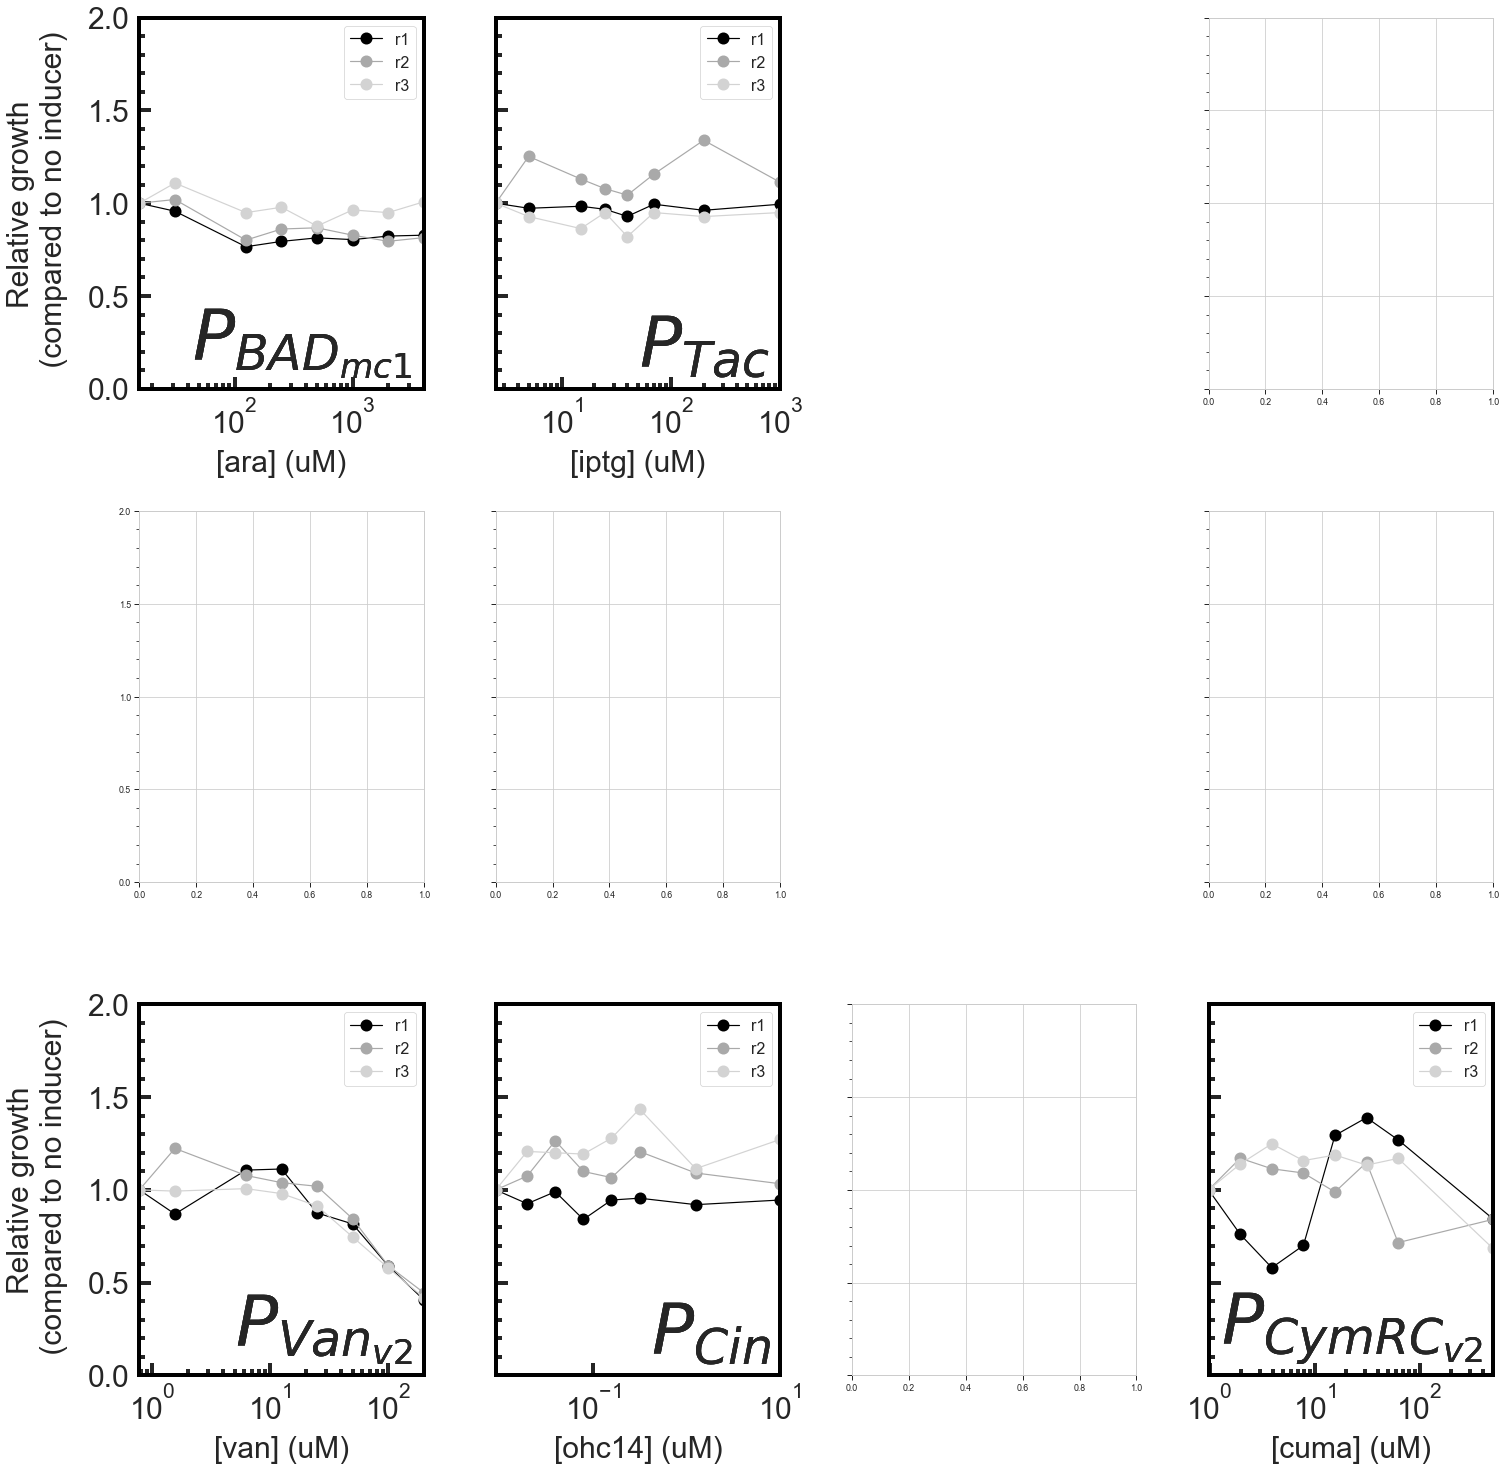

In [44]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# plot this relative growth measurement on y-axis with concentration on x-axis

fig_tox, ax_tox = plt.subplots(3,4, figsize=(22.5,22.5), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots

for m in media:
    for i in inducers:
        for p in parent:
            for s in ['AJT269','AJT270','AJT273','AJT274','AJT275','AJT276','AJT278']:
                for r in reps:
                    
                    if strain_info[s]['inducer']==i:
                    

                        for spine in ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].spines.values():
                                    spine.set_edgecolor('black')
                                    spine.set_linewidth(4)

                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].plot(inducer_info[i]['plot_conc'], tox_relative[m][i][p][s].loc[r,:],
                                                                    ms = 10, marker = plot_info[r][i]['marker'], linestyle = '-',
                                                                    color = plot_info[r][i]['linecolor'],
                                                                    mec = plot_info[r][i]['edgecolor'],
                                                                    mfc = plot_info[r][i]['edgecolor'], mew = 2, 
                                                                    label = r)


                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_yscale('linear')
                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_xscale('log')

                        if fig_pos[i]['fig_col'] == 0:                
                            ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_ylabel('Relative growth\n (compared to no inducer)', size = 30, labelpad = 20)

                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_xlabel('[{}] (uM)'.format(i), size = 30, labelpad = 10)  

                        if i == 'atc':
                            ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_xlabel('[{}] (nM)'.format(i), size = 30, labelpad = 10)

            #                 ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_title('{}'.format(strain_info[s]['promoter']), 
            #                                                                                size = 24, pad = 10)
                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_ylim(0,2)
                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_xlim(inducer_info[i]['plot_conc'][0],inducer_info[i]['plot_conc'][-1])

                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].yaxis.set_major_locator(MultipleLocator(0.5))
                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].yaxis.set_minor_locator(MultipleLocator(0.1))

    #                     ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_yticks(np.arange(0,2.1,0.1))
    #                     ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].tick_params(axis='y', which='minor',labelleft=False)


                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].tick_params(labelsize = 30, length = 12, width = 4, direction = 'in', pad = 10)
                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].tick_params(which='minor', length = 6, width = 4, direction = 'in')

                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].yaxis.grid(False)
                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].xaxis.grid(False)
                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend(markerscale = 1, fontsize = 16)
            #             ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

                        ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].text(max(inducer_info[i]['plot_conc'])/1.25, .05, strain_info[s]['promoter'], 
                                                                              verticalalignment = 'bottom', horizontalalignment = 'right', 
                                                                              fontsize = 70)

# # gets rid of empty plots
fig_tox.delaxes(ax_tox[0,2]) # zero indexing
fig_tox.delaxes(ax_tox[1,2]) # zero indexing
                

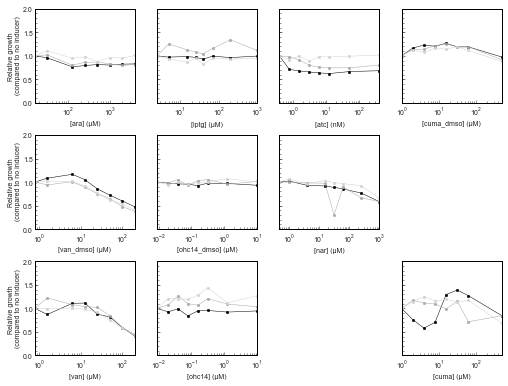

In [45]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# plot this relative growth measurement on y-axis with concentration on x-axis

rows = 3
cols = 4
fig_tox, ax_tox = plt.subplots(rows,cols, figsize=(7.2,7.2/cols*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 1, h_pad = 1, w_pad = 1) #tidies up spacing between plots

strains_subset = ['AJT270','AJT269','AJT273','AJT278','AJT276','AJT275','AJT274']
for m in media:
    for i in inducers:
        for p in parent:
            for s in strains_subset:
                if strain_info[s]['inducer']==i:
                    for r in reps:
                        

                        FP = ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]

                        for spine in FP.spines.values():
                                    spine.set_edgecolor('black')
                                    spine.set_linewidth(1)
                                    
                        FP.plot(inducer_info[i]['plot_conc'], tox_relative[m][i][p][s].loc[r,:],
                                ms = 2.5, marker = plot_info[r][i]['marker'], linestyle = '-',
                                color = plot_info[r][i]['linecolor'],
                                mec = plot_info[r][i]['edgecolor'],
                                mfc = plot_info[r][i]['edgecolor'], mew = 0.5, lw = 0.5,
                                label = r)

                        FP.set_yscale('linear')
                        FP.set_xscale('log')

                        if fig_pos[i]['fig_col'] == 0:                
                            FP.set_ylabel('Relative growth\n (compared to no inducer)', size = 7, labelpad = 2)

                        FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 2)  

                        if i == 'atc':
                            FP.set_xlabel('[{}] (nM)'.format(i), size = 7, labelpad = 2)

            #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
            #                                                                                size = 24, pad = 10)
                        FP.set_ylim(0,2)
                        FP.set_xlim(inducer_info[i]['plot_conc'][0],inducer_info[i]['plot_conc'][-1])

                        FP.yaxis.set_major_locator(MultipleLocator(0.5))
                        FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                        FP.yaxis.set_minor_locator(MultipleLocator(0.1))

        #                     FP.set_yticks(np.arange(0,2.1,0.1))
        #                     FP.tick_params(axis='y', which='minor',labelleft=False)


                        FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
                        FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')

                        FP.yaxis.grid(False)
                        FP.xaxis.grid(False)
        #             FP.legend(markerscale = 1, fontsize = 16)
        #             FP.legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info[i]['plot_conc'])/1.25, .05, strain_info[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)
                    
for m in media:
    for i in ind_dmso:
        for p in parent:
            for s in strains_dmso:
                if strain_info_dmso[s]['inducer']==i:
                    for r in reps:


                        FP = ax_tox[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]

                        for spine in FP.spines.values():
                                    spine.set_edgecolor('black')
                                    spine.set_linewidth(1)       

                        FP.plot(inducer_info_withdmso[i]['plot_conc'], tox2_relative[m][i][p][s].loc[r,:],
                                    ms = 2.5, marker = plot_info_withdmso[r][i]['marker'], linestyle = '-',
                                    color = plot_info_withdmso[r][i]['linecolor'],
                                    mec = plot_info_withdmso[r][i]['edgecolor'],
                                    mfc = plot_info_withdmso[r][i]['edgecolor'], mew = 0.5, lw = 0.5,
                                    label = r)

                        FP.set_yscale('linear')
                        FP.set_xscale('log')

                        if fig_pos[i]['fig_col'] == 0:                
                            FP.set_ylabel('Relative growth\n (compared to no inducer)', size = 7, labelpad = 2)

                        FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)  

            #                 ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_title('{}'.format(strain_info[s]['promoter']), 
            #                                                                                size = 24, pad = 10)
                        FP.set_ylim(0,2)
                        FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])

                        FP.yaxis.set_major_locator(MultipleLocator(0.5))
                        FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                        FP.yaxis.set_minor_locator(MultipleLocator(0.1))

    #                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_yticks(np.arange(0,2.1,0.1))
    #                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].tick_params(axis='y', which='minor',labelleft=False)


                        FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
                        FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')

                        FP.yaxis.grid(False)
                        FP.xaxis.grid(False)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend(markerscale = 1, fontsize = 16)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info_withdmso[i]['plot_conc'])/1.25, .05, strain_info_withdmso[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)


# # gets rid of empty plots
fig_tox.delaxes(ax_tox[1,3]) # zero indexing
fig_tox.delaxes(ax_tox[2,2]) # zero indexing

In [76]:
# fig_tox.savefig('EcN_Sensors_toxicity_EachReplicate_ALL.pdf', bbox_inches = "tight", transparent = True)

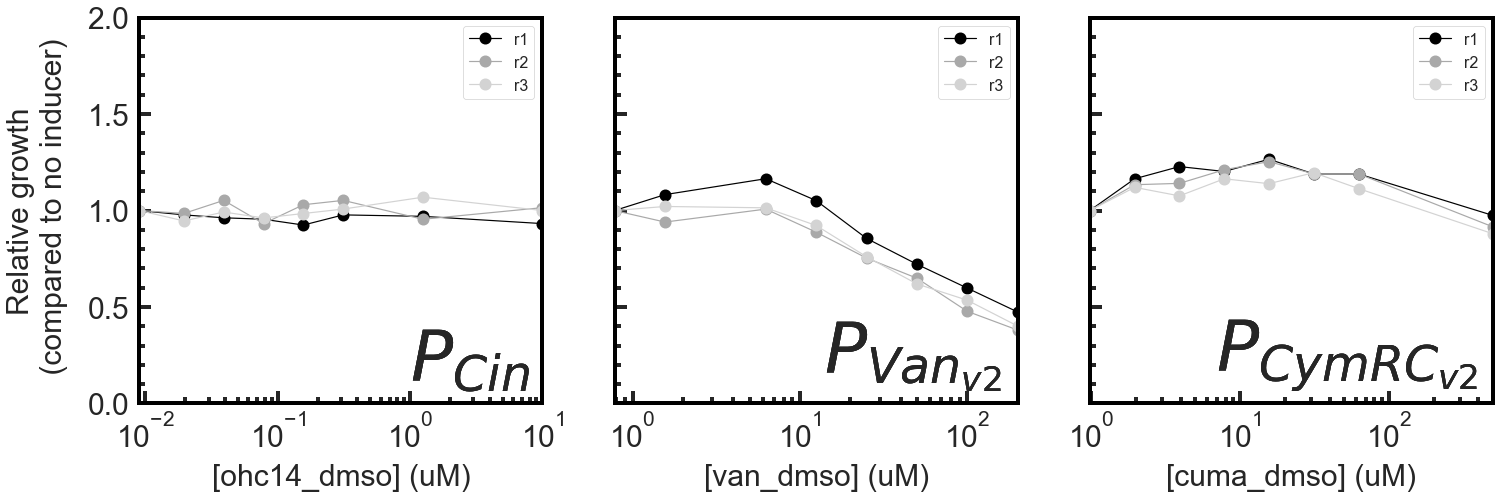

In [46]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# plot this relative growth measurement on y-axis with concentration on x-axis

fig_tox_dmso, ax_tox_dmso = plt.subplots(1,3, figsize=(22.5,9), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots

for m in media:
    for i in ind_dmso:
        for p in parent:
            for s in strains_dmso:
                for r in reps:
                    if strain_info_dmso[s]['inducer'] == i:
                       
                        FP = ax_tox_dmso[ind_dmso.index(i)]
                        
                        for spine in FP.spines.values():
                                    spine.set_edgecolor('black')
                                    spine.set_linewidth(4)

                        FP.plot(inducer_info_withdmso[i]['plot_conc'], tox2_relative[m][i][p][s].loc[r,:],
                                                                ms = 10, marker = plot_info_dmso[r][i]['marker'], linestyle = '-',
                                                                color = plot_info_dmso[r][i]['linecolor'],
                                                                mec = plot_info_dmso[r][i]['edgecolor'],
                                                                mfc = plot_info_dmso[r][i]['edgecolor'], mew = 2, 
                                                                label = r)


                        FP.set_yscale('linear')
                        FP.set_xscale('log')

                        if ind_dmso.index(i) == 0:                
                            FP.set_ylabel('Relative growth\n (compared to no inducer)', size = 30, labelpad = 20)

                        FP.set_xlabel('[{}] (uM)'.format(i), size = 30, labelpad = 10)  

                        if i == 'atc':
                            FP.set_xlabel('[{}] (nM)'.format(i), size = 30, labelpad = 10)

            #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                        FP.set_ylim(0,2)
                        FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])

                        FP.yaxis.set_major_locator(MultipleLocator(0.5))
                        FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                        FP.yaxis.set_minor_locator(MultipleLocator(0.1))

    #                     FP.set_yticks(np.arange(0,2.1,0.1))
    #                     FP.tick_params(axis='y', which='minor',labelleft=False)


                        FP.tick_params(labelsize = 30, length = 12, width = 4, direction = 'in', pad = 10)
                        FP.tick_params(which='minor', length = 6, width = 4, direction = 'in')

                        FP.yaxis.grid(False)
                        FP.xaxis.grid(False)
                        FP.legend(markerscale = 1, fontsize = 16)
            #             FP.legend.legendHandles._legmarker.set_markersize(50)

                        FP.text(max(inducer_info_withdmso[i]['plot_conc'])/1.25, .05, strain_info_dmso[s]['promoter'], 
                                                              verticalalignment = 'bottom', horizontalalignment = 'right', 
                                                              fontsize = 70)

# # # gets rid of empty plots
# fig_tox_dmso.delaxes(ax_tox_dmso[1,2]) # zero indexing
# fig_tox_dmso.delaxes(ax_tox_dmso[2,2]) # zero indexing
                

In [121]:
# fig_tox_dmso.savefig('EcN_Sensors_toxicity_EachReplicate_dmso.pdf', bbox_inches = "tight", transparent = True)


In [47]:
# take mean across replicates and standard deviation for toxicity measurements

tox_rel_means = dict()
tox_rel_stdevs = dict()
for m in media:
    tox_rel_means[m] = dict()
    tox_rel_stdevs[m] = dict()
    for i in inducers:
        tox_rel_means[m][i] = dict()
        tox_rel_stdevs[m][i] = dict()
        for p in parent:
            tox_rel_means[m][i][p] = dict()
            tox_rel_stdevs[m][i][p] = dict()
            
            strains_subset = [s for s in strains if (len(tox['r1_tidy'][tox['r1_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r1_tidy'][tox['r1_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later
            for s in strains_subset:
                tox_rel_means[m][i][p][s] = tox_relative[m][i][p][s].mean(axis = 0)
                tox_rel_stdevs[m][i][p][s] = tox_relative[m][i][p][s].std(axis = 0)
                
                

In [48]:
tox_rel_stdevs['M9']['ohc14']['EcN']['AJT275']

0.000000     0.000000
0.019531     0.140963
0.039062     0.143490
0.078125     0.182338
0.156250     0.168734
0.312500     0.240331
1.250000     0.105840
10.000000    0.168772
dtype: float64

In [49]:
# take mean across replicates and standard deviation for toxicity measurements

tox_means = dict()
tox_stdevs = dict()
for m in media:
    tox_means[m] = dict()
    tox_stdevs[m] = dict()
    for i in inducers:
        tox_means[m][i] = dict()
        tox_stdevs[m][i] = dict()
        for p in parent:
            tox_means[m][i][p] = dict()
            tox_stdevs[m][i][p] = dict()
            
            strains_subset = [s for s in strains if (len(tox['r1_tidy'][tox['r1_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r1_tidy'][tox['r1_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later
            for s in strains_subset:
                tox_means[m][i][p][s] = tox_data[m][i][p][s].mean(axis = 0)
                tox_stdevs[m][i][p][s] = tox_data[m][i][p][s].std(axis = 0)
                
                

In [50]:
# take mean across replicates and standard deviation for toxicity measurements

tox2_rel_means = dict()
tox2_rel_stdevs = dict()
for m in media:
    tox2_rel_means[m] = dict()
    tox2_rel_stdevs[m] = dict()
    for i in ind_dmso:
        tox2_rel_means[m][i] = dict()
        tox2_rel_stdevs[m][i] = dict()
        for p in parent:
            tox2_rel_means[m][i][p] = dict()
            tox2_rel_stdevs[m][i][p] = dict()
            
            strains_subset = [s for s in strains_dmso if (len(tox['r3_tidy'][tox['r3_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r3_tidy'][tox['r3_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later())] # need to separate this way for subtracting autfluorescence later
            for s in strains_subset:
                tox2_rel_means[m][i][p][s] = tox2_relative[m][i][p][s].mean(axis = 0)
                tox2_rel_stdevs[m][i][p][s] = tox2_relative[m][i][p][s].std(axis = 0)
                
                

In [51]:
tox2_rel_stdevs['M9']['ohc14_dmso']['EcN']['AJT275_dmso']

0.000000     0.000000
0.019531     0.020582
0.039062     0.045960
0.078125     0.015309
0.156250     0.052794
0.312500     0.037832
1.250000     0.062132
10.000000    0.044056
dtype: float64

In [52]:
# take mean across replicates and standard deviation for toxicity measurements

tox2_means = dict()
tox2_stdevs = dict()
for m in media:
    tox2_means[m] = dict()
    tox2_stdevs[m] = dict()
    for i in ind_dmso:
        tox2_means[m][i] = dict()
        tox2_stdevs[m][i] = dict()
        for p in parent:
            tox2_means[m][i][p] = dict()
            tox2_stdevs[m][i][p] = dict()
            
            strains_subset = [s for s in strains_dmso if (len(tox['r3_tidy'][tox['r3_tidy']['strain_num']==s][i].unique())>1 and
                                                     s in tox['r3_tidy'][tox['r3_tidy']['parent_strain']==p]['strain_num'].unique())] # need to separate this way for subtracting autfluorescence later())] # need to separate this way for subtracting autfluorescence later
            for s in strains_subset:
                tox2_means[m][i][p][s] = tox2_data[m][i][p][s].mean(axis = 0)
                tox2_stdevs[m][i][p][s] = tox2_data[m][i][p][s].std(axis = 0)
                
                

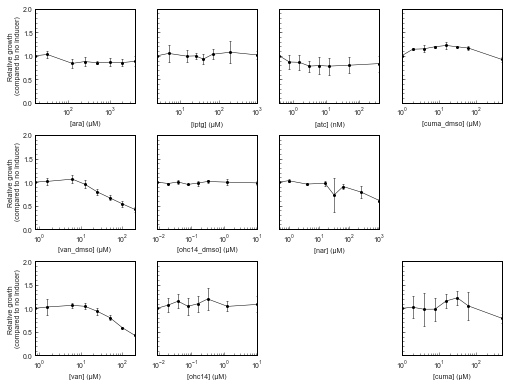

In [53]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# plot this relative growth measurement on y-axis with concentration on x-axis

rows = 3
cols = 4
fig_tox2, ax_tox2 = plt.subplots(rows,cols, figsize=(7.2,7.2/cols*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 1, h_pad = 1, w_pad = 1) #tidies up spacing between plots

strains_subset = ['AJT270','AJT269','AJT273','AJT278','AJT276','AJT275','AJT274']
for m in media:
    for i in inducers:
        for p in parent:
            for s in strains_subset:
                if strain_info[s]['inducer']==i:

                    FP = ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                
                    ## errorbars
                    FP.errorbar(inducer_info[i]['plot_conc'], tox_rel_means[m][i][p][s], yerr = tox_rel_stdevs[m][i][p][s],
                                ms = 2, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
        #                                                                     label = legend_names[strain_info[s]['parent']])

                    FP.set_yscale('linear')
                    FP.set_xscale('log')

                    if fig_pos[i]['fig_col'] == 0:                
                        FP.set_ylabel('Relative growth\n (compared to no inducer)', size = 7, labelpad = 2)

                    FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 2)  

                    if i == 'atc':
                        FP.set_xlabel('[{}] (nM)'.format(i), size = 7, labelpad = 2)

        #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,2)
                    FP.set_xlim(inducer_info[i]['plot_conc'][0],inducer_info[i]['plot_conc'][-1])
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.5))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.1))
                    
#                     FP.set_yticks(np.arange(0,2.1,0.1))
#                     FP.tick_params(axis='y', which='minor',labelleft=False)


                    FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             FP.legend(markerscale = 1, fontsize = 16)
        #             FP.legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info[i]['plot_conc'])/1.25, .05, strain_info[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)
                    
for m in media:
    for i in ind_dmso:
        for p in parent:
            for s in strains_dmso:
                if strain_info_dmso[s]['inducer']==i:

                    FP = ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                
                    ## errorbars
                    FP.errorbar(inducer_info_withdmso[i]['plot_conc'], tox2_rel_means[m][i][p][s], yerr = tox2_rel_stdevs[m][i][p][s],
                                ms = 2, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

                    FP.set_yscale('linear')
                    FP.set_xscale('log')

                    if fig_pos[i]['fig_col'] == 0:                
                        FP.set_ylabel('Relative growth\n (compared to no inducer)', size = 7, labelpad = 2)

                    FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)  

        #                 ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,2)
                    FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.5))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.1))
                    
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_yticks(np.arange(0,2.1,0.1))
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].tick_params(axis='y', which='minor',labelleft=False)


                    FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend(markerscale = 1, fontsize = 16)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info_withdmso[i]['plot_conc'])/1.25, .05, strain_info_withdmso[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)


# # gets rid of empty plots
fig_tox2.delaxes(ax_tox2[1,3]) # zero indexing
fig_tox2.delaxes(ax_tox2[2,2]) # zero indexing

In [434]:
# fig_tox2.savefig('EcN_Sensors_toxicity_errorbars_black.pdf', bbox_inches = "tight", transparent = True)


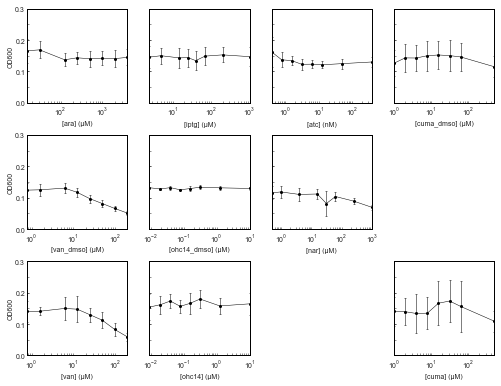

In [54]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# plot unnormalized growth measurement on y-axis with concentration on x-axis

rows = 3
cols = 4
fig_tox3, ax_tox3 = plt.subplots(rows,cols, figsize=(7.2,7.2/cols*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(pad = 1, h_pad = 1, w_pad = 1) #tidies up spacing between plots

strains_subset = ['AJT270','AJT269','AJT273','AJT278','AJT276','AJT275','AJT274']
for m in media:
    for i in inducers:
        for p in parent:
            for s in strains_subset:
                if strain_info[s]['inducer']==i:

                    FP = ax_tox3[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                
                    ## errorbars
                    FP.errorbar(inducer_info[i]['plot_conc'], tox_means[m][i][p][s], yerr = tox_stdevs[m][i][p][s],
                                ms = 2, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
        #                                                                     label = legend_names[strain_info[s]['parent']])

                    FP.set_yscale('linear')
                    FP.set_xscale('log')

                    if fig_pos[i]['fig_col'] == 0:                
                        FP.set_ylabel('OD600', size = 7, labelpad = 2)

                    FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 2)  

                    if i == 'atc':
                        FP.set_xlabel('[{}] (nM)'.format(i), size = 7, labelpad = 2)

        #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,0.3)
                    FP.set_xlim(inducer_info[i]['plot_conc'][0],inducer_info[i]['plot_conc'][-1])
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.1))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.05))
                    
#                     FP.set_yticks(np.arange(0,2.1,0.1))
#                     FP.tick_params(axis='y', which='minor',labelleft=False)


                    FP.tick_params(labelsize = 7, length = 2, width = 0.5, direction = 'in', pad = 2)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             FP.legend(markerscale = 1, fontsize = 16)
        #             FP.legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info[i]['plot_conc'])/1.25, .05, strain_info[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)
                    
for m in media:
    for i in ind_dmso:
        for p in parent:
            for s in strains_dmso:
                if strain_info_dmso[s]['inducer']==i:

                    FP = ax_tox3[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                
                    ## errorbars
                    FP.errorbar(inducer_info_withdmso[i]['plot_conc'], tox2_means[m][i][p][s], yerr = tox2_stdevs[m][i][p][s],
                                ms = 2, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

                    FP.set_yscale('linear')
                    FP.set_xscale('log')

                    if fig_pos[i]['fig_col'] == 0:                
                        FP.set_ylabel('OD600', size = 7, labelpad = 2)

                    FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)  

        #                 ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,0.3)
                    FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.1))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.05))
                    
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_yticks(np.arange(0,2.1,0.1))
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].tick_params(axis='y', which='minor',labelleft=False)


                    FP.tick_params(labelsize = 7, length = 2, width = 0.5, direction = 'in', pad = 2)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend(markerscale = 1, fontsize = 16)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info_withdmso[i]['plot_conc'])/1.25, .05, strain_info_withdmso[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)


# # gets rid of empty plots
fig_tox3.delaxes(ax_tox3[1,3]) # zero indexing
fig_tox3.delaxes(ax_tox3[2,2]) # zero indexing

In [83]:
# fig_tox3.savefig('EcN_Sensors_toxicity_errorbars_black_unnormalized.pdf', bbox_inches = "tight", transparent = True)


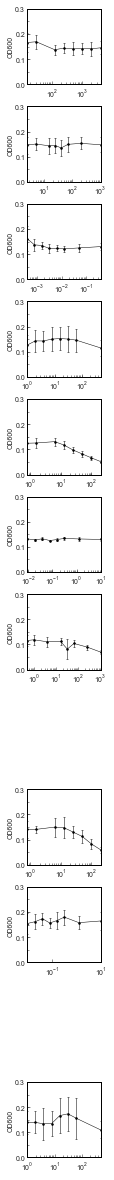

In [55]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# plot unnormalized growth measurement on y-axis with concentration on x-axis

rows = 12
cols = 1
fig_tox4, ax_tox4 = plt.subplots(rows,cols, figsize=(1.69*cols,1.38*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(h_pad = 0) #tidies up spacing between plots

strains_subset = ['AJT270','AJT269','AJT273','AJT278','AJT276','AJT275','AJT274']
for m in media:
    for i in inducers:
        for p in parent:
            for s in strains_subset:
                if strain_info[s]['inducer']==i:

                    FP = ax_tox4[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                
                    ## errorbars
                    
                    # atc needs to be converted to uM instead of nM
                    if i == 'atc':
                        FP.errorbar((pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist(),
                                    tox_means[m][i][p][s], yerr = tox_stdevs[m][i][p][s],
                                    ms = 1.5, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                    mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                    elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
                        
                    else:
                        FP.errorbar(inducer_info[i]['plot_conc'], tox_means[m][i][p][s], yerr = tox_stdevs[m][i][p][s],
                                ms = 1.5, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
        #                                                                     label = legend_names[strain_info[s]['parent']])

                    FP.set_yscale('linear')
                    FP.set_xscale('log')

#                     if fig_pos[i]['fig_col'] == 0:                
                    FP.set_ylabel('OD600', size = 7, labelpad = 2)

#                     FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)  

#                     if i == 'atc':
#                         FP.set_xlabel('[{}] (nM)'.format(i), size = 7, labelpad = 1)

        #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,0.3)
            
                    if i == 'atc':
                        FP.set_xlim(inducer_info[i]['plot_conc'][0]/1000,inducer_info[i]['plot_conc'][-1]/1000)
                    else:
                        FP.set_xlim(inducer_info[i]['plot_conc'][0],inducer_info[i]['plot_conc'][-1])
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.1))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.05))
                    
#                     FP.set_yticks(np.arange(0,2.1,0.1))
#                     FP.tick_params(axis='y', which='minor',labelleft=False)


                    FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             FP.legend(markerscale = 1, fontsize = 16)
        #             FP.legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info[i]['plot_conc'])/1.25, .05, strain_info[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)
                    
for m in media:
    for i in ind_dmso:
        for p in parent:
            for s in strains_dmso:
                if strain_info_dmso[s]['inducer']==i:

                    FP = ax_tox4[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                
                    ## errorbars
                    FP.errorbar(inducer_info_withdmso[i]['plot_conc'], tox2_means[m][i][p][s], yerr = tox2_stdevs[m][i][p][s],
                                ms = 1.5, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

                    FP.set_yscale('linear')
                    FP.set_xscale('log')

#                     if fig_pos[i]['fig_col'] == 0:                
                    FP.set_ylabel('OD600', size = 7, labelpad = 2)

#                     FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)  

        #                 ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,0.3)
                    FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.1))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.05))
                    
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_yticks(np.arange(0,2.1,0.1))
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].tick_params(axis='y', which='minor',labelleft=False)

                    ## set x ticks
                    x_major = matplotlib.ticker.LogLocator(base = 10.0, 
                                                           numticks = round((inducer_info_withdmso[i]['plot_conc'][-1]/inducer_info_withdmso[i]['plot_conc'][0])/10))
                    FP.xaxis.set_major_locator(x_major)
                    x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
                    FP.xaxis.set_minor_locator(x_minor)
                    FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


                    FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend(markerscale = 1, fontsize = 16)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info_withdmso[i]['plot_conc'])/1.25, .05, strain_info_withdmso[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)


# # # gets rid of empty plots
fig_tox4.delaxes(ax_tox4[7]) # zero indexing
fig_tox4.delaxes(ax_tox4[10]) # zero indexing

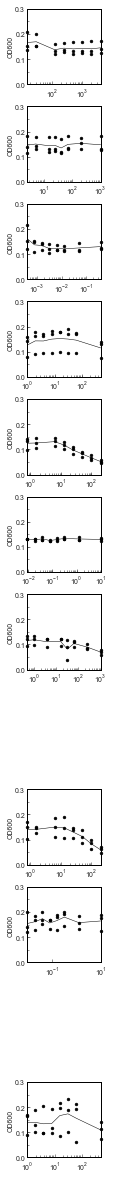

In [57]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# plot unnormalized growth measurement on y-axis with concentration on x-axis

rows = 12
cols = 1
fig_tox4, ax_tox4 = plt.subplots(rows,cols, figsize=(1.69*cols,1.38*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(h_pad = 0) #tidies up spacing between plots

strains_subset = ['AJT270','AJT269','AJT273','AJT278','AJT276','AJT275','AJT274']
for m in media:
    for i in inducers:
        for p in parent:
            for s in strains_subset:
                if strain_info[s]['inducer']==i:

                    FP = ax_tox4[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                

                    for r in reps:
                    
                        # atc needs to be converted to uM instead of nM
                        if i == 'atc':
                            FP.scatter((pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist(),
                                        tox_data[m][i][p][s].loc[r,:],
                                        linewidths = 0.5, marker = 'o', s = 8, zorder=1,c = 'black', clip_on=False)
                            
                            


                        else:
                            FP.scatter(inducer_info[i]['plot_conc'], tox_data[m][i][p][s].loc[r,:],
                                    linewidths = 0.5, marker = 'o', s = 8, zorder=1,c = 'black', clip_on=False)

                    if i == 'atc':
                        FP.plot((pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist(),
                                tox_means[m][i][p][s], lw=0.5, c='black')
                    else:
                        FP.plot(inducer_info[i]['plot_conc'], tox_means[m][i][p][s], lw=0.5, c='black')
                            
                    FP.set_yscale('linear')
                    FP.set_xscale('log')

#                     if fig_pos[i]['fig_col'] == 0:                
                    FP.set_ylabel('OD600', size = 7, labelpad = 2)

#                     FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)  

#                     if i == 'atc':
#                         FP.set_xlabel('[{}] (nM)'.format(i), size = 7, labelpad = 1)

        #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,0.3)
            
                    if i == 'atc':
                        FP.set_xlim(inducer_info[i]['plot_conc'][0]/1000,inducer_info[i]['plot_conc'][-1]/1000)
                    else:
                        FP.set_xlim(inducer_info[i]['plot_conc'][0],inducer_info[i]['plot_conc'][-1])
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.1))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.05))
                    
#                     FP.set_yticks(np.arange(0,2.1,0.1))
#                     FP.tick_params(axis='y', which='minor',labelleft=False)


                    FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             FP.legend(markerscale = 1, fontsize = 16)
        #             FP.legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info[i]['plot_conc'])/1.25, .05, strain_info[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)
                    
for m in media:
    for i in ind_dmso:
        for p in parent:
            for s in strains_dmso:
                if strain_info_dmso[s]['inducer']==i:

                    FP = ax_tox4[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                
#                     ## errorbars
#                     FP.errorbar(inducer_info_withdmso[i]['plot_conc'], tox2_means[m][i][p][s], yerr = tox2_stdevs[m][i][p][s],
#                                 ms = 1.5, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
#                                 mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
#                                 elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
# #                                                                     label = legend_names[strain_info[s]['parent']])
                    for r in reps:
                        FP.scatter(inducer_info_withdmso[i]['plot_conc'],
                                            tox2_data[m][i][p][s].loc[r,:],
                                            linewidths = 0.5, marker = 'o', s = 8, zorder=1,c = 'black',
                                  clip_on=False)

                    FP.plot(inducer_info_withdmso[i]['plot_conc'], tox2_means[m][i][p][s], lw=0.5, c='black')
                
                    FP.set_yscale('linear')
                    FP.set_xscale('log')

#                     if fig_pos[i]['fig_col'] == 0:                
                    FP.set_ylabel('OD600', size = 7, labelpad = 2)

#                     FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)  

        #                 ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,0.3)
                    FP.set_xlim(inducer_info_withdmso[i]['plot_conc'][0],inducer_info_withdmso[i]['plot_conc'][-1])
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.1))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.05))
                    
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_yticks(np.arange(0,2.1,0.1))
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].tick_params(axis='y', which='minor',labelleft=False)

                    ## set x ticks
                    x_major = matplotlib.ticker.LogLocator(base = 10.0, 
                                                           numticks = round((inducer_info_withdmso[i]['plot_conc'][-1]/inducer_info_withdmso[i]['plot_conc'][0])/10))
                    FP.xaxis.set_major_locator(x_major)
                    x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
                    FP.xaxis.set_minor_locator(x_minor)
                    FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


                    FP.tick_params(labelsize = 7, length = 3, width = 0.5, direction = 'in', pad = 2)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend(markerscale = 1, fontsize = 16)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info_withdmso[i]['plot_conc'])/1.25, .05, strain_info_withdmso[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)


# # # gets rid of empty plots
fig_tox4.delaxes(ax_tox4[7]) # zero indexing
fig_tox4.delaxes(ax_tox4[10]) # zero indexing

In [58]:
# fig_tox4.savefig('FigS5_EcN_Sensors_toxicity_AllPoints_black_unnormalized_onecolumn.pdf', bbox_inches = "tight", transparent = True)


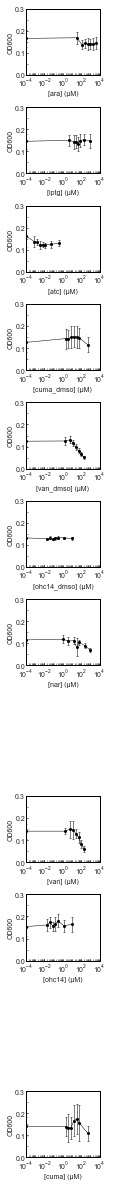

In [116]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# plot unnormalized growth measurement on y-axis with concentration on x-axis

rows = 12
cols = 1
fig_tox5, ax_tox5 = plt.subplots(rows,cols, figsize=(1.69*cols,1.38*rows), sharey = 'row') # row, column format
# fig, ax = plt.subplots(4,2, figsize=(15,30), sharey = 'row') # row, column format
plt.tight_layout(h_pad = 1) #tidies up spacing between plots

strains_subset = ['AJT270','AJT269','AJT273','AJT278','AJT276','AJT275','AJT274']
for m in media:
    for i in inducers:
        for p in parent:
            for s in strains_subset:
                if strain_info[s]['inducer']==i:

                    FP = ax_tox5[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                
                    ## errorbars
                    if i == 'atc':
                        FP.errorbar([0.0001]+(pd.Series(inducer_info_withdmso['atc']['plot_conc'])/1000).tolist()[1:],
                                    tox_means[m][i][p][s], yerr = tox_stdevs[m][i][p][s],
                                    ms = 2, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                    mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                    elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
                        
                    else:
                        FP.errorbar([0.0001]+inducer_info_withdmso[i]['plot_conc'][1:], 
                                tox_means[m][i][p][s], yerr = tox_stdevs[m][i][p][s],
                                ms = 2, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
        #                                                                     label = legend_names[strain_info[s]['parent']])

                    FP.set_yscale('linear')
                    FP.set_xscale('log')

#                     if fig_pos[i]['fig_col'] == 0:                
                    FP.set_ylabel('OD600', size = 7, labelpad = 2)

                    FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)  

#                     if i == 'atc':
#                         FP.set_xlabel('[{}] (nM)'.format(i), size = 7, labelpad = 1)

        #                 FP.set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,0.3)
                    FP.set_xlim(0.0001, 10000)
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.1))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.05))
                    
#                     FP.set_yticks(np.arange(0,2.1,0.1))
#                     FP.tick_params(axis='y', which='minor',labelleft=False)

                    ## set x ticks
                    x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
                    FP.xaxis.set_major_locator(x_major)
                    x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
                    FP.xaxis.set_minor_locator(x_minor)
                    FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


                    FP.tick_params(labelsize = 7, length = 2, width = 0.5, direction = 'in', pad = 1)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             FP.legend(markerscale = 1, fontsize = 16)
        #             FP.legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info[i]['plot_conc'])/1.25, .05, strain_info[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)
                    
for m in media:
    for i in ind_dmso:
        for p in parent:
            for s in strains_dmso:
                if strain_info_dmso[s]['inducer']==i:

                    FP = ax_tox5[(fig_pos[i]['fig_row']*4)+fig_pos[i]['fig_col']]
                    
                    for spine in FP.spines.values():
                                spine.set_edgecolor('black')
                                spine.set_linewidth(1)
                                
                    ## errorbars
                    FP.errorbar([0.0001]+inducer_info_withdmso[i]['plot_conc'][1:],
                                tox2_means[m][i][p][s], yerr = tox2_stdevs[m][i][p][s],
                                ms = 2, zorder=1, fmt='o-', c = 'black', # marker, line, color shorthand notation
                                mfc = 'black', mec = 'black', ecolor = 'black', lw= 0.5, 
                                elinewidth = 0.5, capsize = 1, capthick = 0.5)#,
#                                                                     label = legend_names[strain_info[s]['parent']])

                    FP.set_yscale('linear')
                    FP.set_xscale('log')

#                     if fig_pos[i]['fig_col'] == 0:                
                    FP.set_ylabel('OD600', size = 7, labelpad = 2)

                    FP.set_xlabel('[{}] (\u03BCM)'.format(i), size = 7, labelpad = 1)  

        #                 ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_title('{}'.format(strain_info[s]['promoter']), 
        #                                                                                size = 24, pad = 10)
                    FP.set_ylim(0,0.3)
                    FP.set_xlim(0.0001, 10000)
                    
                    FP.yaxis.set_major_locator(MultipleLocator(0.1))
                    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                    FP.yaxis.set_minor_locator(MultipleLocator(0.05))
                    
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].set_yticks(np.arange(0,2.1,0.1))
#                     ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].tick_params(axis='y', which='minor',labelleft=False)

                    ## set x ticks
                    x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
                    FP.xaxis.set_major_locator(x_major)
                    x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
                    FP.xaxis.set_minor_locator(x_minor)
                    FP.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

                    FP.tick_params(labelsize = 7, length = 2, width = 0.5, direction = 'in', pad = 1)
                    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')
        
                    FP.yaxis.grid(False)
                    FP.xaxis.grid(False)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend(markerscale = 1, fontsize = 16)
        #             ax_tox2[fig_pos[i]['fig_row']][fig_pos[i]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

#                     FP.text(max(inducer_info_withdmso[i]['plot_conc'])/1.25, .05, strain_info_withdmso[s]['promoter'], 
#                                                                           verticalalignment = 'bottom', horizontalalignment = 'right', 
#                                                                           fontsize = 14)


# # # gets rid of empty plots
fig_tox5.delaxes(ax_tox5[7]) # zero indexing
fig_tox5.delaxes(ax_tox5[10]) # zero indexing

In [117]:
# fig_tox5.savefig('EcN_Sensors_toxicity_errorbars_black_unnormalized_onecolumn_samex.pdf', bbox_inches = "tight", transparent = True)